# Evidence Tree - Evidence based clustering (WIP)

In [1]:
import numpy as np
import pandas as pd

In [2]:
from sklearn.datasets import load_boston, load_breast_cancer, load_iris

In [3]:
from sklearn.utils.random import sample_without_replacement

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [5]:
import itertools

In [6]:
import warnings

In [7]:
plt.style.use('bmh')

## Expected procedure:
1) Make all columns descrete by binnig

2) Calculate Evidence factor as ln(evidence / non-evidence)

3) Calculate Polychoric Correlation between variables ( cos(180/(srt(AC/BD)+1)) where AC/BD are odds ration of 2x2 matrix)

4) Define weighted polychoric corelation (one vs rest for each pair of variable) and score each variable

5) Make binary split on positive - negative scores on each variable

6) Iterate on partition of data made until stopping criteria is met

7) Add negative ciretria at each node to reject its presence in data

** Ideal expectation: Tree should build more on positive side of any variable. Or splitting needs to be redefined. **

### Stopping criteria:
 * Granularity : evidences factor in each node
 * Complexity  : Weighted evidenc factor in tree hierarchy( higher the better and less complex)
 * Grouping    : Support and Lift for each combination from root to leaf
 * Buckets     : No of bucket / categories to be available at each step (cannot be less than 3)
 * Reusage     : Restrict the reusage of variable for making split ( curently its non restricted and this needs to be evaluated)
 * 
 * Other       : Width / depth /
 
### Outcomes:
 * Evidence score   : The more the new observation goes down the tree greater is the evidence score ( This is to be used in conjunction with cluster of data which they belong)
 * Evidence distance: The whole tree nodes lie on the distance from the root node with distance being weighted evidence factor from previous node.
 * Clustering       : Similar evidence buckets can be said as cluster ( similarity yet to be decided) / or score cutoff can be used to defince cluster as in hierarchichal clustering
 * Classifier       : Evidently with each node we can attach class weigths and socre for probability socres / logitstic regression on each leaf bucket of tree
 * Regression       : Regression on each subset/ bucket of tree leaf nodes
 * Association      : Every combination from root to leaf can defined as and assoicatied group in data
 * Variabel score   : Variable importance scoring based on no of usages and and weigthed evidence factor 
 

In [8]:
def get_data(dataname):
    
    if dataname == 'iris':
        data = load_iris()
    elif dataname == 'boston':
        data = load_boston()
    elif dataname == 'cancer':
        data = load_breast_cancer()
    df  = pd.concat([pd.DataFrame(data.data),pd.DataFrame(data.target)],axis = 1)
    names = [i for i in data.feature_names]
    names.append('target')
    df.columns = names
    print(df.head())
    print(df.describe())
    return df




In [9]:
df = get_data('boston')


      CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900  1.0  296.0   
1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671  2.0  242.0   
2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671  2.0  242.0   
3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622  3.0  222.0   
4  0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622  3.0  222.0   

   PTRATIO       B  LSTAT  target  
0     15.3  396.90   4.98    24.0  
1     17.8  396.90   9.14    21.6  
2     17.8  392.83   4.03    34.7  
3     18.7  394.63   2.94    33.4  
4     18.7  396.90   5.33    36.2  
             CRIM          ZN       INDUS        CHAS         NOX          RM  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean     3.593761   11.363636   11.136779    0.069170    0.554695    6.284634   
std      8.596783   23.322453    6.860353    0.253994    0.115878    0.702617   
min      0.006320    

In [10]:
def ef_cat(arr, return_array = False, verbose=False):
    unq = np.unique(arr)
    tot_events = arr.shape[0]
    woe = []
    for i in unq:
        events = np.sum(arr == i)
        non_events = tot_events - events
        woe.append(np.log(events/non_events))
    if verbose>0:
        print('Data has uniques:\n {} \nand respective WOE:\n {} Net WOE: {}'.format(unq,woe,np.sum(woe)))
    if return_array:
        return np.sum(woe), woe
    return np.sum(woe)

def evidence_criterias(criteria, hist, events):
    
    if criteria == 'base':
        return np.any(hist <= 5)
    elif criteria == 'twocr':
        return np.any(hist <= 5) and np.any(hist <= 0.05*events)
    elif criteria == 'max10': # still need to think on this
        hist_max = np.max(hist)
        uquart,lquart = np.percentile(hist, [75,25])
        print(hist_max,uquart,lquart,(hist_max-uquart),1.1*uquart)
        if (hist_max-uquart) > 1.1*uquart:
            return False
        else:
            return True
    elif criteria == 'iqrlow':
        uquart,lquart = np.percentile(hist, [75,25])
        print(np.min(hist),uquart,lquart,(lquart - 0.5*(uquart-lquart)))
        if np.min(hist) < (lquart - 0.5*(uquart-lquart)):
            return False
        else:
            return True
    elif criteria == 'iqrhigh':
        uquart,lquart = np.percentile(hist, [75,25])
        print(np.max(hist),uquart,lquart,(uquart + 1.5*(uquart-lquart)))
        if np.max(hist) > (uquart + 1.5*(uquart-lquart)):
            return False
        else:
            return True
    elif criteria == 'iqrbi' or criteria == 'biiqr':
        uquart, lquart = np.percentile(hist, [75,25])
        print(uquart,lquart,np.min(hist),(lquart - 0.5*(uquart-lquart)),np.max(hist),(uquart + 1.5*(uquart-lquart)),np.min(hist) <= (lquart - 0.5*(uquart-lquart)),np.max(hist) >= (uquart + 1.5*(uquart-lquart)))
        if np.min(hist) <= (lquart - 0.5*(uquart-lquart)) and np.max(hist) >= (uquart + 1.5*(uquart-lquart)):
            return False
        else:
            return True

    

def ef_num(arr, bins=20, check_evidence=True, evidence_criteria = 'base', return_array = False, verbose=0):
    
    # basic data storage
    arr = arr.reshape(-1,1)
    tot_events = arr.shape[0]
    ref = []
    bin_flag = True
    
    # calculating first histogram
    hist, unq = np.histogram(arr, bins=bins)
    
    if isinstance(bins,str):
        bin_flag = False
    else:
        bins = bins-1
    
    # checking conditions if behaviour of histogram for further usages
    # checking for binary condition, if binary then evalute using categorical function
    if np.unique(hist).shape[0] == 3:

        if verbose > 0:
            print('Evident number of Bins: {}'.format(bins))
        return ef_cat(arr, return_array=return_array, verbose=verbose)
    
    #checking for evidences when number of bins are given
    elif check_evidence and bin_flag:
        while evidence_criterias(evidence_criteria, hist, tot_events) :
            bins -= 1
            if verbose >2:
                print('Reducing bins to get proper evidences! Old Histogram:{} \n New bin size:{}'.format(hist,bins))
            hist,unq = np.histogram(arr, bins=bins)
        if bins == 1:
            bins = 2
        if verbose > 0:
            print('Evident number of Bins: {}'.format(bins))   
    
    # checking evidences when standard methods provided by numpy is used
    elif check_evidence and not bin_flag:
        if verbose > 2:
            print('Before checking histogram:\nHist: {} \nUnique splits: {}'.format(hist,unq))
        while np.any(hist == 0):
            # print("O indexes:", np.where(hist == 0))
            idx = np.where(hist == 0)[0]
            # print('Hist: {}, binstart: {}'.format(hist[idx],unq[idx]))
            unq = np.delete(unq,idx)
            hist = np.delete(hist,idx)
        hist, unq = np.histogram(arr,bins=unq)
        if verbose > 2:
            print('After checking histogram:\nHist: {} \nUnique splits: {}'.format(hist,unq))
        if verbose > 0:
            print('Evident number of Bins: {}'.format(len(unq)-1))
            
    # do notihing default for fallbacks
    else:
        if verbose>2:
            print('Hist: {} \n Unique splits: {}'.format(hist,unq))
        if verbose > 0:
            print('Evident number of Bins: {}'.format(len(unq)-1))
    
    # following if a very bad hack to overcome digitize problem... might be changed in future...
    # redoing binnig based on unq edges
    arr = np.digitize(arr, bins=unq, right=False)
    # recalculating bincounts
    hist = np.bincount(arr.flatten())
    hist = hist[hist != 0]
    
#     print('{}:{}'.format(hist.shape[0],np.unique(arr).shape[0]))
    assert hist.shape[0] == np.unique(arr).shape[0]
    
    # calculating relative evidence factor (ref)
    for val in hist:
        events = val
        non_events = tot_events - events
        if events == 0:
            ref.append(np.log(1e-3/tot_events))
        else:
            ref.append(np.log(events/non_events))
    
    #asserting the number or relative evidence factor (ref) == number of bins in histogram
    assert len(ref) == len(hist)
    
    if verbose > 1:
        print('Bins on data are:\n {} \nRespective Sizes:\n {}\nRespective WOE:\n {}\nNet WOE: {}'.format(unq,hist,ref,np.sum(ref)))
    
    # returning array of histogram bins
    if return_array:
        return np.array(ref), arr, unq, hist
    
    # default return value
    return np.sum(ref)
    
    
    

In [11]:
ef_cat(df.iloc[:,4].values)

-375.93812815564706

In [12]:
h_,u_ = np.histogram(df.iloc[:,2],bins='rice')
print('H:{} \nU:{}'.format(h_,u_))
a = np.digitize(df.iloc[:,2], bins=u_, right=False)
h_.shape,h_[h_!=0].shape,u_.shape,a.shape,np.unique(a),np.unique(a).shape

H:[ 24  56  57  65  48  40   9  15   3   0 132  30  15   0   7   5] 
U:[  0.46    2.165   3.87    5.575   7.28    8.985  10.69   12.395  14.1
  15.805  17.51   19.215  20.92   22.625  24.33   26.035  27.74 ]


((16,),
 (14,),
 (17,),
 (506,),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 11, 12, 13, 15, 17]),
 (14,))

In [13]:
efs1 = ef_num(df.iloc[:,2].values,bins='fd',return_array=True,verbose=3)
np.bincount(efs1[1].flatten()),np.unique(efs1[1])

Before checking histogram:
Hist: [ 75 111  64  49  18 132  30  15  12] 
Unique splits: [  0.46         3.49111111   6.52222222   9.55333333  12.58444444
  15.61555556  18.64666667  21.67777778  24.70888889  27.74      ]
After checking histogram:
Hist: [ 75 111  64  49  18 132  30  15  12] 
Unique splits: [  0.46         3.49111111   6.52222222   9.55333333  12.58444444
  15.61555556  18.64666667  21.67777778  24.70888889  27.74      ]
Evident number of Bins: 9
Bins on data are:
 [  0.46         3.49111111   6.52222222   9.55333333  12.58444444
  15.61555556  18.64666667  21.67777778  24.70888889  27.74      ] 
Respective Sizes:
 [ 75 111  64  49  18 132  30  15   7   5]
Respective WOE:
 [-1.7486199765674373, -1.2693555635887876, -1.9324267987180261, -2.2328630927835782, -3.2999436479569826, -1.041453874828161, -2.7642204725692645, -3.4883939266923107, -4.2666959466962053, -4.6071681886507641]
Net WOE: -26.65114148905152


(array([  0,  75, 111,  64,  49,  18, 132,  30,  15,   7,   5]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]))

In [16]:
efs1 = ef_num(df.iloc[:,2].values,bins='fd',return_array=True,verbose=3)
a = np.bincount(efs1[1].flatten())
np.bincount(efs1[1].flatten()),a[a != 0],np.unique(efs1[1]),np.unique(efs1[1]).shape,a[a != 0].shape,efs1[0].shape

Before checking histogram:
Hist: [ 75 111  64  49  18 132  30  15  12] 
Unique splits: [  0.46         3.49111111   6.52222222   9.55333333  12.58444444
  15.61555556  18.64666667  21.67777778  24.70888889  27.74      ]
After checking histogram:
Hist: [ 75 111  64  49  18 132  30  15  12] 
Unique splits: [  0.46         3.49111111   6.52222222   9.55333333  12.58444444
  15.61555556  18.64666667  21.67777778  24.70888889  27.74      ]
Evident number of Bins: 9
Bins on data are:
 [  0.46         3.49111111   6.52222222   9.55333333  12.58444444
  15.61555556  18.64666667  21.67777778  24.70888889  27.74      ] 
Respective Sizes:
 [ 75 111  64  49  18 132  30  15   7   5]
Respective WOE:
 [-1.7486199765674373, -1.2693555635887876, -1.9324267987180261, -2.2328630927835782, -3.2999436479569826, -1.041453874828161, -2.7642204725692645, -3.4883939266923107, -4.2666959466962053, -4.6071681886507641]
Net WOE: -26.65114148905152


(array([  0,  75, 111,  64,  49,  18, 132,  30,  15,   7,   5]),
 array([ 75, 111,  64,  49,  18, 132,  30,  15,   7,   5]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 (10,),
 (10,),
 (10,))

In [20]:
efs2 = ef_num(df.iloc[:,4].values,bins='rice',return_array=True,verbose=3)
efs1[0].shape,efs2[0].shape,efs1[2].shape,efs2[2].shape,np.unique(efs1[1]).shape,np.unique(efs2[1]).shape,np.unique(efs1[1]),np.unique(efs2[1])

Before checking histogram:
Hist: [43 68 44 45 49 48 44 41 18 20 49 13  8  0  0 16] 
Unique splits: [ 0.385     0.415375  0.44575   0.476125  0.5065    0.536875  0.56725
  0.597625  0.628     0.658375  0.68875   0.719125  0.7495    0.779875
  0.81025   0.840625  0.871   ]
After checking histogram:
Hist: [43 68 44 45 49 48 44 41 18 20 49 13  8 16] 
Unique splits: [ 0.385     0.415375  0.44575   0.476125  0.5065    0.536875  0.56725
  0.597625  0.628     0.658375  0.68875   0.719125  0.7495    0.840625
  0.871   ]
Evident number of Bins: 14
Bins on data are:
 [ 0.385     0.415375  0.44575   0.476125  0.5065    0.536875  0.56725
  0.597625  0.628     0.658375  0.68875   0.719125  0.7495    0.840625
  0.871   ] 
Respective Sizes:
 [43 68 44 45 49 48 44 41 18 20 49 13  8 16]
Respective WOE:
 [-2.3765269383926717, -1.8627112052003394, -2.3513752571634776, -2.326735553226329, -2.2328630927835782, -2.2556681732062942, -2.3513752571634776, -2.4284653388830484, -3.2999436479569826, -3.19047635034

((10,),
 (14,),
 (10,),
 (15,),
 (10,),
 (14,),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 15]))

In [21]:
efs1 = ef_num(df.iloc[:,2].values,bins='fd',return_array=True,verbose=3)
efs2 = ef_num(df.iloc[:,4].values,bins='fd',return_array=True,verbose=3)
print(efs1[0].shape,efs2[0].shape,efs1[2].shape,efs2[2].shape,np.unique(efs1[1]).shape,np.unique(efs2[1]).shape,np.unique(efs1[1]),np.unique(efs2[1]))

Before checking histogram:
Hist: [ 75 111  64  49  18 132  30  15  12] 
Unique splits: [  0.46         3.49111111   6.52222222   9.55333333  12.58444444
  15.61555556  18.64666667  21.67777778  24.70888889  27.74      ]
After checking histogram:
Hist: [ 75 111  64  49  18 132  30  15  12] 
Unique splits: [  0.46         3.49111111   6.52222222   9.55333333  12.58444444
  15.61555556  18.64666667  21.67777778  24.70888889  27.74      ]
Evident number of Bins: 9
Bins on data are:
 [  0.46         3.49111111   6.52222222   9.55333333  12.58444444
  15.61555556  18.64666667  21.67777778  24.70888889  27.74      ] 
Respective Sizes:
 [ 75 111  64  49  18 132  30  15   7   5]
Respective WOE:
 [-1.7486199765674373, -1.2693555635887876, -1.9324267987180261, -2.2328630927835782, -3.2999436479569826, -1.041453874828161, -2.7642204725692645, -3.4883939266923107, -4.2666959466962053, -4.6071681886507641]
Net WOE: -26.65114148905152
Before checking histogram:
Hist: [ 47 102  51  84  51  47  23  40 

In [22]:
ef_num(df.iloc[:,7].values, bins='sturges',verbose=1,return_array=True)[0][:-1]

Evident number of Bins: 10


array([-0.86429544, -1.26935556, -1.65764001, -1.98720042, -2.30258509,
       -2.91568957, -3.24382514, -4.26669595, -4.83230576])

In [35]:
ef_num(df.iloc[:,7].values, bins='sturges',verbose=1,return_array=True)

Evident number of Bins: 10


(array([-0.86429544, -1.26935556, -1.65764001, -1.98720042, -2.30258509,
        -2.91568957, -3.24382514, -4.26669595, -4.83230576, -6.22455843]),
 array([[ 3],
        [ 4],
        [ 4],
        [ 5],
        [ 5],
        [ 5],
        [ 5],
        [ 5],
        [ 5],
        [ 5],
        [ 5],
        [ 5],
        [ 4],
        [ 4],
        [ 4],
        [ 4],
        [ 4],
        [ 3],
        [ 3],
        [ 3],
        [ 3],
        [ 3],
        [ 3],
        [ 3],
        [ 3],
        [ 4],
        [ 4],
        [ 4],
        [ 4],
        [ 3],
        [ 3],
        [ 3],
        [ 3],
        [ 3],
        [ 3],
        [ 3],
        [ 3],
        [ 3],
        [ 3],
        [ 4],
        [ 4],
        [ 5],
        [ 5],
        [ 5],
        [ 5],
        [ 4],
        [ 4],
        [ 5],
        [ 5],
        [ 5],
        [ 6],
        [ 6],
        [ 6],
        [ 6],
        [ 6],
        [ 7],
        [ 8],
        [ 7],
        [ 7],
        [ 6],
        [ 6]

In [23]:
ef_num(df.iloc[:,1].values, bins= 30, check_evidence=False,verbose=2)

Evident number of Bins: 30
Bins on data are:
 [   0.            3.33333333    6.66666667   10.           13.33333333
   16.66666667   20.           23.33333333   26.66666667   30.
   33.33333333   36.66666667   40.           43.33333333   46.66666667
   50.           53.33333333   56.66666667   60.           63.33333333
   66.66666667   70.           73.33333333   76.66666667   80.
   83.33333333   86.66666667   90.           93.33333333   96.66666667
  100.        ] 
Respective Sizes:
 [372  10   2  35  10   3  10   6   7   6   3   3   4   3   3  17   2   5
   4   1]
Respective WOE:
 [1.0210540543222353, -3.903990833730882, -5.5294290875114234, -2.5995100325270042, -3.903990833730882, -5.1219778814316292, -3.903990833730882, -4.4228486291941369, -4.2666959466962053, -4.4228486291941369, -5.1219778814316292, -5.1219778814316292, -4.832305758571839, -5.1219778814316292, -5.1219778814316292, -3.3591491454186557, -5.5294290875114234, -4.6071681886507641, -4.832305758571839, -6.22455842927

-86.927056547151338

In [24]:
a = [7, 10, 43, 53, 72, 82, 80, 65, 54, 35, 26, 14, 15,  6,  3,  1,  2,  0,  0,  1]
sorted(a, reverse=True)[0],np.mean(a),np.min(a) > 0.1*sorted(a, reverse=True)[0],np.subtract(*np.percentile(a, [75, 25])),np.percentile(a, [75, 25])

(82, 28.449999999999999, False, 50.5, array([ 53.25,   2.75]))

In [25]:
for i in range(df.shape[1]):
    print(i,ef_num(df.iloc[:,i].values))

0 0.0
1 -25.4411443443
2 -26.6511414891
3 0.0
4 -20.9129548347
5 -16.718243618
6 -66.9648420879
7 -9.87630053059
8 2.22044604925e-16
9 -6.94199769009
10 -22.7821518339
11 -15.0124360659
12 -29.1338444524
13 -46.9257417317


For Column :0
Evident Woe:0.0


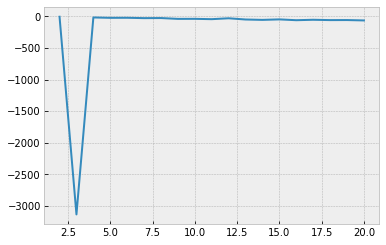

For Column :1
Evident Woe:-25.441144344298337


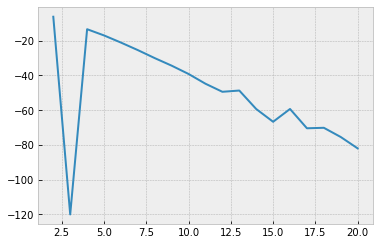

For Column :2
Evident Woe:-26.65114148905152


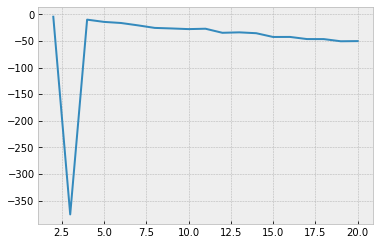

For Column :3
Evident Woe:0.0


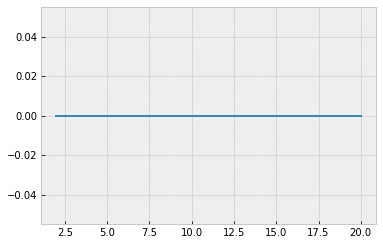

For Column :4
Evident Woe:-20.912954834720388


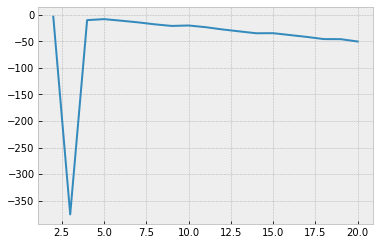

For Column :5
Evident Woe:-16.718243618013197


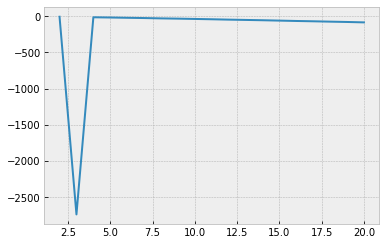

For Column :6
Evident Woe:-66.96484208791456


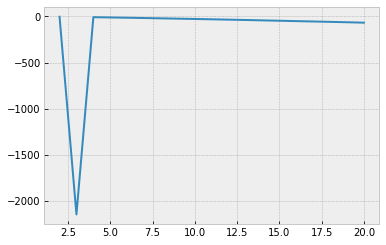

For Column :7
Evident Woe:-9.876300530587748


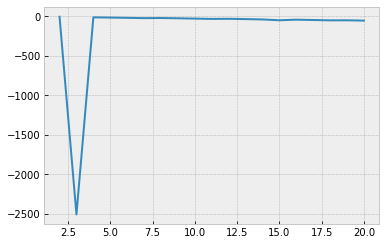

For Column :8
Evident Woe:2.220446049250313e-16


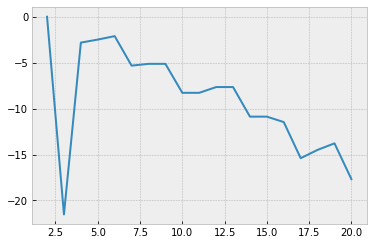

For Column :9
Evident Woe:-6.941997690090183


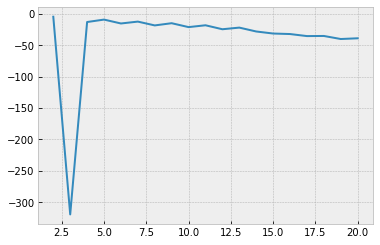

For Column :10
Evident Woe:-22.782151833866713


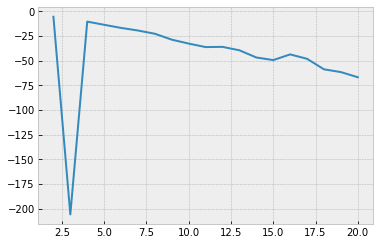

For Column :11
Evident Woe:-15.012436065880827


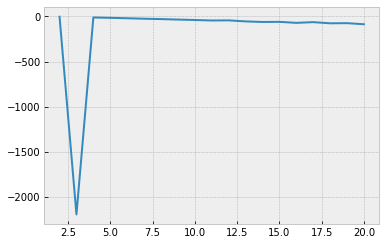

For Column :12
Evident Woe:-29.13384445243907


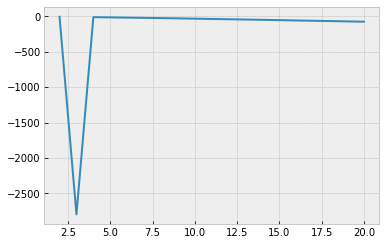

For Column :13
Evident Woe:-46.925741731710815


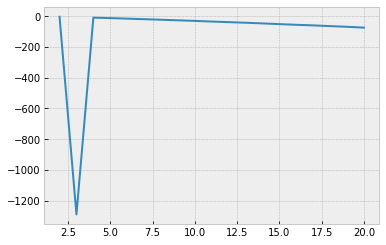

In [26]:

for i in range(df.shape[1]):
    woes = []
    ind = []
    for k in reversed(range(2,21)):
        woes.append(ef_num(df.iloc[:,i].values,bins=k,check_evidence=False))
        ind.append(k)
    print('For Column :{}'.format(i))
    # print(*zip(ind,woes))
    print('Evident Woe:{}'.format(ef_num(df.iloc[:,i].values,bins=20)))
    plt.plot(ind,woes)
    plt.show()

In [27]:
ef_num(df.iloc[:,12].values,bins=25,verbose=3)

Reducing bins to get proper evidences! Old Histogram:[16 33 47 47 40 51 30 39 36 27 31 26 14 13 10 12  3 10  3  9  3  0  4  0  2] 
 New bin size:23
Reducing bins to get proper evidences! Old Histogram:[17 43 46 54 46 42 38 40 34 33 30 15 13 11 10  9  6  7  5  1  4  0  2] 
 New bin size:22
Reducing bins to get proper evidences! Old Histogram:[19 43 54 53 48 41 42 43 31 36 20 18  8 15  6  8  7  7  1  3  1  2] 
 New bin size:21
Reducing bins to get proper evidences! Old Histogram:[19 48 58 50 56 39 43 40 35 34 16 13 18  6  8  6 10  1  3  1  2] 
 New bin size:20
Reducing bins to get proper evidences! Old Histogram:[22 53 55 53 60 39 46 38 36 28 19 11 12  9  6 10  3  1  3  2] 
 New bin size:19
Reducing bins to get proper evidences! Old Histogram:[25 56 61 51 57 49 48 33 42 16 14 19  7  9  7  6  1  3  2] 
 New bin size:18
Reducing bins to get proper evidences! Old Histogram:[27 59 66 61 51 49 46 40 31 20 13 12 10  7  7  1  4  2] 
 New bin size:17
Reducing bins to get proper evidences! Old Hi

-29.133844452439071

In [28]:
ef_num(df.iloc[:,1].values,check_evidence=False,bins=20,verbose=2)

Evident number of Bins: 20
Bins on data are:
 [   0.    5.   10.   15.   20.   25.   30.   35.   40.   45.   50.   55.
   60.   65.   70.   75.   80.   85.   90.   95.  100.] 
Respective Sizes:
 [372  10   2  35  13  13   3   7   6   3   3   4   3   3  17   2   5   4
   1]
Respective WOE:
 [1.0210540543222353, -3.903990833730882, -5.5294290875114234, -2.5995100325270042, -3.6355598165811536, -3.6355598165811536, -5.1219778814316292, -4.2666959466962053, -4.4228486291941369, -5.1219778814316292, -5.1219778814316292, -4.832305758571839, -5.1219778814316292, -5.1219778814316292, -3.3591491454186557, -5.5294290875114234, -4.6071681886507641, -4.832305758571839, -6.2245584292753602]
Net WOE: -81.96734588365776


-81.967345883657757

In [29]:
woes = [1.0210540543222353, -13.134291948269603, -3.903990833730882, -5.5294290875114234, -2.5995100325270042, 
        -3.6355598165811536, -3.6355598165811536, -5.1219778814316292, -4.2666959466962053, -4.4228486291941369, 
        -5.1219778814316292, -5.1219778814316292, -4.832305758571839, -13.134291948269603, -5.1219778814316292, 
        -5.1219778814316292, -3.3591491454186557, -5.5294290875114234, -4.6071681886507641, -4.6071681886507641]
np.mean(woes),np.sum(woes >= np.mean(woes)),np.std(woes),np.sum(woes)

(-5.0893116890500263, 11, 3.0302551212511553, -101.78623378100052)

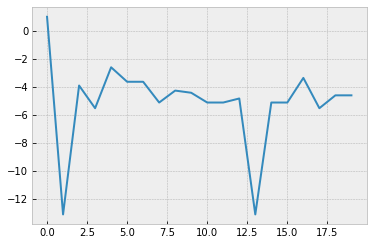

In [30]:
plt.plot(woes)
plt.show()

In [31]:
len([i for i in reversed(range(2,26))])

24

In [32]:

def plt_individual_woe(arr, bin_range=(1,30)):
    min_bin = bin_range[0]
    max_bin = bin_range[1]
    woes = []
    ind = []
    n_plt = len([i for i in range(min_bin,max_bin+1)])
    subplts = int(np.floor(np.sqrt(n_plt)))*int(np.ceil(np.sqrt(n_plt)))
    if subplts == n_plt:
        nr = int(np.floor(np.sqrt(n_plt)))
        nc = int(np.ceil(np.sqrt(n_plt)))
    else:
        nr = int(np.floor(np.sqrt(n_plt))) + 1
        nc = int(np.ceil(np.sqrt(n_plt)))
    plt.figure(figsize=(20,17))
    for k in reversed(range(min_bin,max_bin+1)):
        woe_, _, _, woe_arr = ef_num(arr, bins=k, check_evidence=False, return_array=True) 
        woes.append(woe_)
        ind.append(k)
        plt.subplot(nr, nc, max_bin+1-k)
        plt.subplots_adjust(wspace = 0.3,hspace=0.4)
        if k <15:
            plt.xticks(np.arange(0,k+1,1))
        elif k > 24 :
            plt.xticks(np.arange(0,k+1,3))
            plt.tick_params('x',labelsize=8.5)
        else:
            plt.xticks(np.arange(0,k+1,2))
        plt.plot(woe_arr,'-ro')
        plt.title('Plot {} Bins'.format(k))
    plt.suptitle("Individual WOE plots for each Bin size!",fontsize=16)
    plt.show()

ValueError: not enough values to unpack (expected 4, got 2)

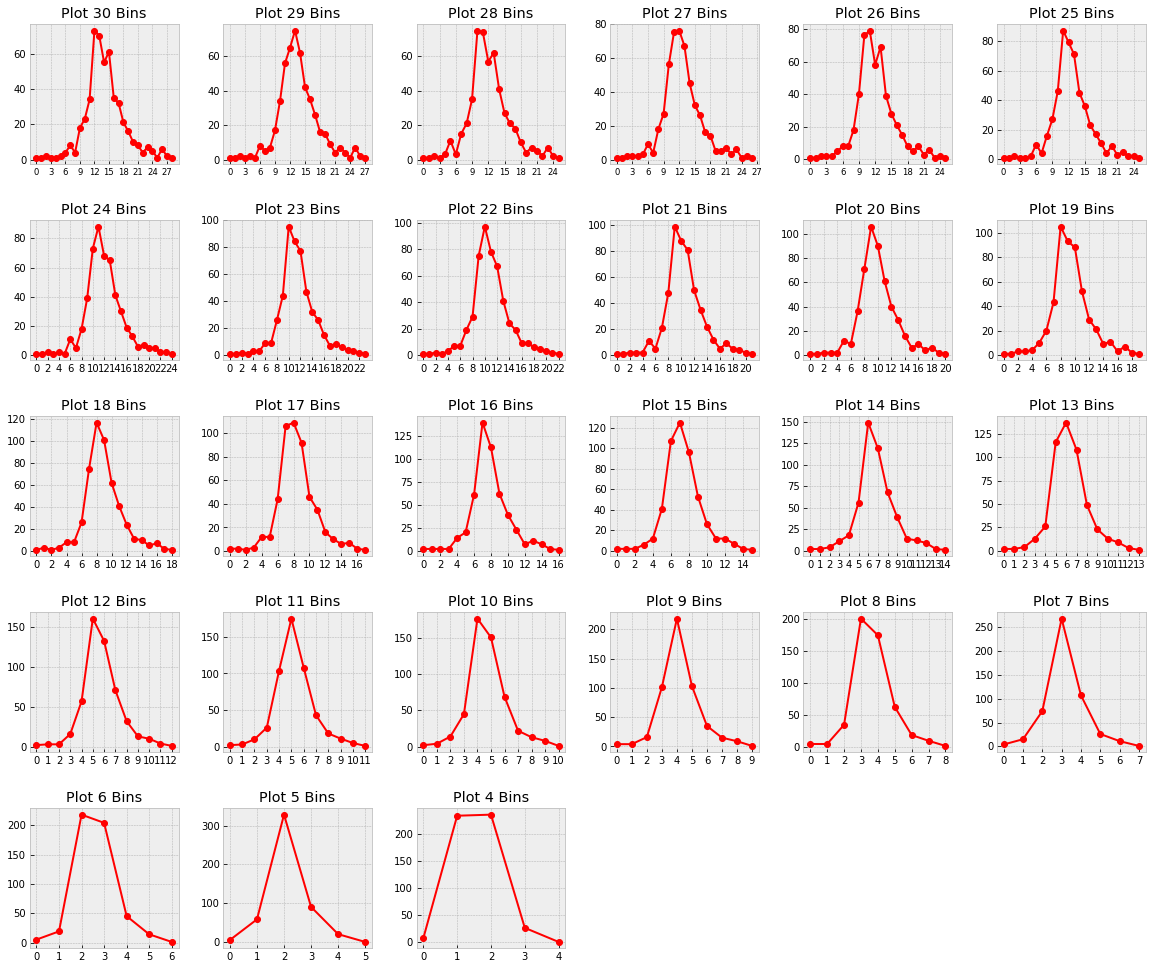

In [33]:
plt.style.use('bmh')
plt_individual_woe(df.iloc[:,5].values,bin_range=(1,30))

For Column :0
Evidence Factor:0.0


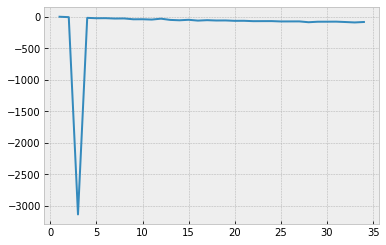

ValueError: not enough values to unpack (expected 4, got 2)

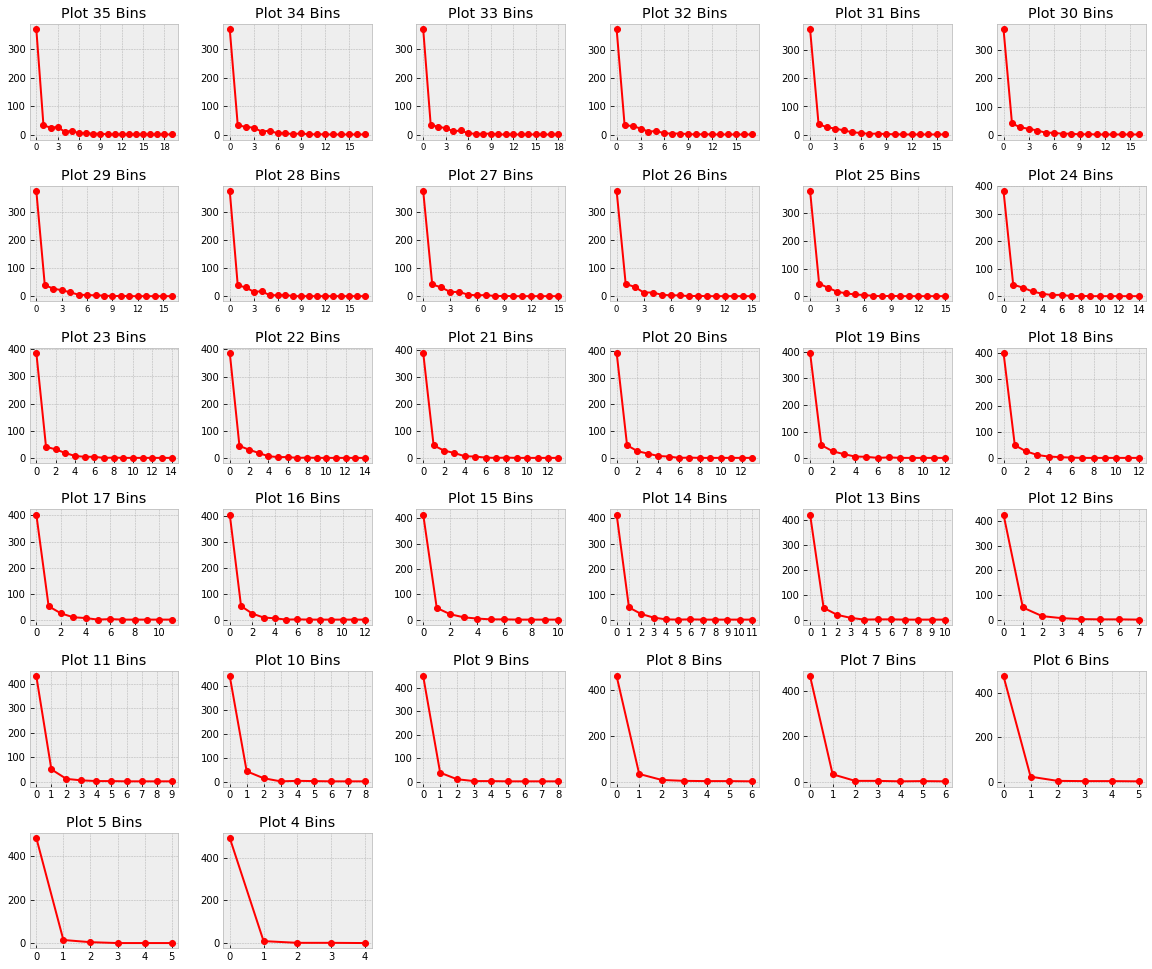

In [34]:

min_b = 1
max_b = 35
for i in range(df.shape[1]):
    woes = []
    ind = []
    for k in reversed(range(min_b, max_b)):
        woes.append(ef_num(df.iloc[:,i].values, bins=k, check_evidence=False))
        ind.append(k)
    print('For Column :{}'.format(i))
    # print(*zip(ind,woes))
    print('Evidence Factor:{}'.format(ef_num(df.iloc[:,i].values, bins=67)))
    plt.plot(ind, woes)
    plt.show()
    plt_individual_woe(df.iloc[:,i].values,bin_range=(min_b, max_b))

In [36]:
col_woe = []
for i in range(df.shape[1]-1):
    print('For Column :{}'.format(i))
    woe_ = ef_num(df.iloc[:,i].values,bins=20)
    print('Evident Woe:{}'.format(woe_))
    col_woe.append((i,woe_))



For Column :0
Evident Woe:0.0
For Column :1
Evident Woe:-25.441144344298337
For Column :2
Evident Woe:-26.65114148905152
For Column :3
Evident Woe:0.0
For Column :4
Evident Woe:-20.912954834720388
For Column :5
Evident Woe:-16.718243618013197
For Column :6
Evident Woe:-66.96484208791456
For Column :7
Evident Woe:-9.876300530587748
For Column :8
Evident Woe:2.220446049250313e-16
For Column :9
Evident Woe:-6.941997690090183
For Column :10
Evident Woe:-22.782151833866713
For Column :11
Evident Woe:-15.012436065880827
For Column :12
Evident Woe:-29.13384445243907


In [37]:
sorted(col_woe, key = lambda x: x[1], reverse=True)

[(8, 2.2204460492503131e-16),
 (0, 0.0),
 (3, 0.0),
 (9, -6.941997690090183),
 (7, -9.8763005305877485),
 (11, -15.012436065880827),
 (5, -16.718243618013197),
 (4, -20.912954834720388),
 (10, -22.782151833866713),
 (1, -25.441144344298337),
 (2, -26.651141489051518),
 (12, -29.133844452439071),
 (6, -66.964842087914562)]

In [39]:
def xtab(*cols, func=None, add_axis=None, apply_wt=False):
    '''
        param add_axis: 0 is row wise marginal , 1 is column wise marginal, (0,1) is both ways marginal
        returns:
        (i) xt, NumPy array storing the xtab results, number of dimensions is equal to 
            the len(args) passed in
        (ii) unique_vals_all_cols, a tuple of 1D NumPy array for each dimension 
            in xt (for a 2D xtab, the tuple comprises the row and column headers)
        pass in:
          (i) 1 or more 1D NumPy arrays of integers
          (ii) if wts is True, then the last array in cols is an array of weights

        if return_inverse=True, then np.unique also returns an integer index 
        (from 0, & of same len as array passed in) such that, uniq_vals[idx] gives the original array passed in
        higher dimensional cross tabulations are supported (eg, 2D & 3D)
        cross tabulation on two variables (columns):
        >>> q1 = NP.array([7, 8, 8, 8, 5, 6, 4, 6, 6, 8, 4, 6, 6, 6, 6, 8, 8, 5, 8, 6])
        >>> q2 = NP.array([6, 4, 6, 4, 8, 8, 4, 8, 7, 4, 4, 8, 8, 7, 5, 4, 8, 4, 4, 4])
        >>> uv, xt = xtab(q1, q2)
        >>> uv
        (array([4, 5, 6, 7, 8]), array([4, 5, 6, 7, 8]))
        >>> xt
        array([[2, 0, 0, 0, 0],
               [1, 0, 0, 0, 1],
               [1, 1, 0, 2, 4],
               [0, 0, 1, 0, 0],
               [5, 0, 1, 0, 1]], dtype=uint64)
    '''
    if not all(len(col) == len(cols[0]) for col in cols[1:]):
        raise ValueError("all arguments must be same size")

    if len(cols) == 0:
        raise TypeError("xtab() requires at least one argument")
    
    fnx1 = lambda q: len(q.squeeze().shape)
    if not all([fnx1(col) == 1 for col in cols]):
        raise ValueError("all input arrays must be 1D")

    if apply_wt:
        cols, wt = cols[:-1], cols[-1]
    else:
        wt = 1

    uniq_vals_all_cols, idx = zip( *(np.unique(col, return_inverse=True) for col in cols) )
    shape_xt = [uniq_vals_col.size for uniq_vals_col in uniq_vals_all_cols]
    dtype_xt = 'float' if apply_wt else 'uint'
    xt = np.zeros(shape_xt, dtype=dtype_xt)
    np.add.at(xt, idx, wt)
    
    if add_axis is not None:
        if add_axis == 0:
            xt = np.vstack((xt,np.einsum('ij->j',xt)))
        elif add_axis == 1:
            xt = np.hstack((xt,np.einsum('ij->i',xt).reshape(-1,1)))
        elif add_axis == (0,1):
            xt = np.vstack((xt,np.einsum('ij->j',xt)))
            xt = np.hstack((xt,np.einsum('ij->i',xt).reshape(-1,1)))
        else: 
            raise ValueError("add_axis should be 0 or 1 or (0,1)")
            
    return uniq_vals_all_cols, xt

In [40]:
q1 = np.array([7, 8, 8, 8, 5, 6, 4, 6, 6, 8, 4, 6, 6, 6, 6, 8, 8, 5, 8, 6])
q2 = np.array([6, 4, 6, 4, 8, 8, 4, 8, 7, 4, 4, 8, 8, 7, 5, 4, 8, 4, 4, 4])
uv, xt = xtab(q1, q2,add_axis=(0,1))
xt

array([[ 2,  0,  0,  0,  0,  2],
       [ 1,  0,  0,  0,  1,  2],
       [ 1,  1,  0,  2,  4,  8],
       [ 0,  0,  1,  0,  0,  1],
       [ 5,  0,  1,  0,  1,  7],
       [ 9,  1,  2,  2,  6, 20]], dtype=uint64)

In [41]:
def bin_skill(x, y, xt=None, modified=False, keep_orig=True, verbose = 0):
    
    #if xtab is not available
    if xt is None:
        _,xt = xtab(x, y,add_axis=(0,1))
    
    if verbose > 0:
        print('Crosstab Matrix:\n{}'.format(xt))
    
    #getting basic values
    m,n = xt.shape
    m = m-1
    n = n-1
    pi = np.pi
    pi2 = pi/2
    pi4 = np.pi/4
    
    # setting iter variables
    corr_tetr = np.zeros((m,n))
    corr_pirc = np.zeros((m,n))
    corr_heid = np.zeros((m,n))
    corr_dool = np.zeros((m,n))
    corr_yule = np.zeros((m,n))
    if modified and keep_orig:
        corr_pirc_orig = np.zeros((m,n))
        corr_heid_orig = np.zeros((m,n))
        corr_dool_orig = np.zeros((m,n))

    counter = 0
    for i in range(m):
        for j in range(n):
            # getiing proportions
            val = xt[i,j]
            A = val / xt[m,n]
            B = (xt[i,n]-val) / xt[m,n]
            C = (xt[m,j]-val) / xt[m,n]
            D = (xt[m,n]-xt[i,n]-xt[m,j]+val)/xt[m,n]
            
            # getting probabilities
            p_c_f = xt[i,n] / xt[m,n]
            p_r_o = xt[m,j] / xt[m,n]
            
            mat = [[A,B],[C,D]]
            
            # using stat formula for tetrachoric correlation
            alpha = np.power((1e-7 if A*D == 0 else A*D)/(1e-7 if B*C == 0 else B*C),pi4)
            corr_t = (alpha - 1)/(alpha + 1)

            # cosine formula fot tetrachoric corelation.. need to validate this
            corr2 = np.cos(pi2/(np.sqrt(((A*D)/(1e-5 if B*C == 0 else B*C)))+1))

            # Pierce Measure
            corr_p = (A - (p_r_o*p_c_f)) / (p_r_o*(1-p_r_o))
        
            # Heidke Measure
            corr_h = 2*(A - (p_r_o*p_c_f)) / (p_r_o + p_c_f - 2*p_r_o*p_c_f)

            # Square root of Doolittle Measure
            corr_d = (A - (p_r_o*p_c_f)) / np.sqrt(p_r_o*(1-p_r_o)*p_c_f*(1-p_c_f))

            # Yule's skill score
            corr_y = (A - (p_r_o*p_c_f)) / (A*(1- 2*(p_r_o + p_c_f) + 2*A) + p_r_o*p_c_f)
            
            if modified and keep_orig:
                corr_p_m = np.sin(pi2*corr_p)
                corr_h_m = np.sin(pi2*corr_h)
                corr_d_m = np.sin(pi2*corr_d)
                corr_pirc[i,j] = corr_p_m
                corr_heid[i,j] = corr_h_m
                corr_dool[i,j] = corr_d_m
                corr_pirc_orig[i,j] = corr_p
                corr_heid_orig[i,j] = corr_h
                corr_dool_orig[i,j] = corr_d
            elif modified:
                corr_p_m = np.sin(pi2*corr_p)
                corr_h_m = np.sin(pi2*corr_h)
                corr_d_m = np.sin(pi2*corr_d)
                corr_pirc[i,j] = corr_p_m
                corr_heid[i,j] = corr_h_m
                corr_dool[i,j] = corr_d_m
            else:
                corr_pirc[i,j] = corr_p
                corr_heid[i,j] = corr_h
                corr_dool[i,j] = corr_d

            # fitting values in correlation matrix                
            corr_tetr[i,j] = corr_t
            corr_yule[i,j] = corr_y
            
            if verbose > 3:
                print('Iteration for i:{} j:{} val:{} sum:{} alpha:{} corr_t:{} corr_cos:{} corr_p:{} corr_h:{} corr_d:{} corr_y:{} '.format(
                    i, j, val, np.sum(mat), alpha, corr_t, corr2, corr_p, corr_h, corr_d, corr_y ))
                print('Proportion Matrix:\n{}'.format(np.array(mat)))
            
            if m == n == 2:
                break
            counter += 1
        if m == n == 2:
            break
            
    if m == n == 2:
        counter = 1
            
    if keep_orig:
        if verbose > 2:
            print('Correlation Matrices: \n corr_tetr:\n {} \n corr_yule:\n {} \n corr_pirc:\n {} \n corr_heid:\n {} \n corr_dool:\n {} \n corr_pirc_orig:\n'
            ' {} \n corr_heid_orig:\n {} \n corr_dool_orig:\n {}'.format(
                corr_tetr, corr_yule, corr_pirc, corr_heid, corr_dool, corr_pirc_orig, corr_heid_orig, corr_dool_orig))
        if verbose > 1:
            print('\nNet Correlation: \ncorr_tetr:{} corr_yule:{}, corr_pirc:{} corr_heid:{} corr_dool:{} corr_pirc_orig:{} corr_heid_orig:{} corr_dool_orig:{} '.format(
                np.sum(np.abs(corr_tetr))/counter, np.sum(corr_yule)/counter, np.sum(corr_pirc)/counter, np.sum(corr_heid)/counter, np.sum(corr_dool)/counter,
                np.sum(corr_pirc_orig)/counter,np.sum(corr_heid_orig)/counter,np.sum(corr_dool_orig)/counter,))
        if modified:
            return corr_tetr, corr_yule, corr_pirc, corr_heid, corr_dool, corr_pirc_orig, corr_heid_orig, corr_dool_orig
        else:
            pass
    else:
        if verbose > 2:
            print('Correlation Matrices: \n corr_tetr:\n {} \n corr_pirc:\n {} \n corr_heid:\n {} \n corr_dool:\n {} \n corr_yule:\n {} '.format(
                corr_tetr, corr_pirc, corr_heid, corr_dool, corr_yule))
        if verbose > 1:
            print('\nNet Correlation: \ncorr_tetr:{} corr_pirc:{} corr_heid:{} corr_dool:{} corr_yule:{}'.format(
                np.sum(corr_tetr)/counter,np.sum(corr_pirc)/counter,np.sum(corr_heid)/counter,np.sum(corr_dool)/counter,np.sum(corr_yule)/counter))
        return corr_tetr, corr_yule, corr_pirc, corr_heid, corr_dool 

In [42]:
test_xt = np.array([[40,10,50],[20,30,50],[60,40,100]])
print(test_xt)
bin_skill(q1,q2,xt = test_xt,modified=True)

[[ 40  10  50]
 [ 20  30  50]
 [ 60  40 100]]


(array([[ 0.60666196,  0.        ],
        [ 0.        ,  0.        ]]), array([[ 0.71428571,  0.        ],
        [ 0.        ,  0.        ]]), array([[ 0.60876143,  0.        ],
        [ 0.        ,  0.        ]]), array([[ 0.58778525,  0.        ],
        [ 0.        ,  0.        ]]), array([[ 0.59821756,  0.        ],
        [ 0.        ,  0.        ]]), array([[ 0.41666667,  0.        ],
        [ 0.        ,  0.        ]]), array([[ 0.4,  0. ],
        [ 0. ,  0. ]]), array([[ 0.40824829,  0.        ],
        [ 0.        ,  0.        ]]))

In [43]:
test_xt = np.array([[58,52,1,111],[26,58,3,87],[8,12,9,29],[92,122,13,227]])
print(test_xt)
bin_skill(q1,q2, xt = test_xt, modified=True)

[[ 58  52   1 111]
 [ 26  58   3  87]
 [  8  12   9  29]
 [ 92 122  13 227]]


(array([[ 0.36367827, -0.21124262, -0.7606884 ],
        [-0.28209434,  0.32719499, -0.2925022 ],
        [-0.25341919, -0.22071537,  0.83689333]]),
 array([[ 0.45044221, -0.26648267, -0.85393258],
        [-0.35327731,  0.40740741, -0.36585366],
        [-0.31838565, -0.27819549,  0.91237678]]),
 array([[ 0.36497099, -0.21150857, -0.63390213],
        [-0.26272615,  0.30785055, -0.25135776],
        [-0.1075467 , -0.09964919,  0.80795366]]),
 array([[ 0.35386941, -0.20999898, -0.15064655],
        [-0.264965  ,  0.30108516, -0.06911584],
        [-0.1206505 , -0.0938749 ,  0.56143214]]),
 array([[ 0.35874823, -0.21097401, -0.31375231],
        [-0.2652401 ,  0.31544362, -0.12113296],
        [-0.15781478, -0.14853476,  0.60897198]]),
 array([[ 0.23784219, -0.13567525, -0.43709561],
        [-0.16924316,  0.19921936, -0.16175413],
        [-0.06859903, -0.06354411,  0.59884975]]),
 array([[ 0.23026854, -0.13469214, -0.09627108],
        [-0.17072081,  0.19469769, -0.04403562],
        

In [44]:
print(xt)
bin_skill(q1,q2,modified=True, verbose=False)

[[ 2  0  0  0  0  2]
 [ 1  0  0  0  1  2]
 [ 1  1  0  2  4  8]
 [ 0  0  1  0  0  1]
 [ 5  0  1  0  1  7]
 [ 9  1  2  2  6 20]]


(array([[ 0.99993798, -0.99959226, -0.99976341, -0.99976341, -0.99990016],
        [ 0.08740466, -0.99959226, -0.99976341, -0.99976341,  0.35855651],
        [-0.77644476,  0.99990016, -0.99992035,  0.99994207,  0.55944487],
        [-0.99987486, -0.99929734,  0.99992739, -0.99959226, -0.99982793],
        [ 0.59039883, -0.99984755,  0.26566913, -0.99991155, -0.47696825]]),
 array([[ 1.        , -1.        , -1.        , -1.        , -1.        ],
        [ 0.11111111, -1.        , -1.        , -1.        ,  0.44444444],
        [-0.86666667,  1.        , -1.        ,  1.        ,  0.66666667],
        [-1.        , -1.        ,  1.        , -1.        , -1.        ],
        [ 0.69811321, -1.        ,  0.33333333, -1.        , -0.57894737]]),
 array([[ 0.34202014, -0.16459459, -0.17364818, -0.17364818, -0.22252093],
        [ 0.03172793, -0.16459459, -0.17364818, -0.17364818,  0.14904227],
        [-0.73459171,  0.83716648, -0.64278761,  0.8660254 ,  0.56332006],
        [-0.14231484,

In [45]:
efs1 = ef_num(df.iloc[:,2].values,bins='scott',return_array=True,verbose=4)
efs2 = ef_num(df.iloc[:,4].values,bins='rice',return_array=True,verbose=4)
efs1[0].shape,efs2[0].shape,efs1[3].shape,efs2[3].shape,np.unique(efs1[1]).shape,np.unique(efs2[2]).shape,np.unique(efs1[1]),np.unique(efs2[2])

Before checking histogram:
Hist: [ 56  95  99  44  20   3 132  45   0  12] 
Unique splits: [  0.46    3.188   5.916   8.644  11.372  14.1    16.828  19.556  22.284
  25.012  27.74 ]
After checking histogram:
Hist: [ 56  95  99  44  20   3 132  45  12] 
Unique splits: [  0.46    3.188   5.916   8.644  11.372  14.1    16.828  19.556  25.012
  27.74 ]
Evident number of Bins: 9
Bins on data are:
 [  0.46    3.188   5.916   8.644  11.372  14.1    16.828  19.556  25.012
  27.74 ] 
Respective Sizes:
 [ 56  95  99  44  20   3 132  45   7   5]
Respective WOE:
 [-2.0838958920292163, -1.4647163228956939, -1.413693335308005, -2.3513752571634776, -3.1904763503465028, -5.1219778814316292, -1.041453874828161, -2.326735553226329, -4.2666959466962053, -4.6071681886507641]
Net WOE: -27.868188602575984
Before checking histogram:
Hist: [43 68 44 45 49 48 44 41 18 20 49 13  8  0  0 16] 
Unique splits: [ 0.385     0.415375  0.44575   0.476125  0.5065    0.536875  0.56725
  0.597625  0.628     0.658375  0.68

((10,),
 (14,),
 (10,),
 (14,),
 (10,),
 (15,),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 array([ 0.385   ,  0.415375,  0.44575 ,  0.476125,  0.5065  ,  0.536875,
         0.56725 ,  0.597625,  0.628   ,  0.658375,  0.68875 ,  0.719125,
         0.7495  ,  0.840625,  0.871   ]))

In [46]:
efs1[0].shape,efs2[0].shape,efs1[3].shape,efs2[3].shape,np.unique(efs1[1]).shape,np.unique(efs2[2]).shape,np.unique(efs1[1]),np.unique(efs2[2])

((10,),
 (14,),
 (10,),
 (14,),
 (10,),
 (15,),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 array([ 0.385   ,  0.415375,  0.44575 ,  0.476125,  0.5065  ,  0.536875,
         0.56725 ,  0.597625,  0.628   ,  0.658375,  0.68875 ,  0.719125,
         0.7495  ,  0.840625,  0.871   ]))

In [47]:
efs1 = ef_num(df.iloc[:,2].values,bins='fd',return_array=True,verbose=3)
efs2 = ef_num(df.iloc[:,4].values,bins='fd',return_array=True,verbose=3)
print(efs1[0].shape,efs2[0].shape,efs1[2].shape,efs2[2].shape,np.unique(efs1[1]).shape,np.unique(efs2[1]).shape,np.unique(efs1[1]),np.unique(efs2[1]))
print(xtab(efs1[1],efs2[1],add_axis=(0,1))[1])
xtab(efs1[1],efs2[1])[1].shape

Before checking histogram:
Hist: [ 75 111  64  49  18 132  30  15  12] 
Unique splits: [  0.46         3.49111111   6.52222222   9.55333333  12.58444444
  15.61555556  18.64666667  21.67777778  24.70888889  27.74      ]
After checking histogram:
Hist: [ 75 111  64  49  18 132  30  15  12] 
Unique splits: [  0.46         3.49111111   6.52222222   9.55333333  12.58444444
  15.61555556  18.64666667  21.67777778  24.70888889  27.74      ]
Evident number of Bins: 9
Bins on data are:
 [  0.46         3.49111111   6.52222222   9.55333333  12.58444444
  15.61555556  18.64666667  21.67777778  24.70888889  27.74      ] 
Respective Sizes:
 [ 75 111  64  49  18 132  30  15   7   5]
Respective WOE:
 [-1.7486199765674373, -1.2693555635887876, -1.9324267987180261, -2.2328630927835782, -3.2999436479569826, -1.041453874828161, -2.7642204725692645, -3.4883939266923107, -4.2666959466962053, -4.6071681886507641]
Net WOE: -26.65114148905152
Before checking histogram:
Hist: [ 47 102  51  84  51  47  23  40 

(10, 11)

In [48]:
efs_skill  = bin_skill(efs1[1],efs2[1], modified=True, verbose=1)
efs_skill[0].shape

Crosstab Matrix:
[[ 30  27  16   2   0   0   0   0   0   0   0  75]
 [ 13  47  14  25   2   0  10   0   0   0   0 111]
 [  0  14  10  40   0   0   0   0   0   0   0  64]
 [  4   0  11  12  22   0   0   0   0   0   0  49]
 [  0  14   0   0   4   0   0   0   0   0   0  18]
 [  0   0   0   5  16  13  13  40  37   8   0 132]
 [  0   0   0   0   0  14   0   0   0   0  16  30]
 [  0   0   0   0   0  15   0   0   0   0   0  15]
 [  0   0   0   0   7   0   0   0   0   0   0   7]
 [  0   0   0   0   0   5   0   0   0   0   0   5]
 [ 47 102  51  84  51  47  23  40  37   8  16 506]]


(10, 11)

In [49]:
np.sum(efs_skill[0]*efs1[0].reshape(-1,1),axis=1).shape

(10,)

In [50]:
np.sum(efs_skill[0].T*efs2[0].reshape(-1,1),axis=1).shape

(11,)

In [51]:
np.sum(efs_skill[0]*efs1[0].reshape(-1,1),axis=1)

array([ 10.67635387,   5.42696827,  13.39879932,  12.69388974,
        25.8302548 ,   1.03532043,  20.03488242,  31.36299771,
        38.32756217,  41.36273848])

In [52]:
np.sum(efs_skill[0].T*efs2[0].reshape(-1,1),axis=1)

array([ 13.95645976,   5.85673725,  10.5353294 ,   8.27425155,
         7.50425979,   7.32793974,  21.61709178,  19.62836476,
        20.30199073,  32.96549883,  27.33624445])

In [95]:
def evaluate_pair(df, pair, bins=('fd','fd'), skill='tetra', modified_skill=False, verbose=0):
    
    if len(pair) != 2:
        raise ValueError('Pair can take only two values!')
    
    a_1, a_2 = pair
    
    if len(bins) != 2:
        raise Warning('Two values are not supplied! Applying same bins to both varaibles.')
        b_1 = b_2 = bins
    else:
        b_1, b_2 = bins
    
    # Calculating evidence factor
    if isinstance(df, pd.DataFrame):
        arr_1 = df.iloc[:,a_1].values
        arr_2 = df.iloc[:,a_2].values
    elif isinstance(df, np.ndarray):
        arr_1 = df[:,a_1]
        arr_2 = df[:,a_2]
        
    if arr_1.dtype in [np.number]:
        efs1 = ef_num(arr_1, bins=b_1, return_array=True, verbose=verbose)
    else:
        efs1 = ef_cat(arr_1, return_array=True, verbose=verbose)

    if len(efs1[2]) == 1:
        warnings.warn('Single bin conditon observed!')
        efs1 = ef_cat(arr_1, return_array=True, verbose=verbose)

    if arr_2.dtype in [np.number]:
        efs2 = ef_num(arr_2, bins=b_2, return_array=True, verbose=verbose)
    else:
        efs2 = ef_cat(arr_2, return_array=True, verbose=verbose)   
    
    if len(efs2[2]) == 1:
        warnings.warn('Single bin conditon observed!')
        efs2 = ef_cat(arr_2, return_array=True, verbose=verbose)

    # calculating skill score / correlation
    # if bin size is zero then variable sarts behaving as binary hence 
    efs_skill  = bin_skill(efs1[1], efs2[1], modified=modified_skill, keep_orig=False, verbose=verbose)
    
    skill_mat = None
    if skill == 'tetra':
        skill_mat = efs_skill[0]
    elif skill == 'yule':
        skill_mat = efs_skill[1]
    elif skill == 'pierce':
        skill_mat = efs_skill[2]
    elif skill == 'heidke':
        skill_mat = efs_skill[3]
    elif skill == 'doolittle':
        skill_mat = efs_skill[4]
    else:
        skill_mat = efs_skill[0]

    if verbose > 0:
        print('Net \'{}\' Skill Score: {}'.format(skill,np.mean(skill_mat)))

    if verbose > 1:
        print('Skill Matrix:\n{}'.format(skill_mat))
    
    skill_1 = np.sum(skill_mat*efs1[0].reshape(-1,1),axis=1)
    skill_2 = np.sum(skill_mat.T*efs2[0].reshape(-1,1),axis=1)
    
    # storing scores
    score_1 = (efs1[0],skill_1,efs1[2],efs1[3])
    score_2 = (efs2[0],skill_2,efs2[2],efs2[3])
    
    return score_1, score_2

In [54]:
evaluate_pair(df, pair=(2,4), bins=(9,'scott'), skill='tetra', verbose=2)

Evident number of Bins: 8
Bins on data are:
 [  0.46         3.49111111   6.52222222   9.55333333  12.58444444
  15.61555556  18.64666667  21.67777778  24.70888889  27.74      ] 
Respective Sizes:
 [ 75 111  64  49  18 132  30  15   7   5]
Respective WOE:
 [-1.7486199765674373, -1.2693555635887876, -1.9324267987180261, -2.2328630927835782, -3.2999436479569826, -1.041453874828161, -2.7642204725692645, -3.4883939266923107, -4.2666959466962053, -4.6071681886507641]
Net WOE: -26.65114148905152
Evident number of Bins: 9
Bins on data are:
 [ 0.385   0.4336  0.4822  0.5308  0.5794  0.628   0.6766  0.7252  0.8224
  0.871 ] 
Respective Sizes:
 [75 80 89 60 78 30 57 21 16]
Respective WOE:
 [-1.7486199765674373, -1.6724127115954888, -1.5444498520666616, -2.0059743897979634, -1.7024143688922051, -2.7642204725692645, -2.0639716199077043, -3.1396264532140603, -3.4218166688648908]
Net WOE: -20.063506513475676
Crosstab Matrix:
[[ 34  27  13   1   0   0   0   0   0  75]
 [ 37  23  39   2   0  10   0   

((array([-1.74861998, -1.26935556, -1.9324268 , -2.23286309, -3.29994365,
         -1.04145387, -2.76422047, -3.48839393, -4.26669595, -4.60716819]),
  array([  8.02078023,   4.16119694,   8.9778395 ,   9.68200143,
          19.31999887,   1.72430264,  14.945369  ,  24.39807992,
          29.82087212,  32.18550069]),
  array([  0.46      ,   3.49111111,   6.52222222,   9.55333333,
          12.58444444,  15.61555556,  18.64666667,  21.67777778,
          24.70888889,  27.74      ]),
  array([ 75, 111,  64,  49,  18, 132,  30,  15,   7,   5])),
 (array([-1.74861998, -1.67241271, -1.54444985, -2.00597439, -1.70241437,
         -2.76422047, -2.06397162, -3.13962645, -3.42181667]),
  array([ 10.60063952,   7.07428199,   7.55486874,   8.64010942,
           0.23644051,  19.70475531,  16.50280701,  25.08714744,  27.33624445]),
  array([ 0.385 ,  0.4336,  0.4822,  0.5308,  0.5794,  0.628 ,  0.6766,
          0.7252,  0.8224,  0.871 ]),
  array([75, 80, 89, 60, 78, 30, 57, 21, 16])))

In [55]:
df.shape

(506, 14)

In [56]:
counters = 0
cols = [i for i in range(0,13)]
skill_eval = [[] for _ in cols]
print(len(skill_eval))
for i in itertools.combinations(cols, 2):
    print(i)
    eval_p = evaluate_pair(df,pair=i)
    for k,val in enumerate(i):
        skill_eval[val].append(eval_p[k])
        print('Added evaluation for {}'.format(val))
   
    counters+=1
    
print(counters)

13
(0, 1)
Added evaluation for 0
Added evaluation for 1
(0, 2)
Added evaluation for 0
Added evaluation for 2
(0, 3)
Added evaluation for 0
Added evaluation for 3
(0, 4)
Added evaluation for 0
Added evaluation for 4
(0, 5)
Added evaluation for 0
Added evaluation for 5
(0, 6)
Added evaluation for 0
Added evaluation for 6
(0, 7)
Added evaluation for 0
Added evaluation for 7
(0, 8)
Added evaluation for 0
Added evaluation for 8
(0, 9)
Added evaluation for 0
Added evaluation for 9
(0, 10)
Added evaluation for 0
Added evaluation for 10
(0, 11)
Added evaluation for 0
Added evaluation for 11
(0, 12)
Added evaluation for 0
Added evaluation for 12
(1, 2)
Added evaluation for 1
Added evaluation for 2
(1, 3)
Added evaluation for 1
Added evaluation for 3
(1, 4)
Added evaluation for 1
Added evaluation for 4
(1, 5)
Added evaluation for 1
Added evaluation for 5
(1, 6)
Added evaluation for 1
Added evaluation for 6
(1, 7)
Added evaluation for 1
Added evaluation for 7
(1, 8)
Added evaluation for 1
Added e

/Users/jitins_lab/anaconda2/envs/hyper/lib/python3.6/site-packages/ipykernel/__main__.py:37: RuntimeWarning: overflow encountered in ulong_scalars


Added evaluation for 1
Added evaluation for 12
(2, 3)
Added evaluation for 2
Added evaluation for 3
(2, 4)
Added evaluation for 2
Added evaluation for 4
(2, 5)
Added evaluation for 2
Added evaluation for 5
(2, 6)
Added evaluation for 2
Added evaluation for 6
(2, 7)
Added evaluation for 2
Added evaluation for 7
(2, 8)
Added evaluation for 2
Added evaluation for 8
(2, 9)
Added evaluation for 2
Added evaluation for 9
(2, 10)
Added evaluation for 2
Added evaluation for 10
(2, 11)
Added evaluation for 2
Added evaluation for 11
(2, 12)
Added evaluation for 2
Added evaluation for 12
(3, 4)
Added evaluation for 3
Added evaluation for 4
(3, 5)
Added evaluation for 3
Added evaluation for 5
(3, 6)
Added evaluation for 3
Added evaluation for 6
(3, 7)
Added evaluation for 3
Added evaluation for 7
(3, 8)
Added evaluation for 3
Added evaluation for 8
(3, 9)
Added evaluation for 3
Added evaluation for 9
(3, 10)
Added evaluation for 3
Added evaluation for 10
(3, 11)
Added evaluation for 3
Added evaluat

In [57]:
# skill_eval

In [58]:
for i in map(lambda x: len(x),skill_eval):
    print(i)

12
12
12
12
12
12
12
12
12
12
12
12
12


In [59]:
print(i[1][np.argsort(i[1])])
print(i[0][np.argsort(i[1])])
print(i[3][np.argsort(i[1])])
print(i[2][np.argsort(i[1])])

TypeError: 'int' object is not subscriptable

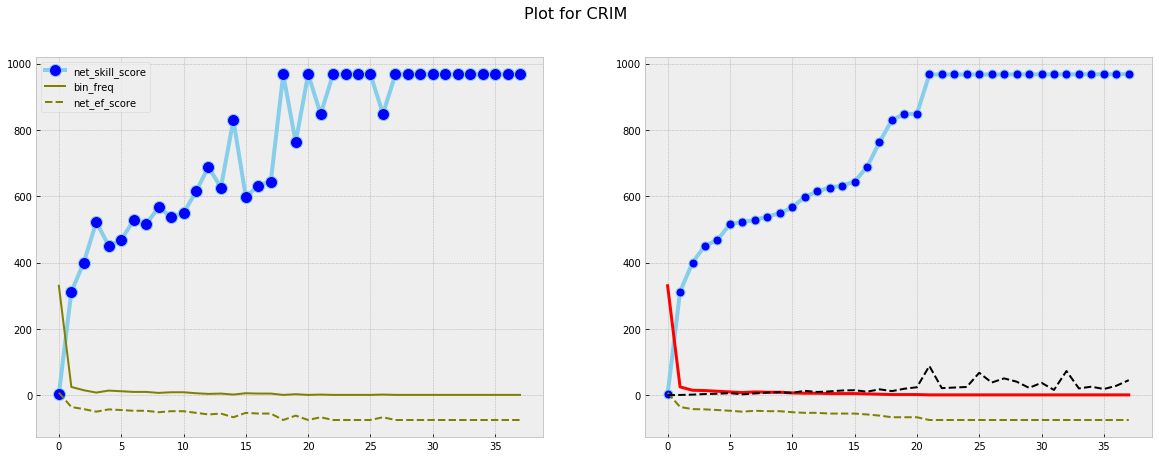

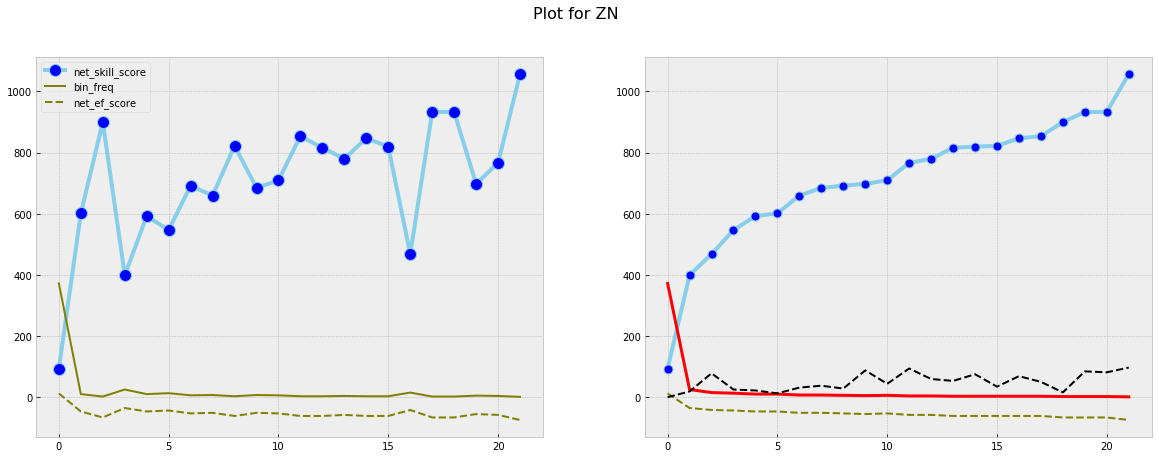

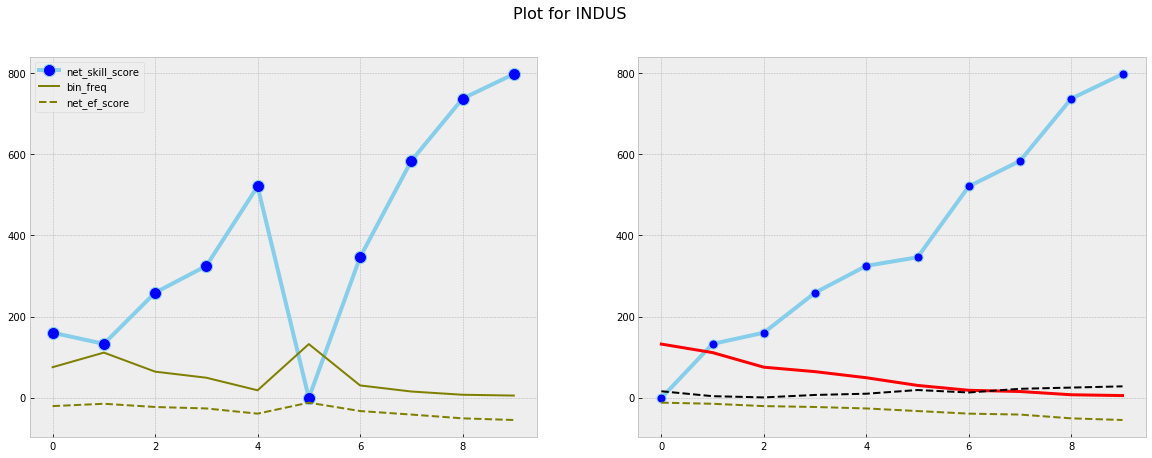

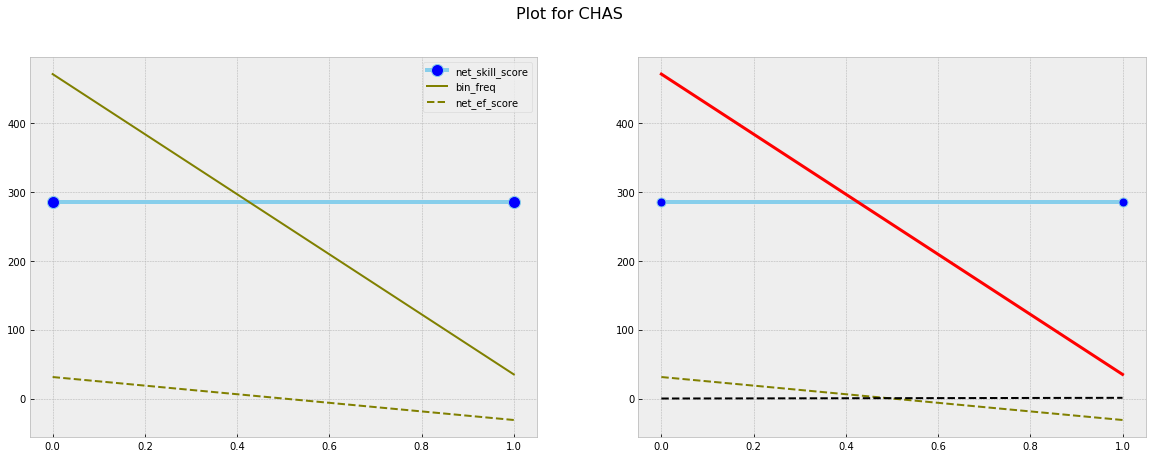

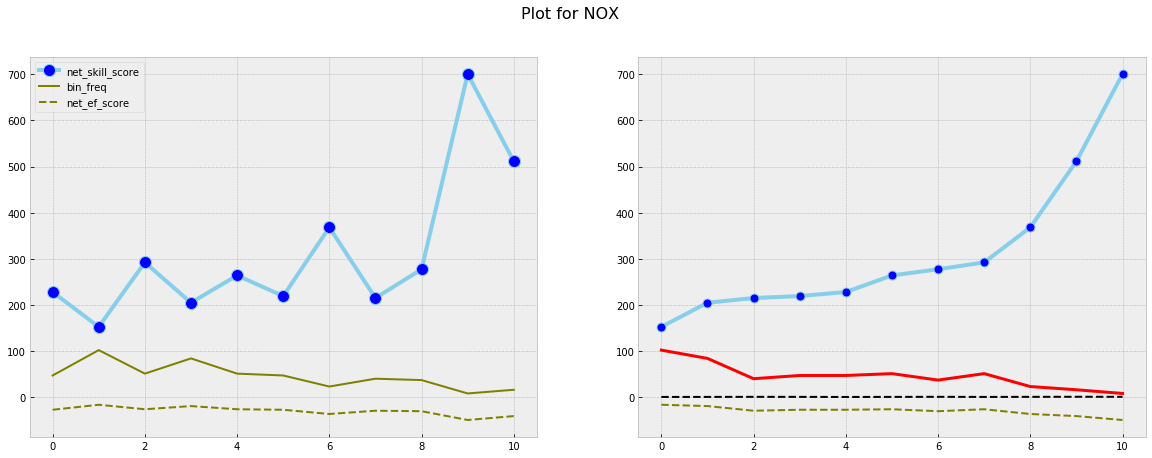

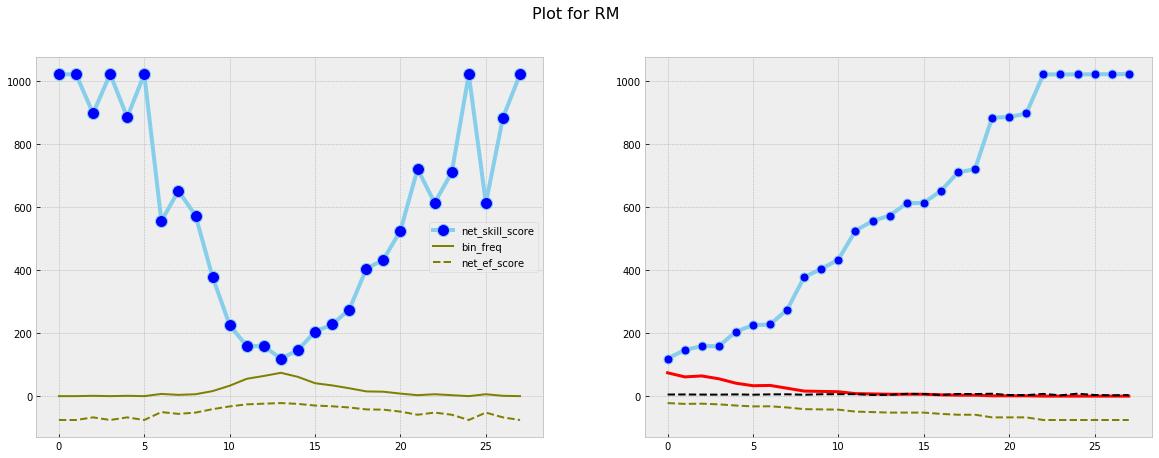

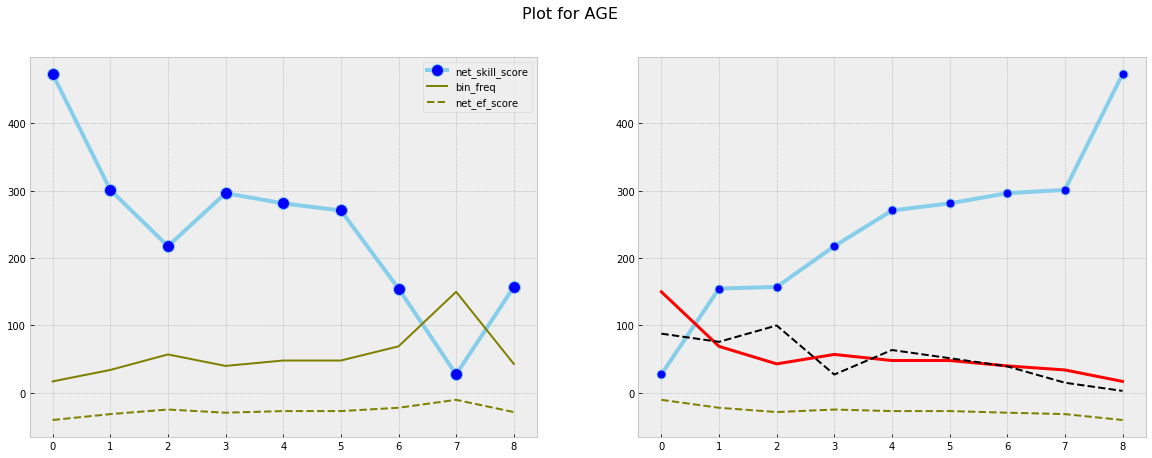

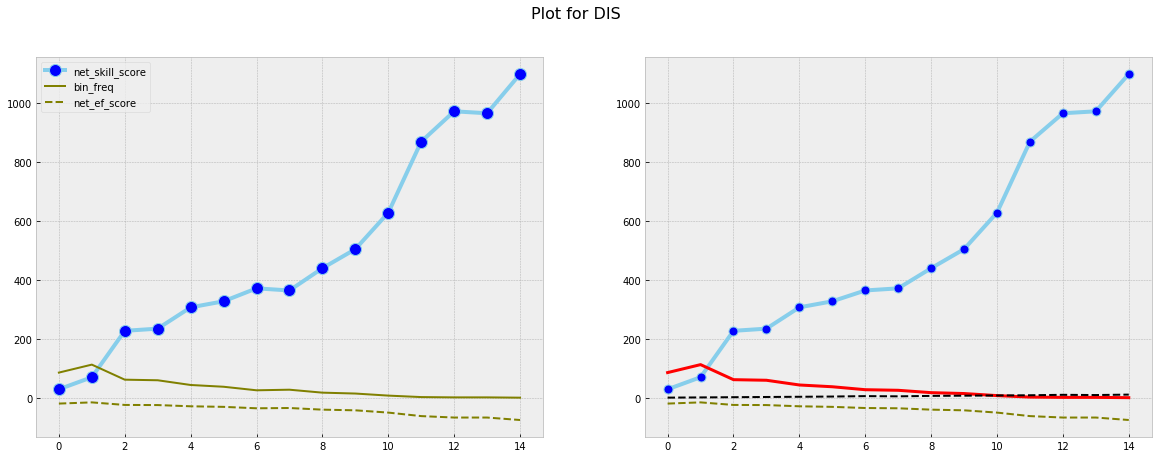

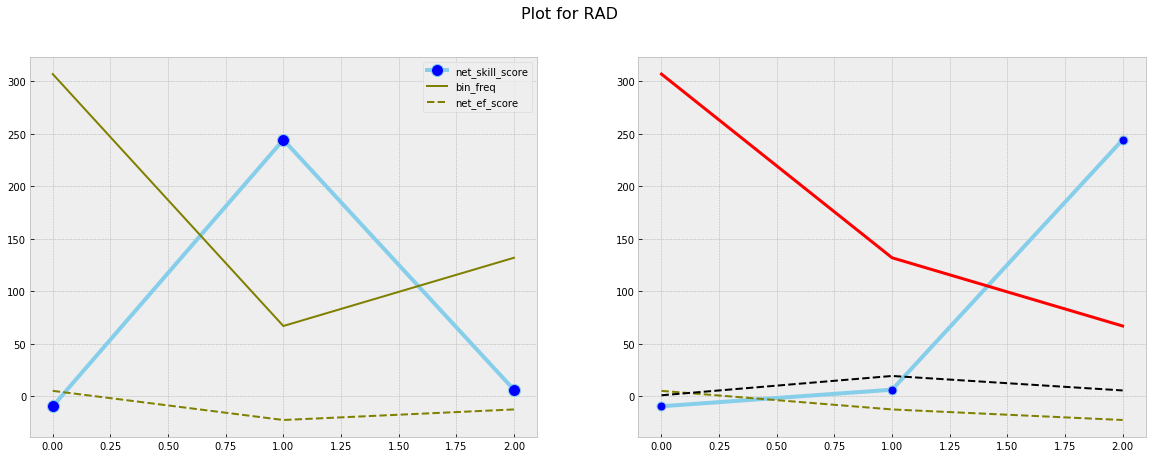

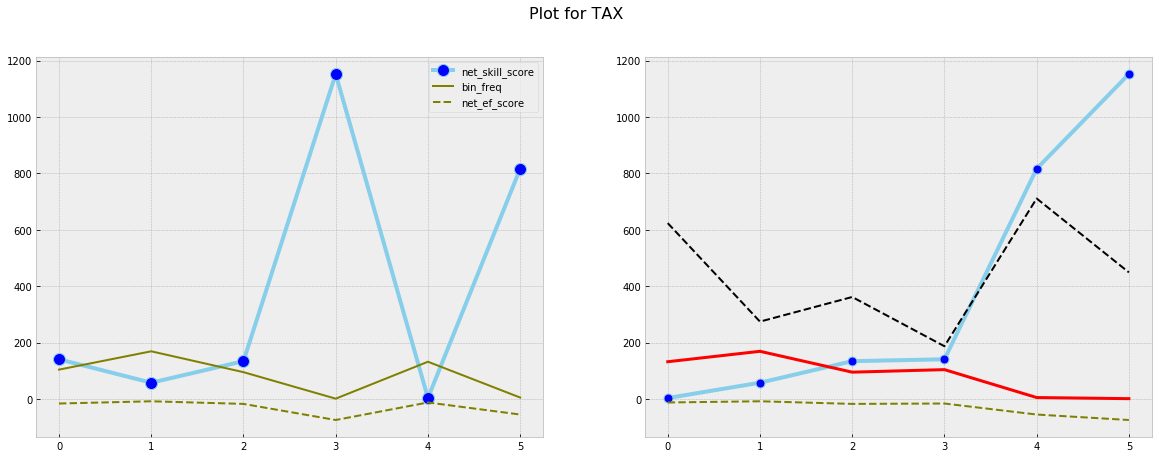

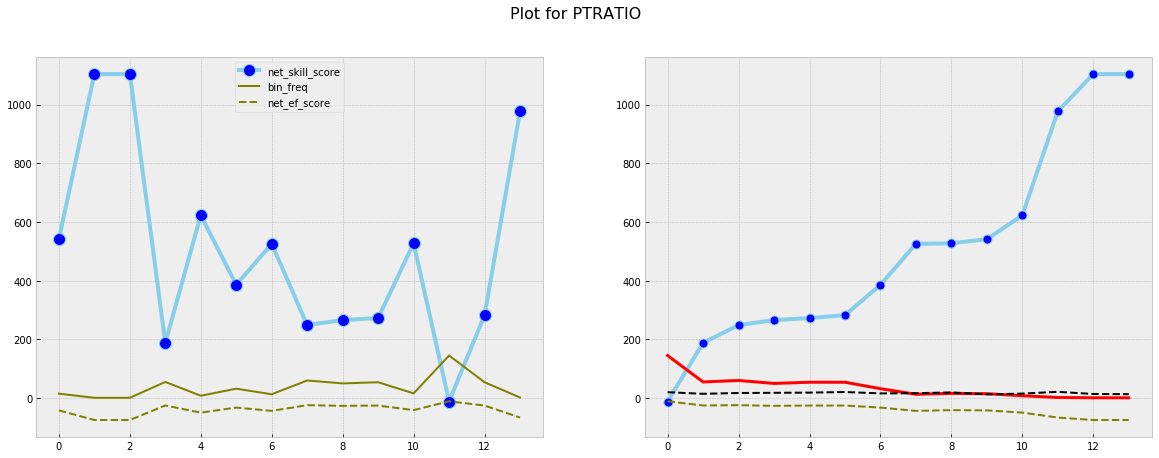

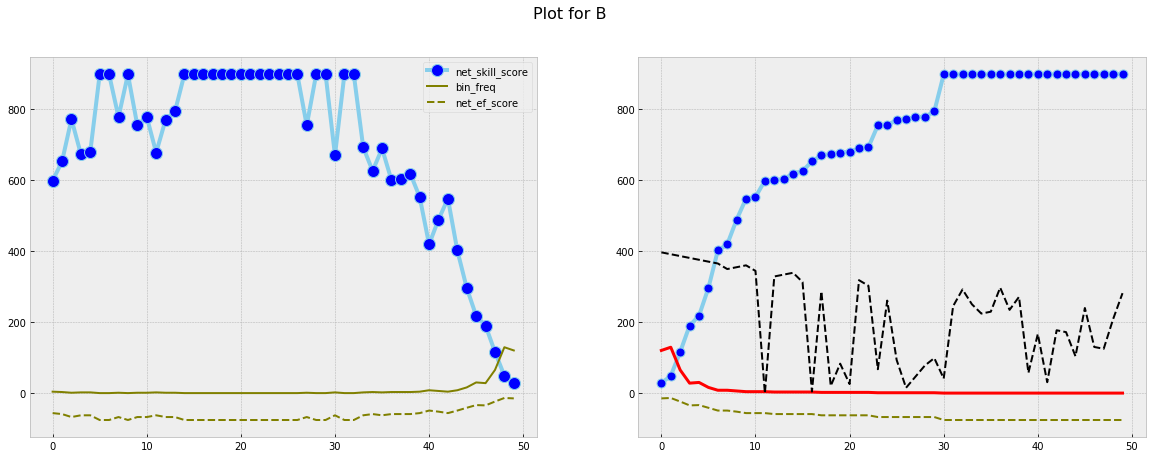

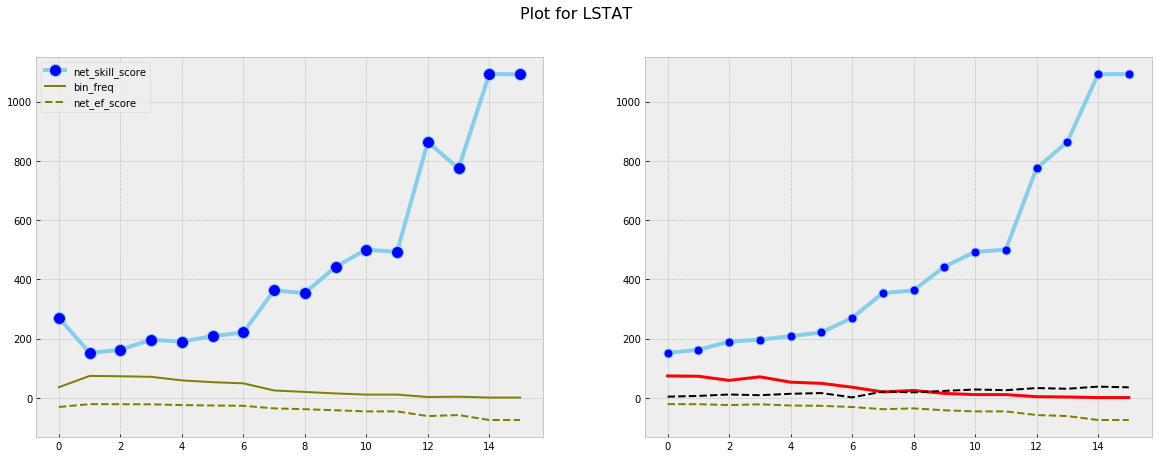

In [60]:
for k,col_skill in enumerate(skill_eval):    
    col_skill_score = []
    col_ef_score = []
    for i in col_skill:
        col_skill_score.append(i[1])
        col_ef_score.append(i[0])
    col_skill_score = np.sum(col_skill_score,axis=0)
    col_ef_score = np.sum(col_ef_score,axis = 0)
    
    # Data
    skill_df=pd.DataFrame({'value_range': range(0,col_skill_score.shape[0]), 
                           'net_skill_score': col_skill_score, 
                           'net_ef_score': col_ef_score,
                           'bin_freq': i[3] })

    # multiple line plot
    plt.figure(figsize=(20,7))
    plt.subplot(1,2,1)
    plt.plot( 'value_range', 'net_skill_score', data=skill_df, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4)
    plt.plot( 'value_range', 'bin_freq', data=skill_df, marker='', color='olive', linewidth=2)
    plt.plot( 'value_range', 'net_ef_score', data=skill_df, marker='', color='olive', linewidth=2, linestyle='dashed')
    plt.legend()
    plt.subplot(1,2,2)
    skill_df.sort_values('net_skill_score',inplace=True)
    skill_df.reset_index()
    col_ef_score = col_ef_score[np.argsort(col_skill_score)]
    hist = i[3][np.argsort(col_skill_score)]
    values = i[2][np.argsort(col_skill_score)]
    col_skill_score = col_skill_score[np.argsort(col_skill_score)]
    
#     plt.plot(i[2])
    plt.plot( col_skill_score, marker='o', markerfacecolor='blue', markersize=9, color='skyblue', linewidth=4)
    plt.plot( hist, marker='', color='red', linewidth=3)
    plt.plot( col_ef_score, marker='', color='olive', linewidth=2, linestyle='dashed')
    plt.plot( values, marker='', color='black', linewidth=2, linestyle='dashed')
#     plt.xticks(values)
#     plt.xlabel(values)
    plt.suptitle('Plot for {}'.format(df.columns[k]),fontsize=16)
    plt.show()

13
(0, 1)
Added evaluation for 0
Added evaluation for 1
(0, 2)
Added evaluation for 0
Added evaluation for 2
(0, 3)
Added evaluation for 0
Added evaluation for 3
(0, 4)
Added evaluation for 0
Added evaluation for 4
(0, 5)
Added evaluation for 0
Added evaluation for 5
(0, 6)
Added evaluation for 0
Added evaluation for 6
(0, 7)
Added evaluation for 0
Added evaluation for 7
(0, 8)
Added evaluation for 0
Added evaluation for 8
(0, 9)
Added evaluation for 0
Added evaluation for 9
(0, 10)
Added evaluation for 0
Added evaluation for 10
(0, 11)
Added evaluation for 0
Added evaluation for 11
(0, 12)
Added evaluation for 0
Added evaluation for 12
(1, 2)
Added evaluation for 1
Added evaluation for 2
(1, 3)
Added evaluation for 1
Added evaluation for 3
(1, 4)
Added evaluation for 1
Added evaluation for 4
(1, 5)
Added evaluation for 1
Added evaluation for 5
(1, 6)
Added evaluation for 1
Added evaluation for 6
(1, 7)
Added evaluation for 1
Added evaluation for 7
(1, 8)
Added evaluation for 1
Added e

/Users/jitins_lab/anaconda2/envs/hyper/lib/python3.6/site-packages/ipykernel/__main__.py:37: RuntimeWarning: overflow encountered in ulong_scalars


Added evaluation for 1
Added evaluation for 12
(2, 3)
Added evaluation for 2
Added evaluation for 3
(2, 4)
Added evaluation for 2
Added evaluation for 4
(2, 5)
Added evaluation for 2
Added evaluation for 5
(2, 6)
Added evaluation for 2
Added evaluation for 6
(2, 7)
Added evaluation for 2
Added evaluation for 7
(2, 8)
Added evaluation for 2
Added evaluation for 8
(2, 9)
Added evaluation for 2
Added evaluation for 9
(2, 10)
Added evaluation for 2
Added evaluation for 10
(2, 11)
Added evaluation for 2
Added evaluation for 11
(2, 12)
Added evaluation for 2
Added evaluation for 12
(3, 4)
Added evaluation for 3
Added evaluation for 4
(3, 5)
Added evaluation for 3
Added evaluation for 5
(3, 6)
Added evaluation for 3
Added evaluation for 6
(3, 7)
Added evaluation for 3
Added evaluation for 7
(3, 8)
Added evaluation for 3
Added evaluation for 8
(3, 9)
Added evaluation for 3
Added evaluation for 9
(3, 10)
Added evaluation for 3
Added evaluation for 10
(3, 11)
Added evaluation for 3
Added evaluat

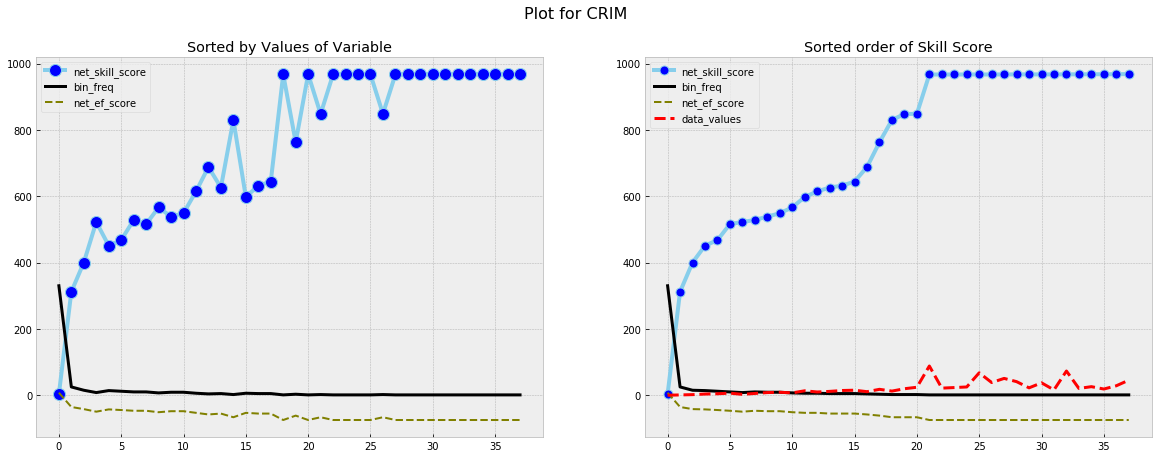

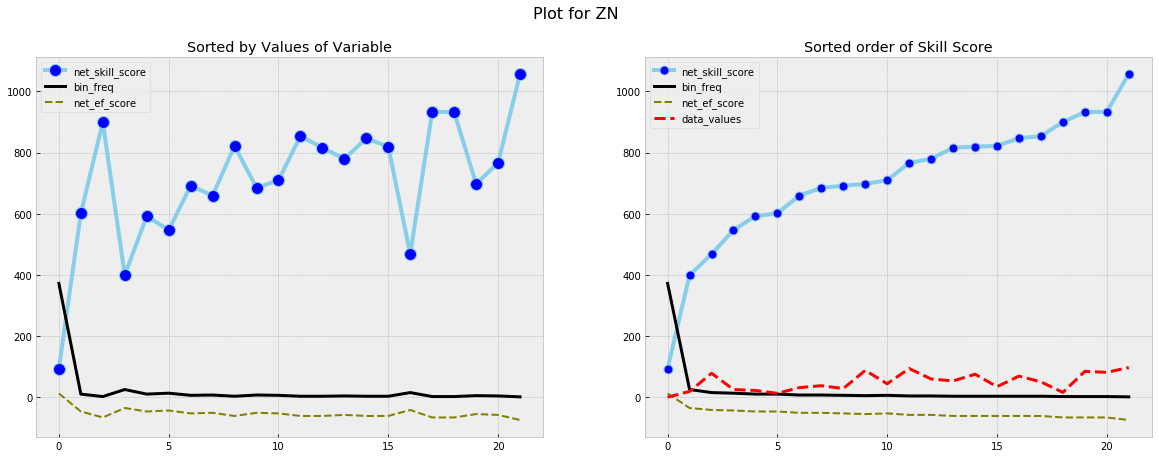

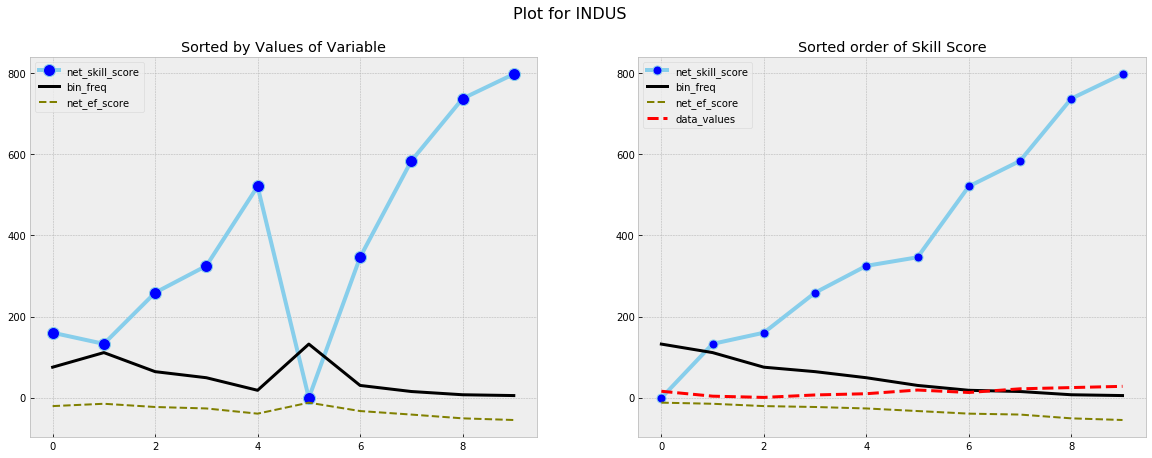

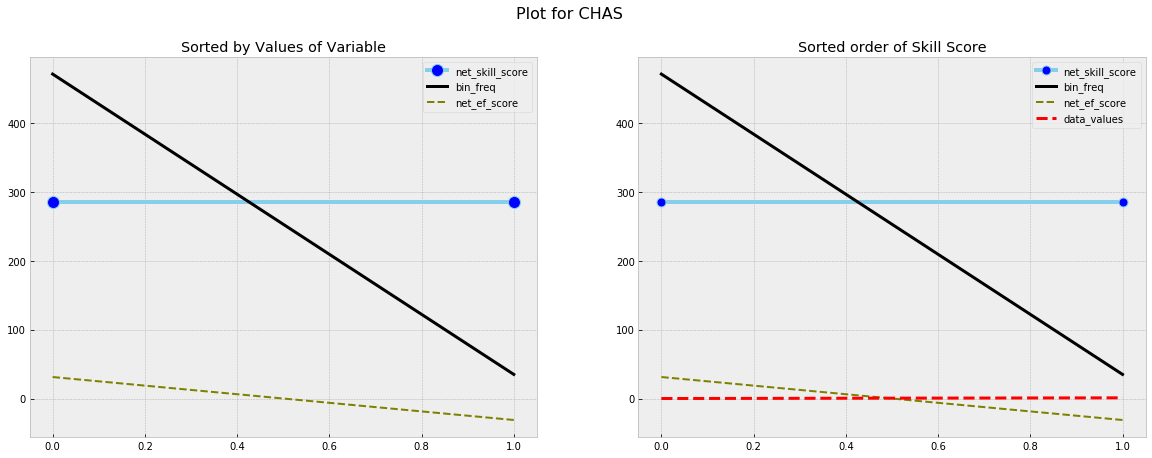

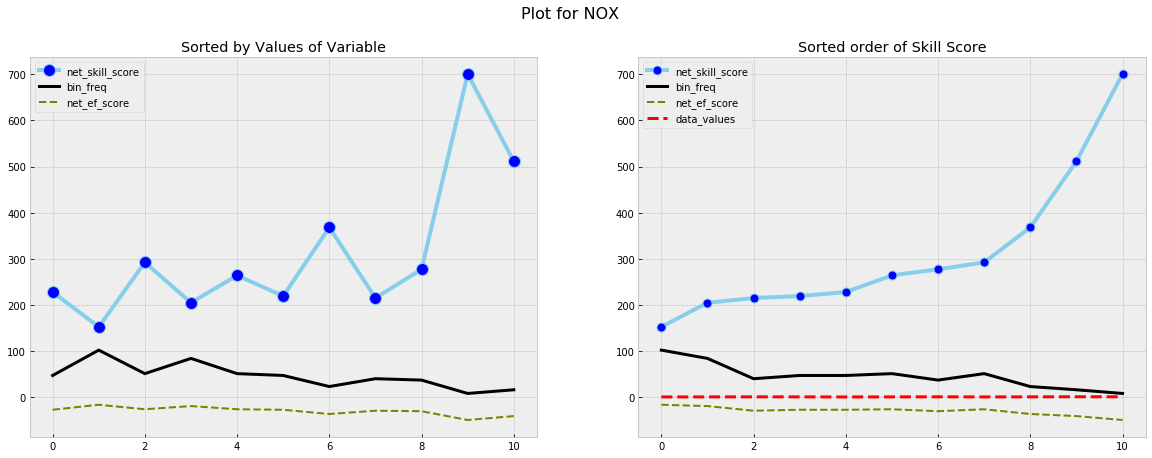

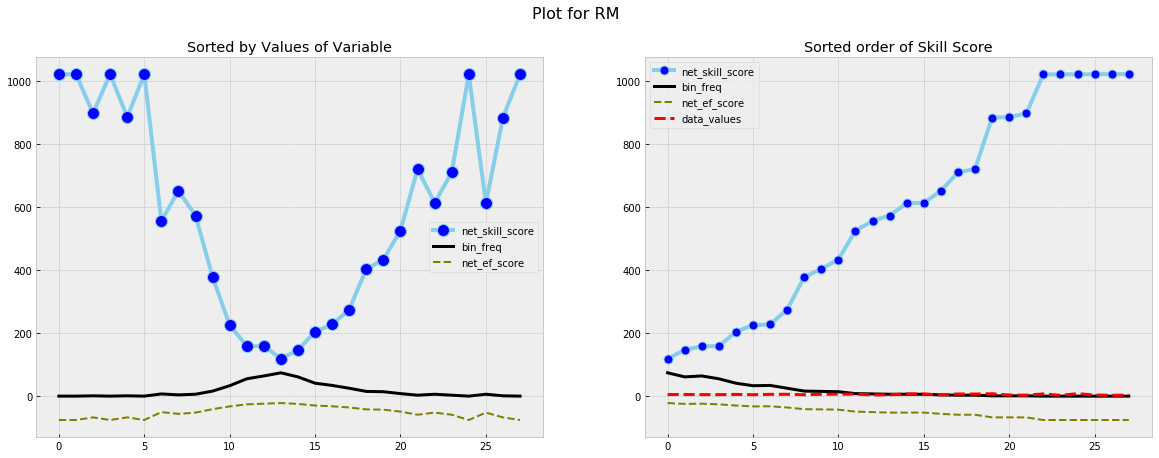

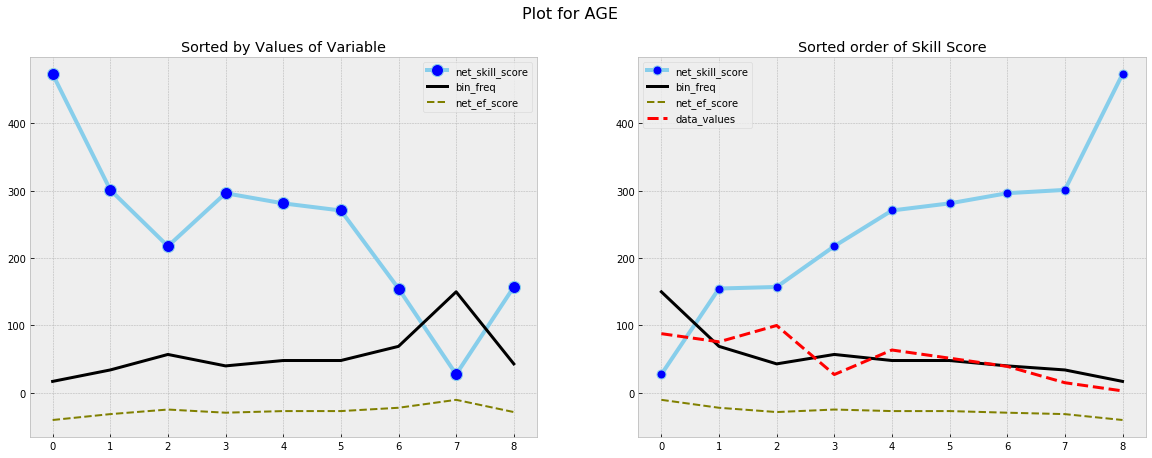

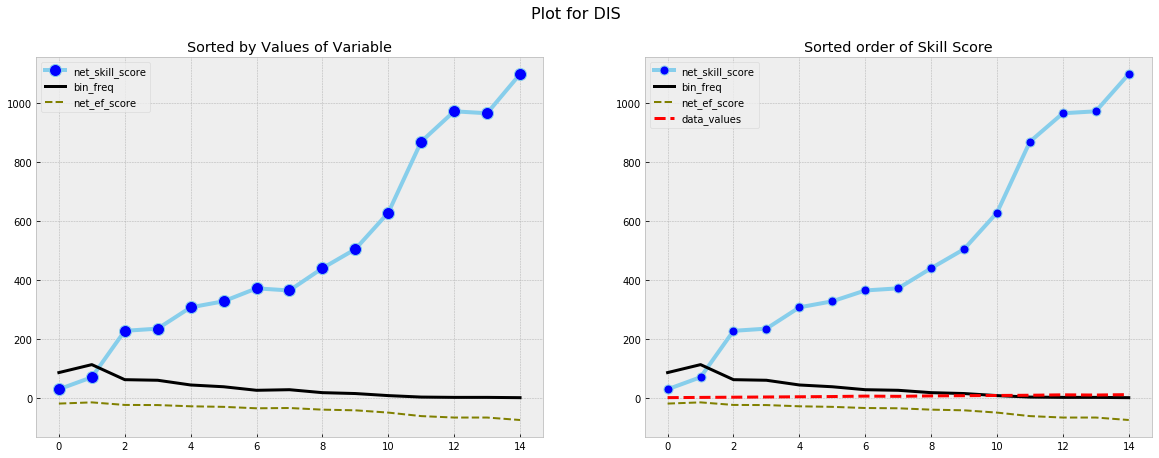

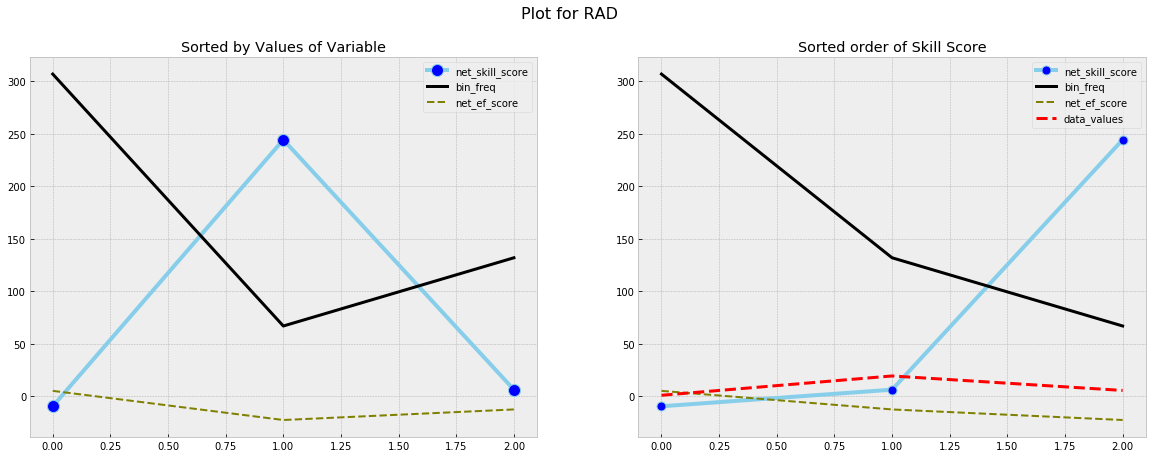

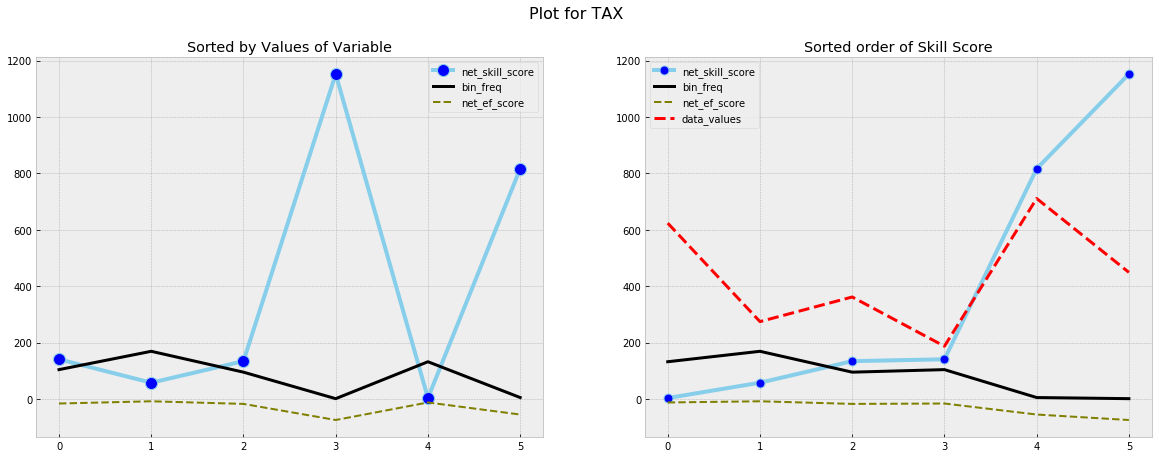

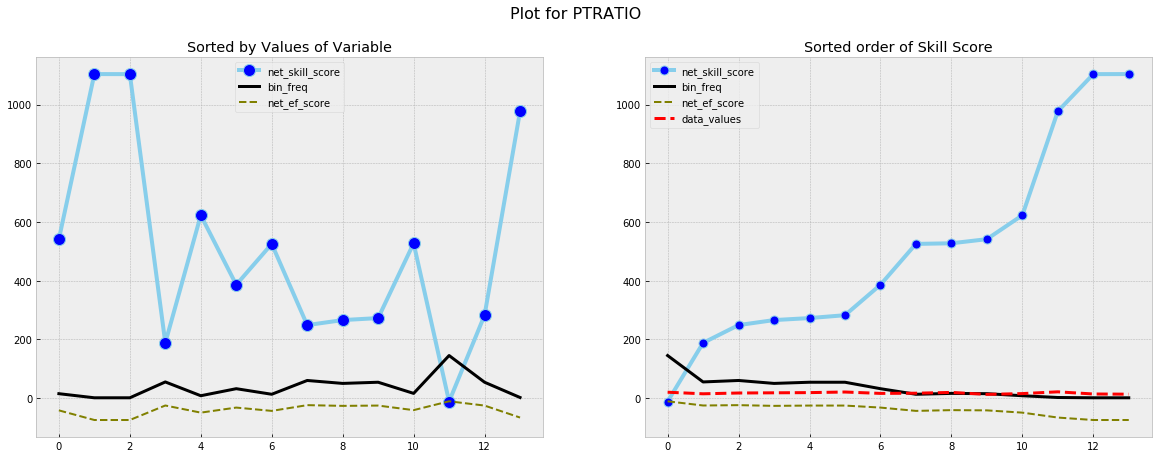

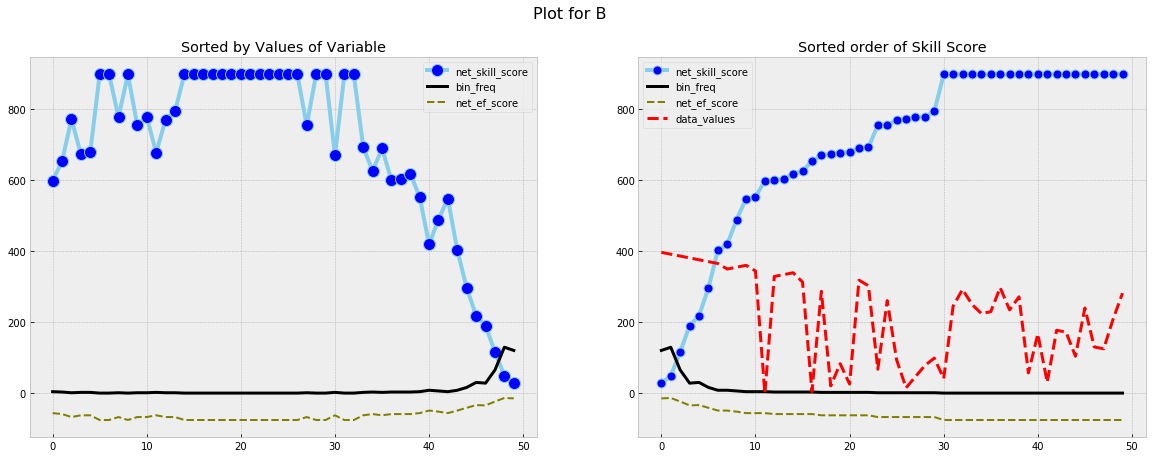

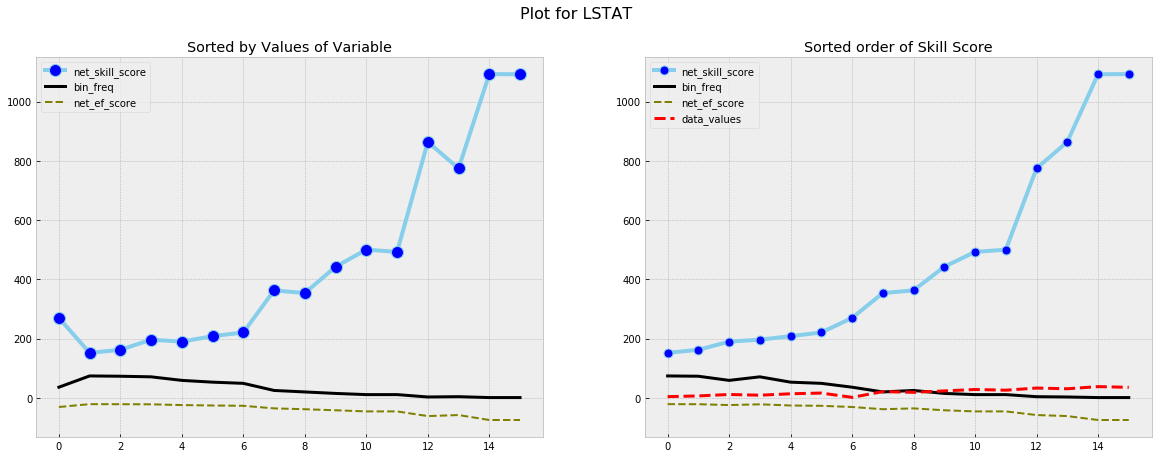

In [61]:
# doing whole step on data set in one go
counters = 0
cols = [i for i in range(0,13)]
skill_eval = [[] for _ in cols]
print(len(skill_eval))
for i in itertools.combinations(cols, 2):
    print(i)
    eval_p = evaluate_pair(df,pair=i)
    for k,val in enumerate(i):
        skill_eval[val].append(eval_p[k])
        print('Added evaluation for {}'.format(val))
   
    counters+=1
    
print(counters)

for k,col_skill in enumerate(skill_eval):    
    col_skill_score = []
    col_ef_score = []
    for i in col_skill:
        col_skill_score.append(i[1])
        col_ef_score.append(i[0])
    col_skill_score = np.sum(col_skill_score,axis=0)
    col_ef_score = np.sum(col_ef_score,axis = 0)
    
    # Data
    skill_df=pd.DataFrame({'value_range': range(0,col_skill_score.shape[0]), 
                           'net_skill_score': col_skill_score, 
                           'net_ef_score': col_ef_score,
                           'bin_freq': i[3] })

    # multiple line plot
    plt.figure(figsize=(20,7))
    plt.subplot(1,2,1)
    plt.plot( 'value_range', 'net_skill_score', data=skill_df, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4)
    plt.plot( 'value_range', 'bin_freq', data=skill_df, marker='', color='black', linewidth=3)
    plt.plot( 'value_range', 'net_ef_score', data=skill_df, marker='', color='olive', linewidth=2, linestyle='dashed')
    plt.title('Sorted by Values of Variable')
    plt.legend()
    
    plt.subplot(1,2,2)
    skill_df.sort_values('net_skill_score',inplace=True)
    skill_df.reset_index()
    col_ef_score = col_ef_score[np.argsort(col_skill_score)]
    hist = i[3][np.argsort(col_skill_score)]
    values = i[2][np.argsort(col_skill_score)]
    col_skill_score = col_skill_score[np.argsort(col_skill_score)]
    
#     plt.plot(i[2])
    plt.plot( col_skill_score, marker='o', markerfacecolor='blue', markersize=9, color='skyblue', linewidth=4,label = 'net_skill_score')
    plt.plot( hist, marker='', color='black', linewidth=3,label = 'bin_freq')
    plt.plot( col_ef_score, marker='', color='olive', linewidth=2, linestyle='dashed',label = 'net_ef_score')
    plt.plot( values, marker='', color='red', linewidth=3, linestyle='dashed', label = 'data_values')
    plt.title('Sorted order of Skill Score')
    plt.legend()
#     plt.xticks(values)
#     plt.xlabel(values)
    plt.suptitle('Plot for {}'.format(df.columns[k]),fontsize=16)
    plt.show()

13
(0, 1)
(0, 2)
(0, 3)
(0, 4)
(0, 5)
(0, 6)
(0, 7)
(0, 8)
(0, 9)
(0, 10)
(0, 11)
(0, 12)
(1, 2)
(1, 3)
(1, 4)
(1, 5)
(1, 6)
(1, 7)
(1, 8)
(1, 9)
(1, 10)
(1, 11)
(1, 12)
(2, 3)


/Users/jitins_lab/anaconda2/envs/hyper/lib/python3.6/site-packages/ipykernel/__main__.py:37: RuntimeWarning: overflow encountered in ulong_scalars


(2, 4)
(2, 5)
(2, 6)
(2, 7)
(2, 8)
(2, 9)
(2, 10)
(2, 11)
(2, 12)
(3, 4)
(3, 5)
(3, 6)
(3, 7)
(3, 8)
(3, 9)
(3, 10)
(3, 11)
(3, 12)
(4, 5)
(4, 6)
(4, 7)
(4, 8)
(4, 9)
(4, 10)
(4, 11)
(4, 12)
(5, 6)
(5, 7)
(5, 8)
(5, 9)
(5, 10)
(5, 11)
(5, 12)
(6, 7)
(6, 8)
(6, 9)
(6, 10)
(6, 11)
(6, 12)
(7, 8)
(7, 9)
(7, 10)
(7, 11)
(7, 12)
(8, 9)
(8, 10)
(8, 11)
(8, 12)
(9, 10)
(9, 11)
(9, 12)
(10, 11)
(10, 12)
(11, 12)
78


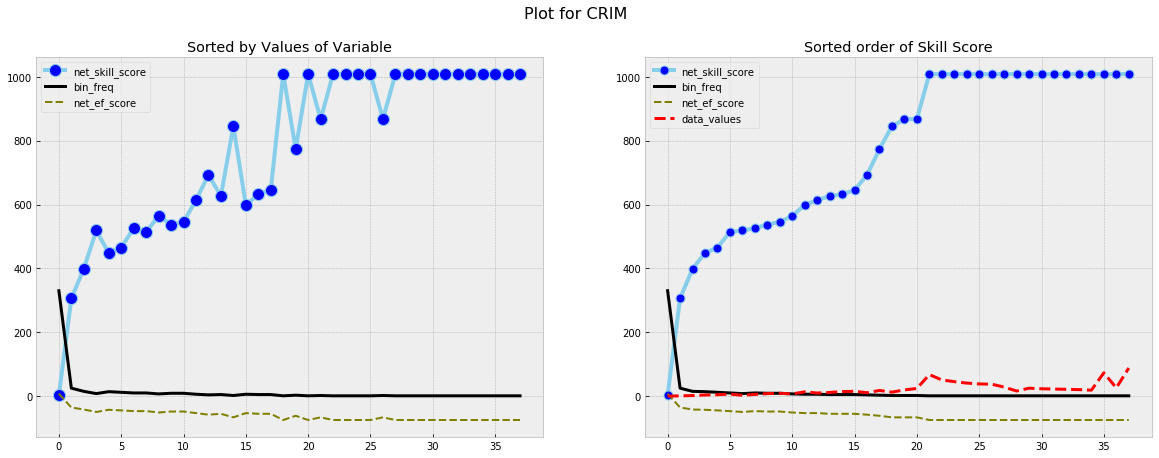

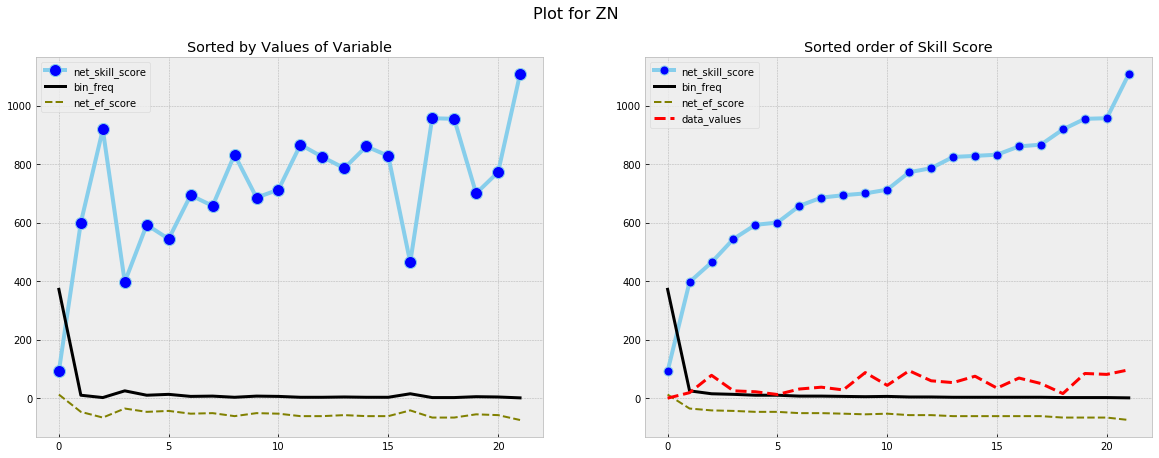

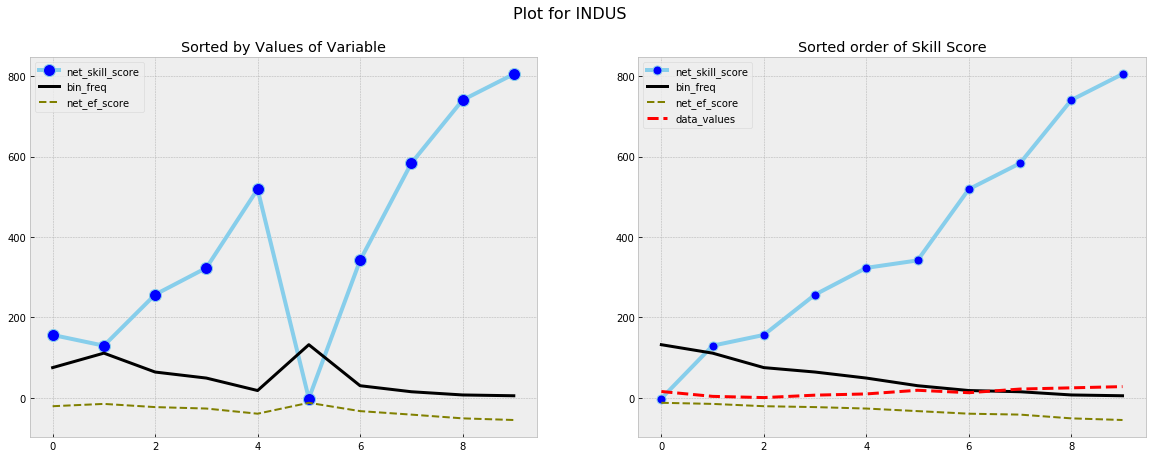

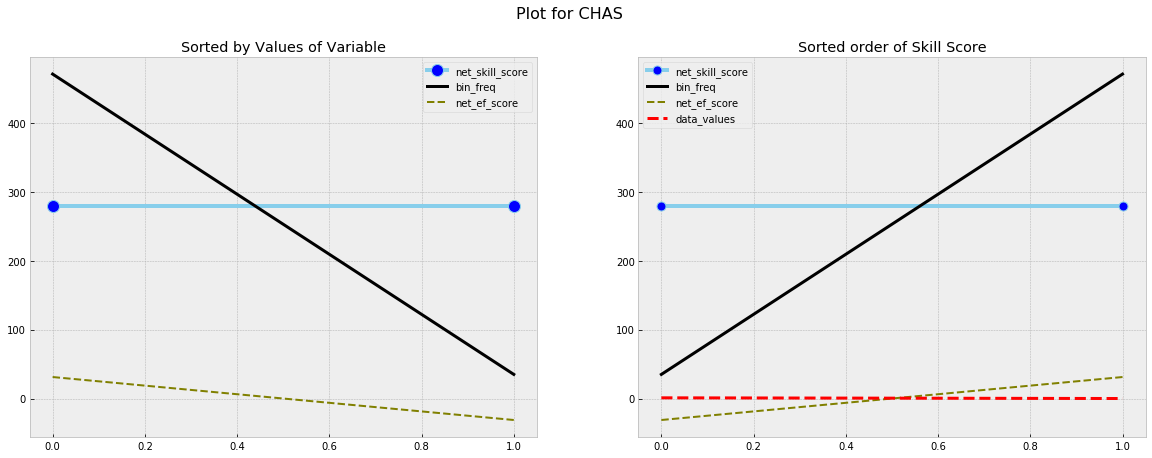

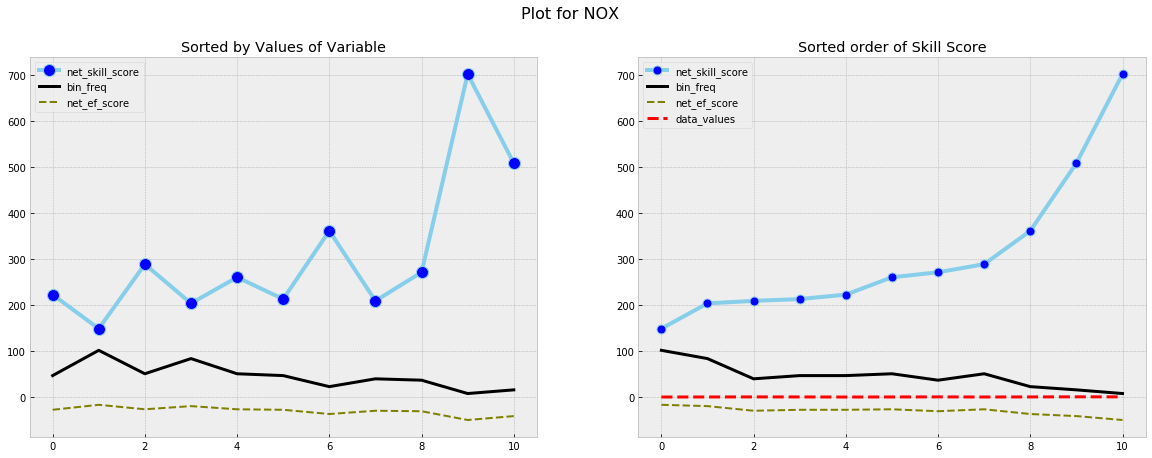

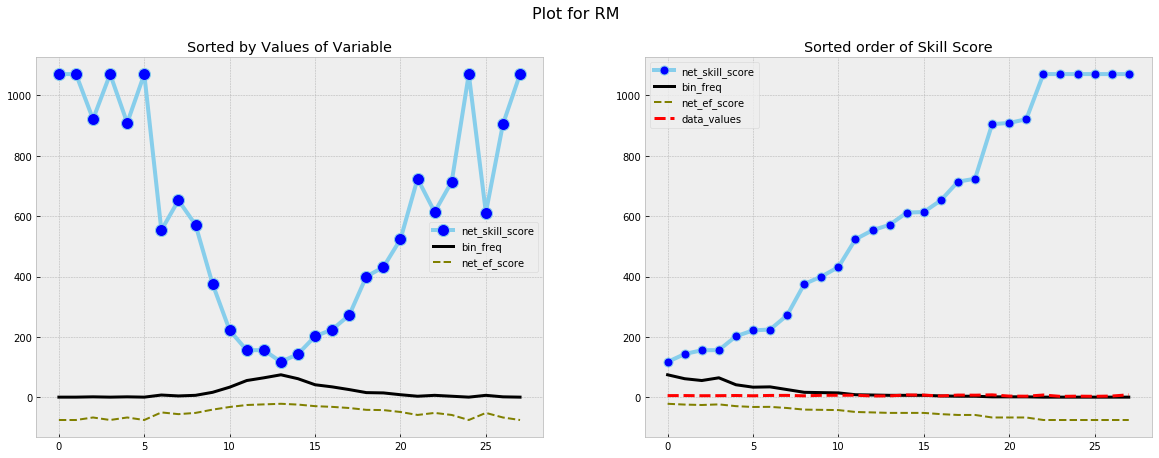

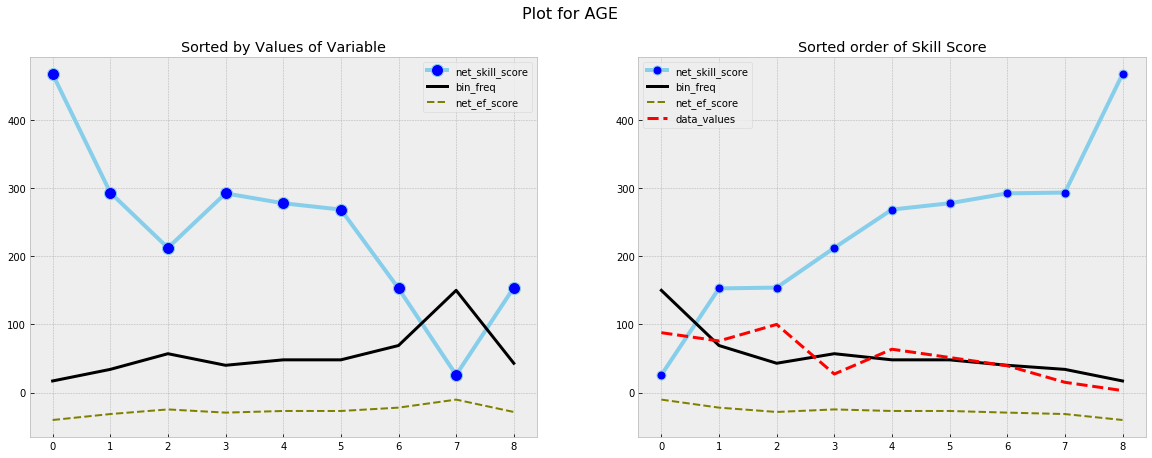

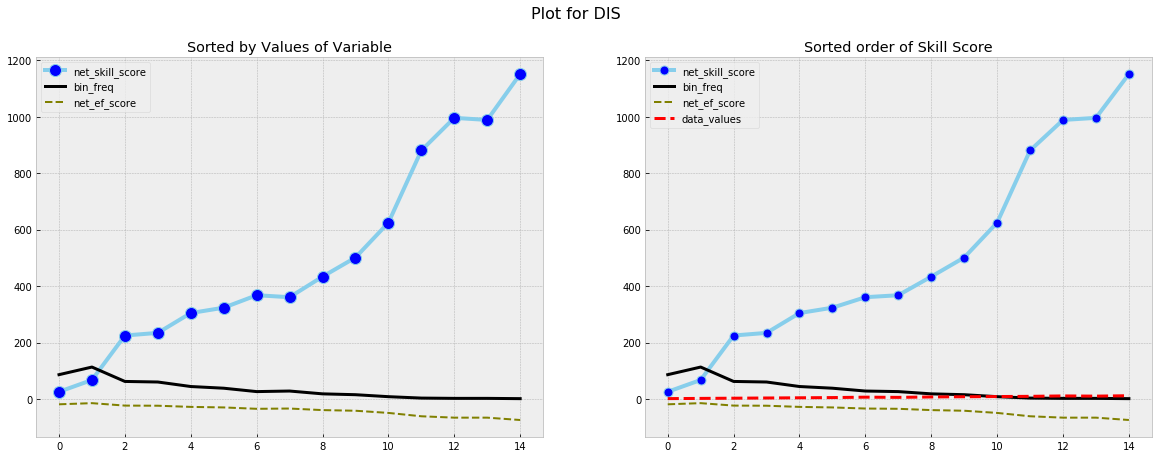

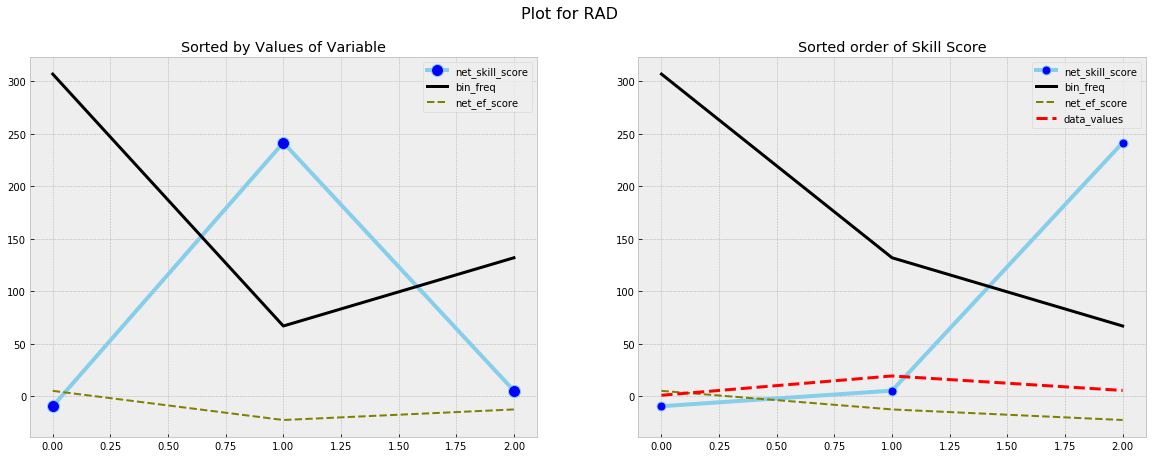

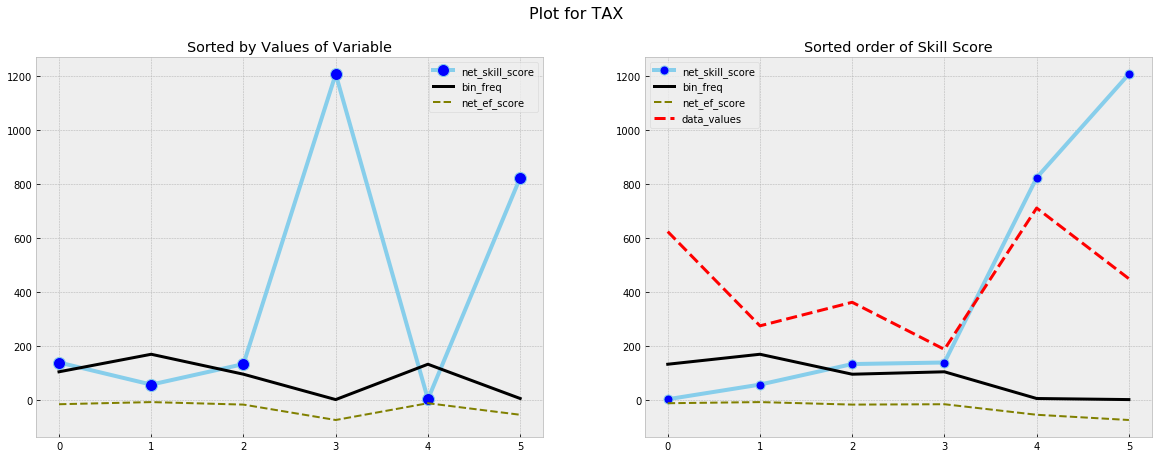

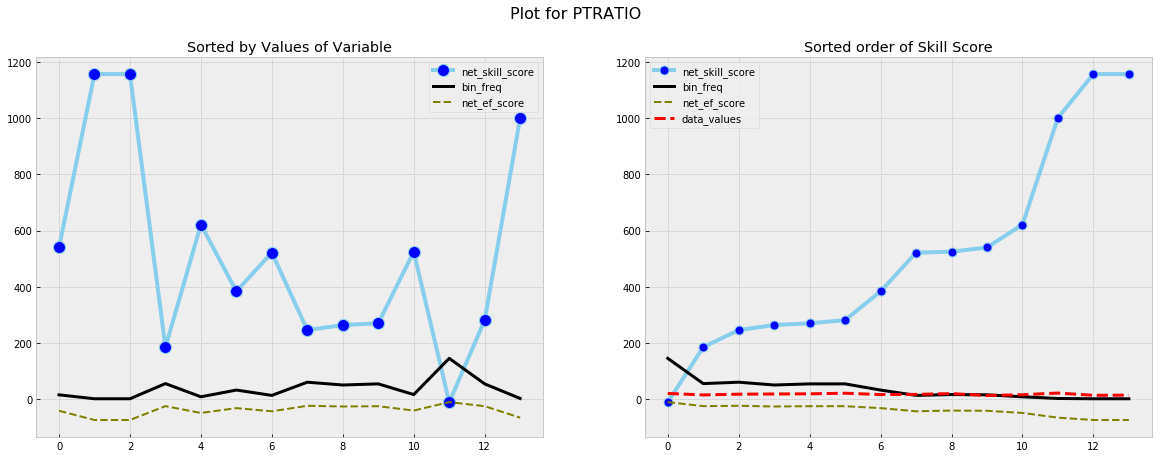

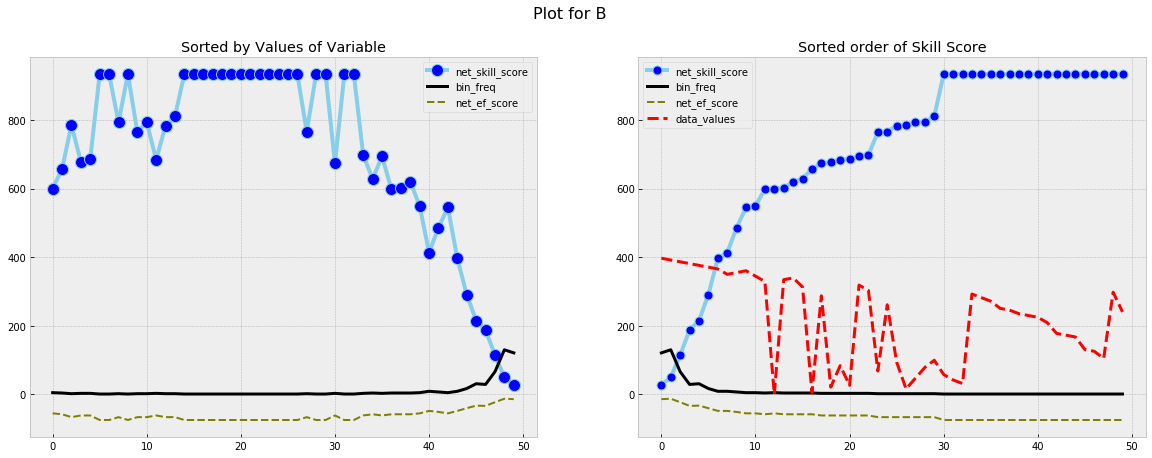

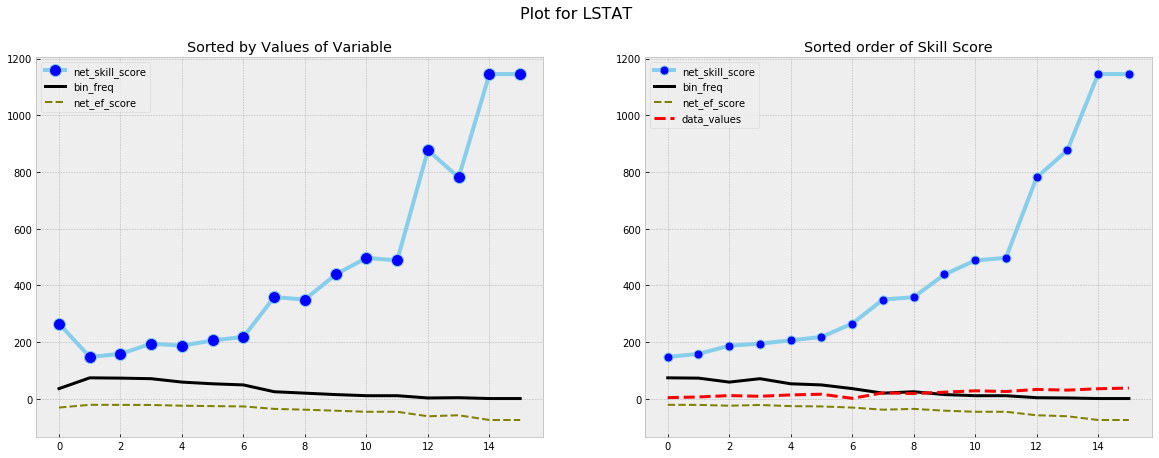

In [62]:
# doing whole step on data set in one go
counters = 0
cols = [i for i in range(0,13)]
skill_eval = [[] for _ in cols]
print(len(skill_eval))
for i in itertools.combinations(cols, 2):
    print(i)
    eval_p = evaluate_pair(df,pair=i,skill='yule')
    for k,val in enumerate(i):
        skill_eval[val].append(eval_p[k])
#         print('Added evaluation for {}'.format(val))
   
    counters+=1
    
print(counters)

for k,col_skill in enumerate(skill_eval):    
    col_skill_score = []
    col_ef_score = []
    for i in col_skill:
        col_skill_score.append(i[1])
        col_ef_score.append(i[0])
    col_skill_score = np.sum(col_skill_score,axis=0)
    col_ef_score = np.sum(col_ef_score,axis = 0)
    
    # Data
    skill_df=pd.DataFrame({'value_range': range(0,col_skill_score.shape[0]), 
                           'net_skill_score': col_skill_score, 
                           'net_ef_score': col_ef_score,
                           'bin_freq': i[3] })

    # multiple line plot
    plt.figure(figsize=(20,7))
    plt.subplot(1,2,1)
    plt.plot( 'value_range', 'net_skill_score', data=skill_df, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4)
    plt.plot( 'value_range', 'bin_freq', data=skill_df, marker='', color='black', linewidth=3)
    plt.plot( 'value_range', 'net_ef_score', data=skill_df, marker='', color='olive', linewidth=2, linestyle='dashed')
    plt.title('Sorted by Values of Variable')
    plt.legend()
    
    plt.subplot(1,2,2)
    skill_df.sort_values('net_skill_score',inplace=True)
    skill_df.reset_index()
    col_ef_score = col_ef_score[np.argsort(col_skill_score)]
    hist = i[3][np.argsort(col_skill_score)]
    values = i[2][np.argsort(col_skill_score)]
    col_skill_score = col_skill_score[np.argsort(col_skill_score)]
    
#     plt.plot(i[2])
    plt.plot( col_skill_score, marker='o', markerfacecolor='blue', markersize=9, color='skyblue', linewidth=4,label = 'net_skill_score')
    plt.plot( hist, marker='', color='black', linewidth=3,label = 'bin_freq')
    plt.plot( col_ef_score, marker='', color='olive', linewidth=2, linestyle='dashed',label = 'net_ef_score')
    plt.plot( values, marker='', color='red', linewidth=3, linestyle='dashed', label = 'data_values')
    plt.title('Sorted order of Skill Score')
    plt.legend()
#     plt.xticks(values)
#     plt.xlabel(values)
    plt.suptitle('Plot for {}'.format(df.columns[k]),fontsize=16)
    plt.show()

13


/Users/jitins_lab/anaconda2/envs/hyper/lib/python3.6/site-packages/ipykernel/__main__.py:37: RuntimeWarning: overflow encountered in ulong_scalars


78


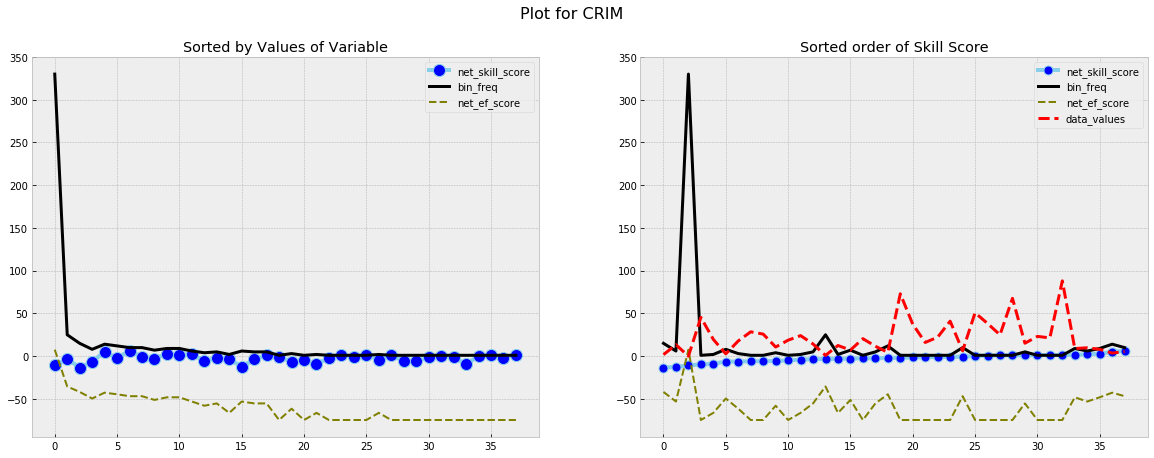

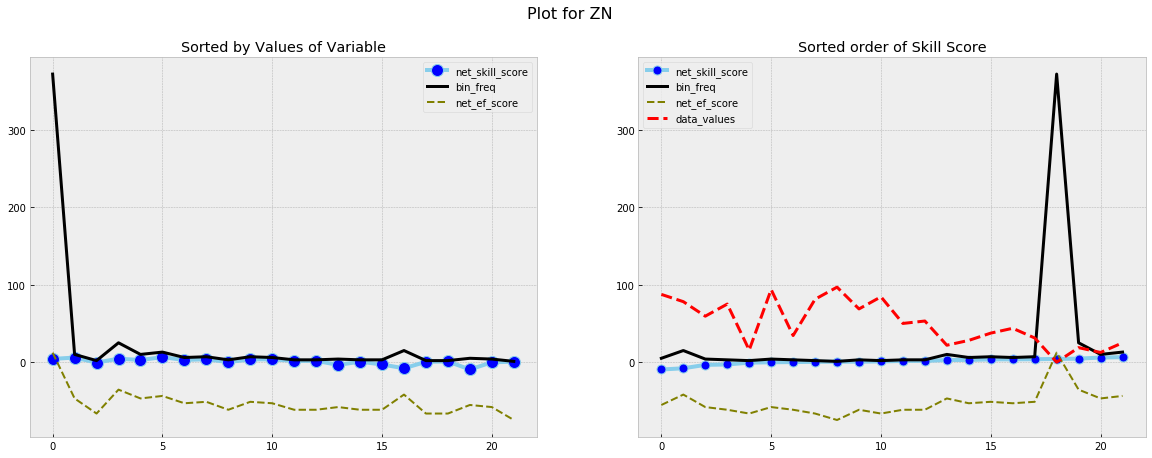

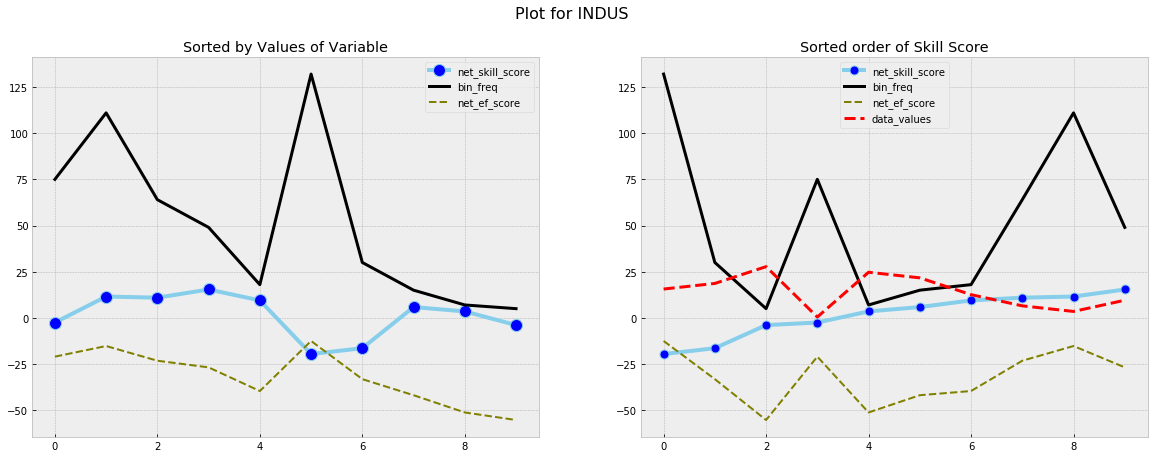

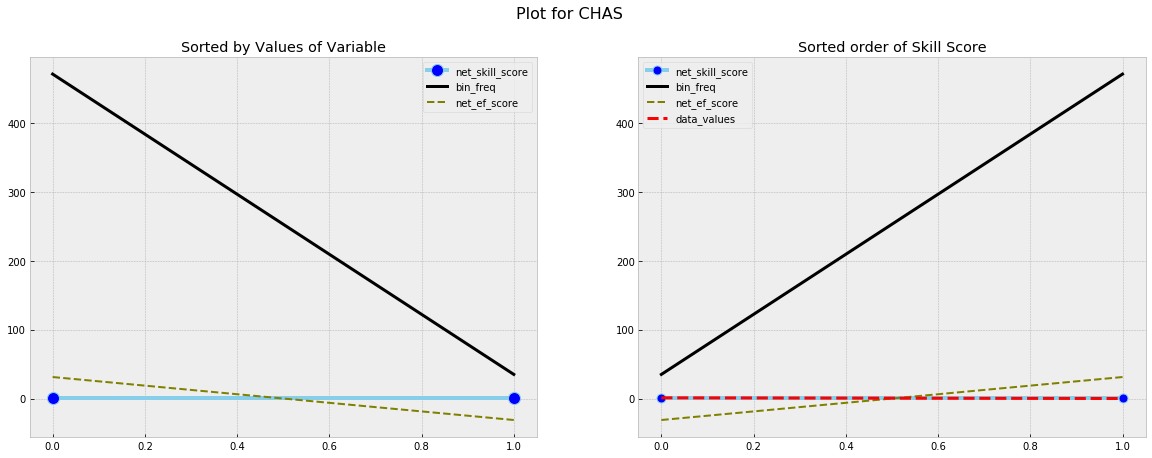

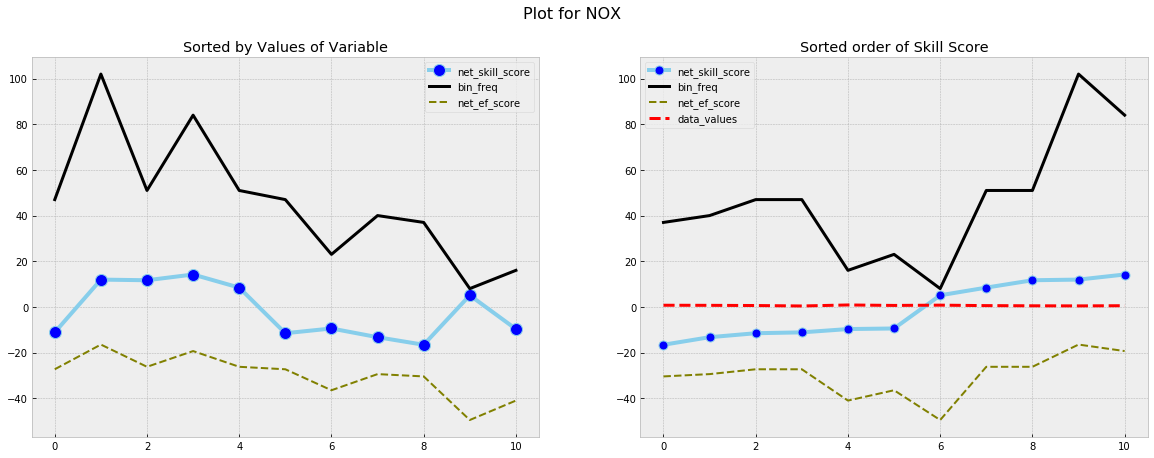

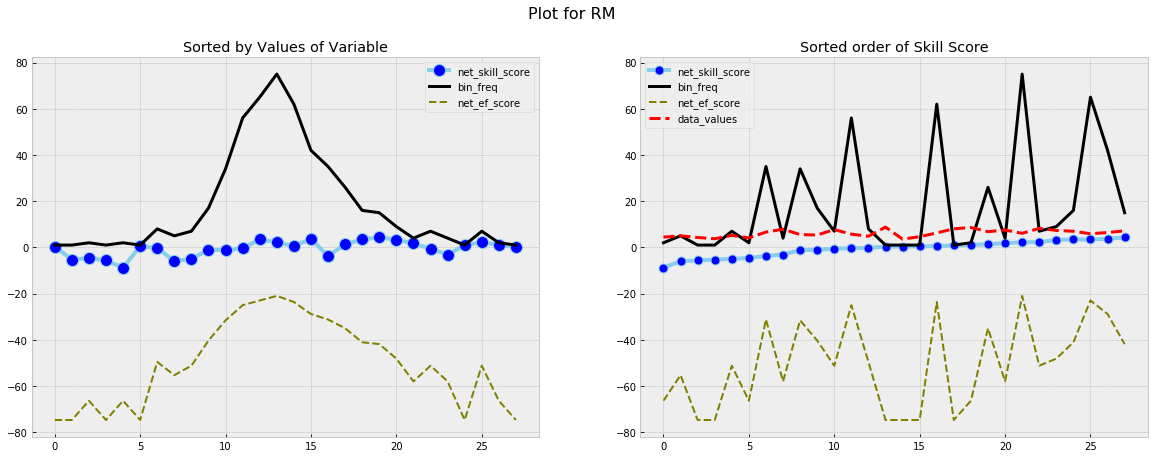

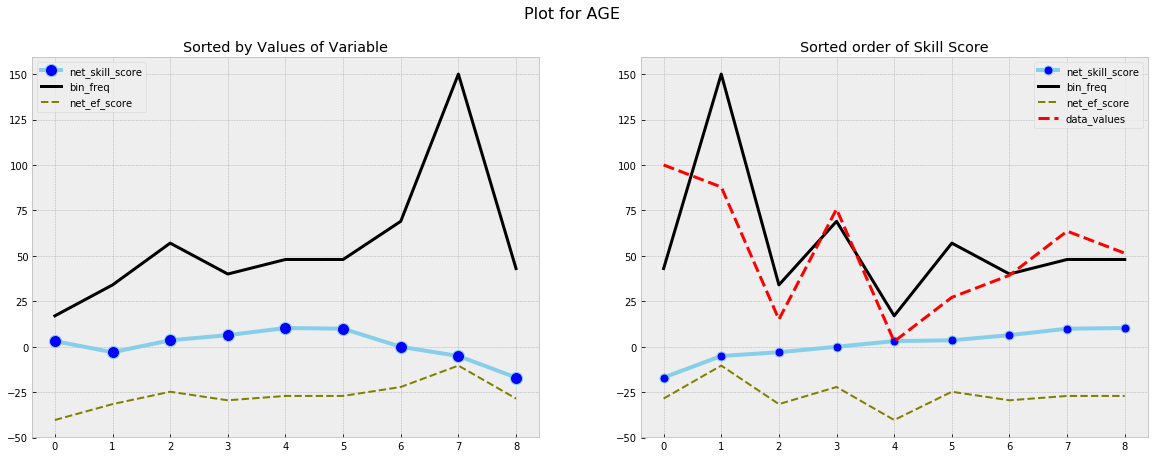

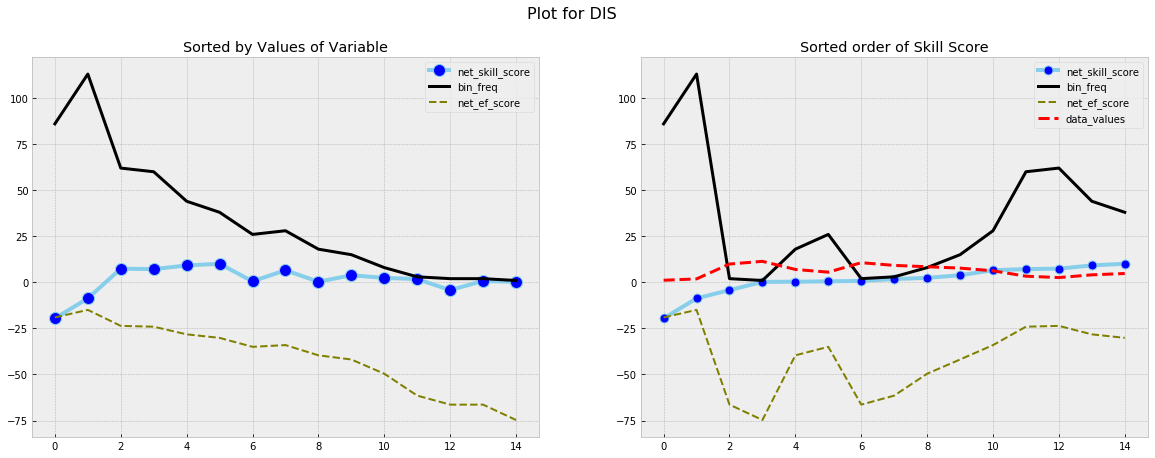

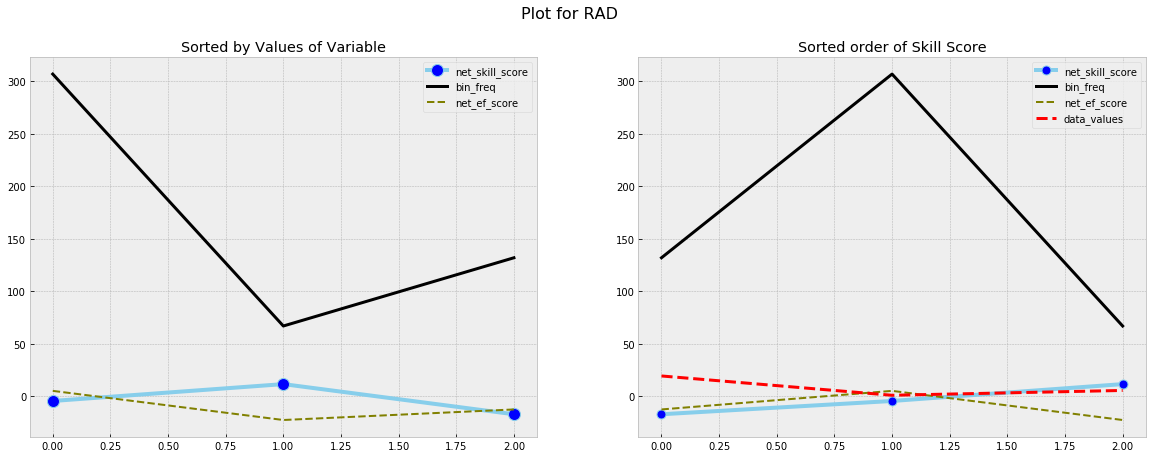

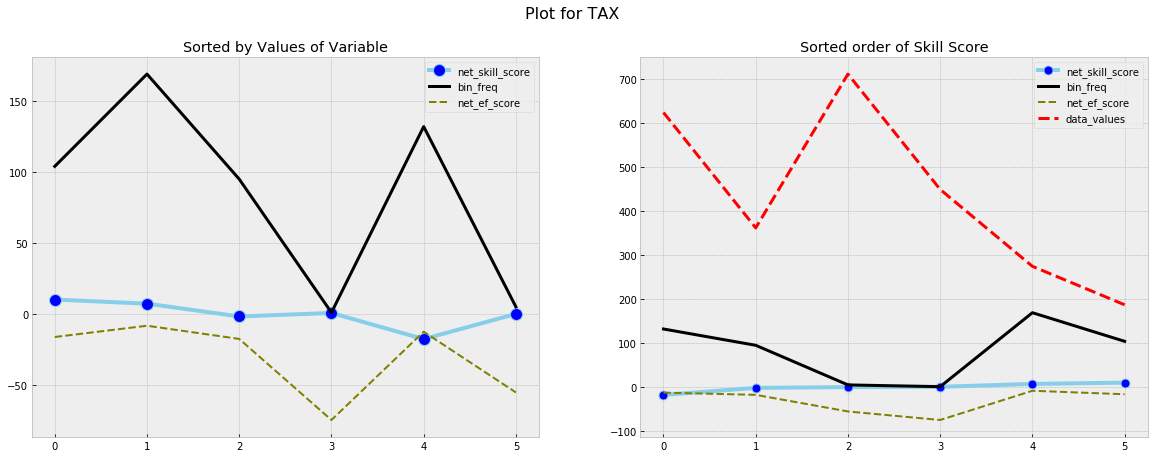

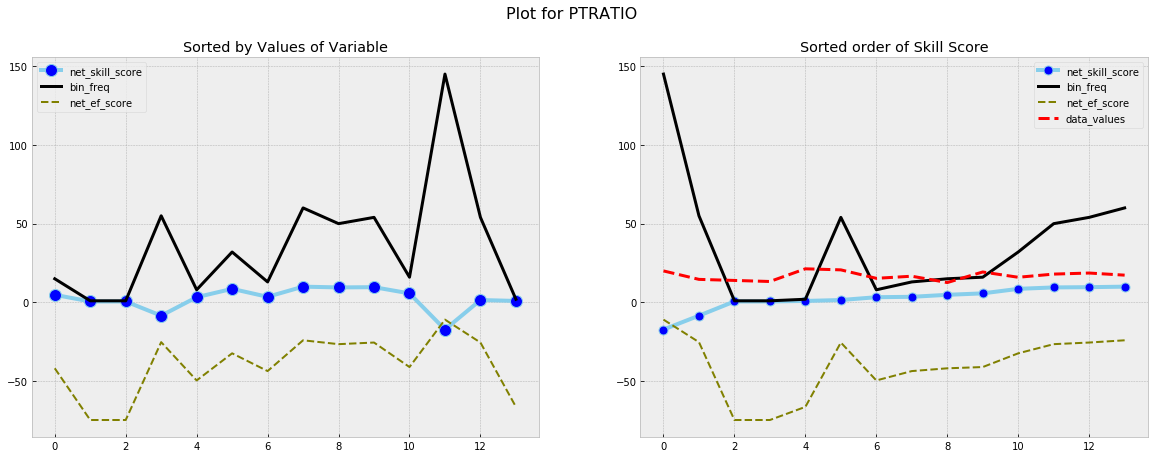

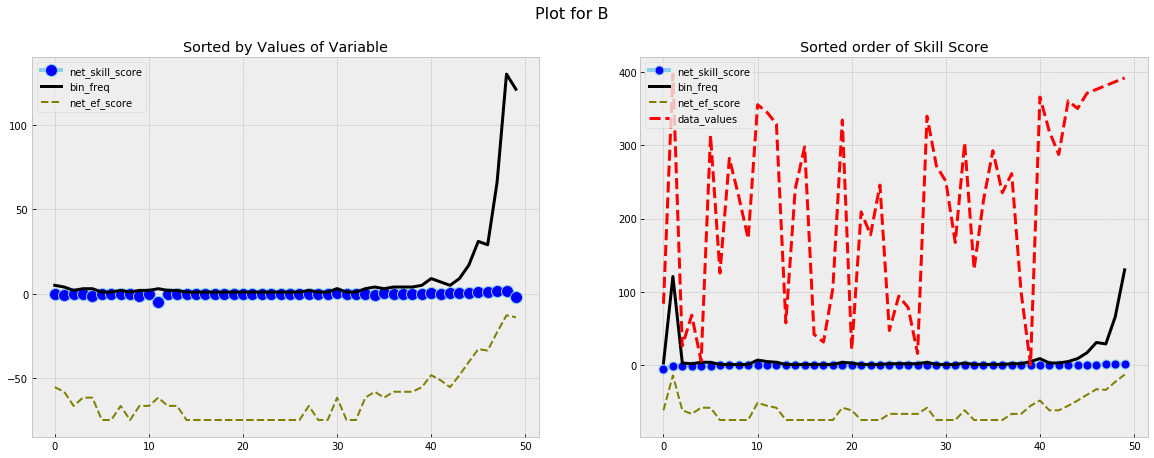

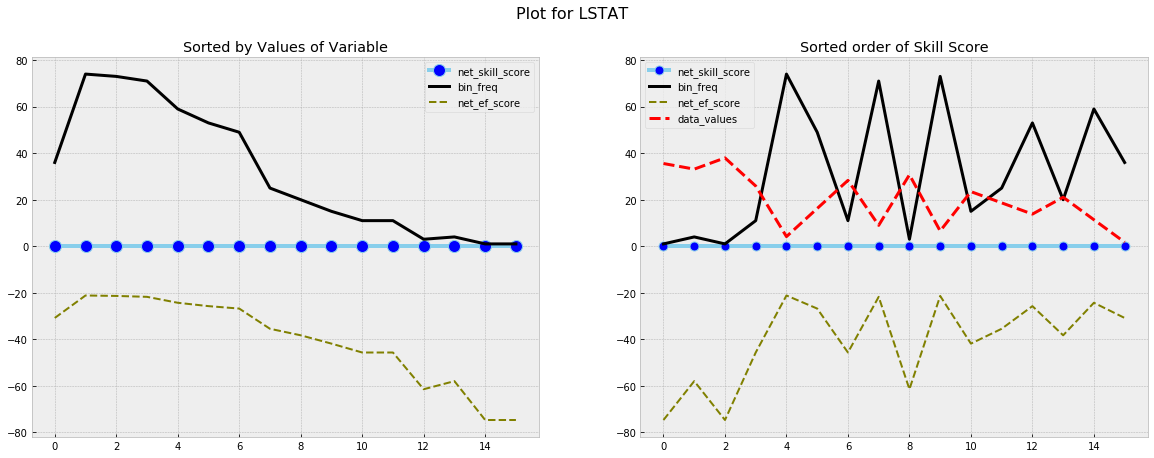

In [63]:
# doing whole step on data set in one go
counters = 0
cols = [i for i in range(0,13)]
skill_eval = [[] for _ in cols]
print(len(skill_eval))
for i in itertools.combinations(cols, 2):
#     print(i)
    eval_p = evaluate_pair(df,pair=i,skill='pierce')
    for k,val in enumerate(i):
        skill_eval[val].append(eval_p[k])
#         print('Added evaluation for {}'.format(val))
   
    counters+=1
    
print(counters)

for k,col_skill in enumerate(skill_eval):    
    col_skill_score = []
    col_ef_score = []
    for i in col_skill:
        col_skill_score.append(i[1])
        col_ef_score.append(i[0])
    col_skill_score = np.sum(col_skill_score,axis=0)
    col_ef_score = np.sum(col_ef_score,axis = 0)
    
    # Data
    skill_df=pd.DataFrame({'value_range': range(0,col_skill_score.shape[0]), 
                           'net_skill_score': col_skill_score, 
                           'net_ef_score': col_ef_score,
                           'bin_freq': i[3] })

    # multiple line plot
    plt.figure(figsize=(20,7))
    plt.subplot(1,2,1)
    plt.plot( 'value_range', 'net_skill_score', data=skill_df, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4)
    plt.plot( 'value_range', 'bin_freq', data=skill_df, marker='', color='black', linewidth=3)
    plt.plot( 'value_range', 'net_ef_score', data=skill_df, marker='', color='olive', linewidth=2, linestyle='dashed')
    plt.title('Sorted by Values of Variable')
    plt.legend()
    
    plt.subplot(1,2,2)
    skill_df.sort_values('net_skill_score',inplace=True)
    skill_df.reset_index()
    col_ef_score = col_ef_score[np.argsort(col_skill_score)]
    hist = i[3][np.argsort(col_skill_score)]
    values = i[2][np.argsort(col_skill_score)]
    col_skill_score = col_skill_score[np.argsort(col_skill_score)]
    
#     plt.plot(i[2])
    plt.plot( col_skill_score, marker='o', markerfacecolor='blue', markersize=9, color='skyblue', linewidth=4,label = 'net_skill_score')
    plt.plot( hist, marker='', color='black', linewidth=3,label = 'bin_freq')
    plt.plot( col_ef_score, marker='', color='olive', linewidth=2, linestyle='dashed',label = 'net_ef_score')
    plt.plot( values, marker='', color='red', linewidth=3, linestyle='dashed', label = 'data_values')
    plt.title('Sorted order of Skill Score')
    plt.legend()
#     plt.xticks(values)
#     plt.xlabel(values)
    plt.suptitle('Plot for {}'.format(df.columns[k]),fontsize=16)
    plt.show()

13


/Users/jitins_lab/anaconda2/envs/hyper/lib/python3.6/site-packages/ipykernel/__main__.py:37: RuntimeWarning: overflow encountered in ulong_scalars


78


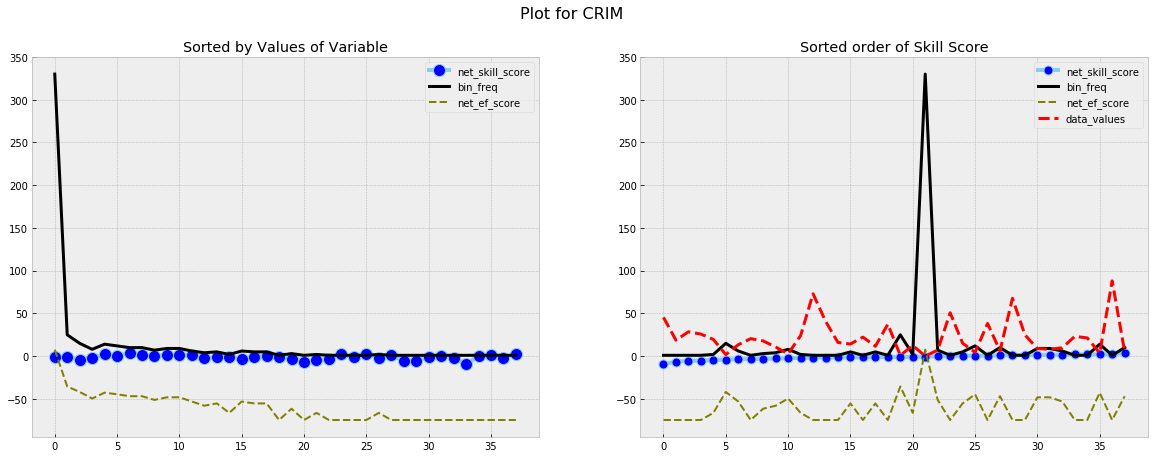

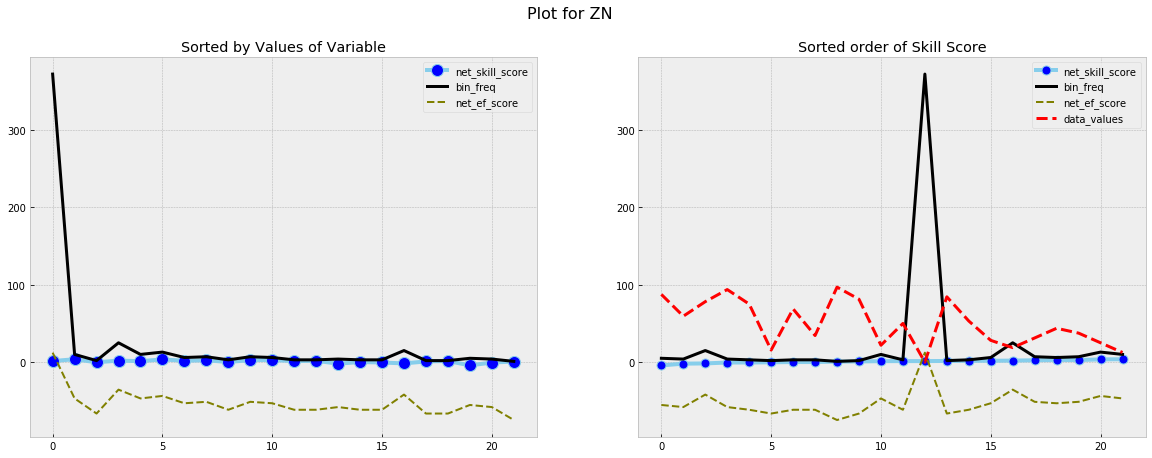

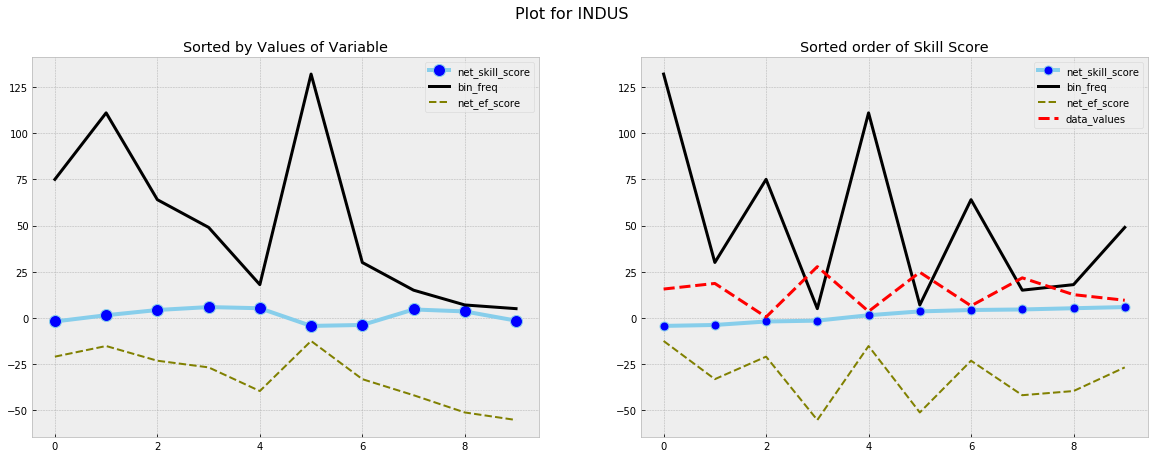

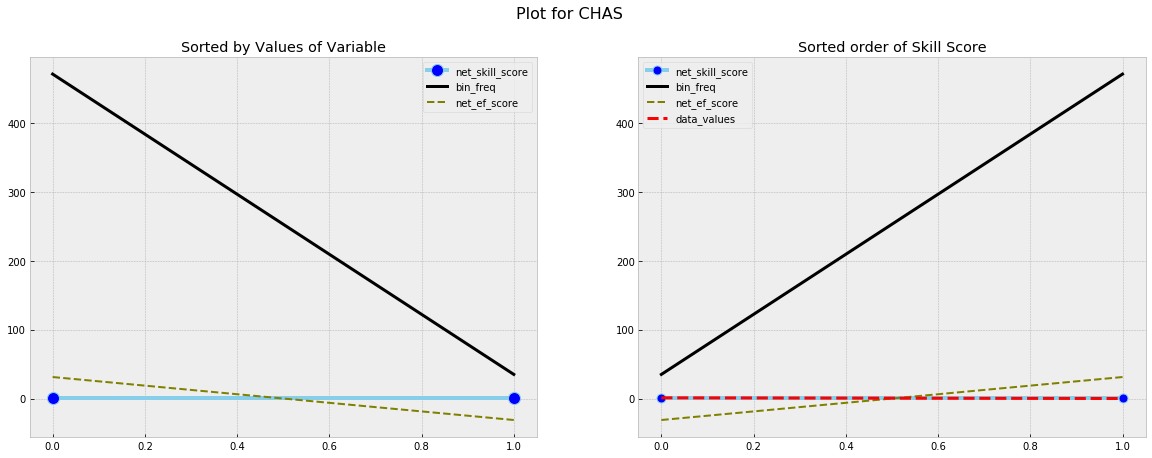

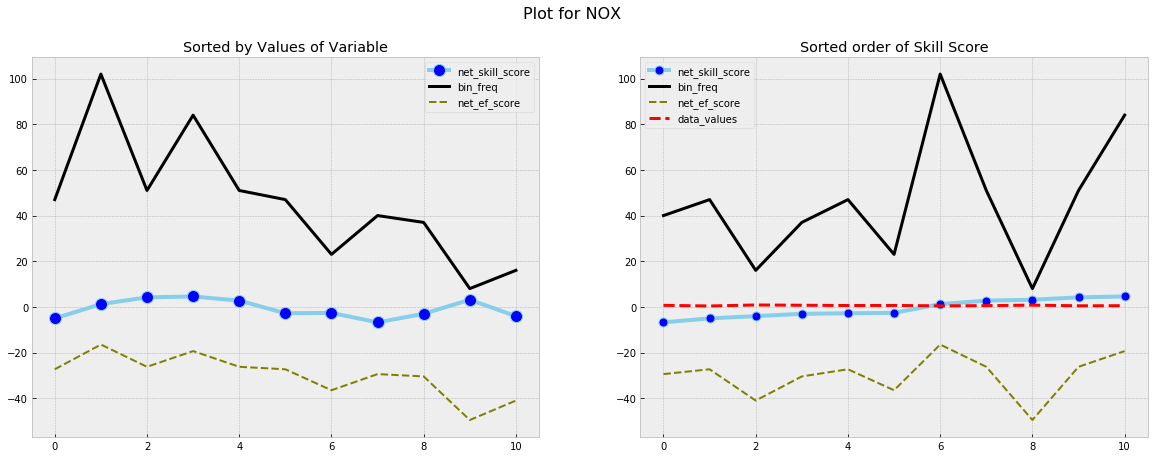

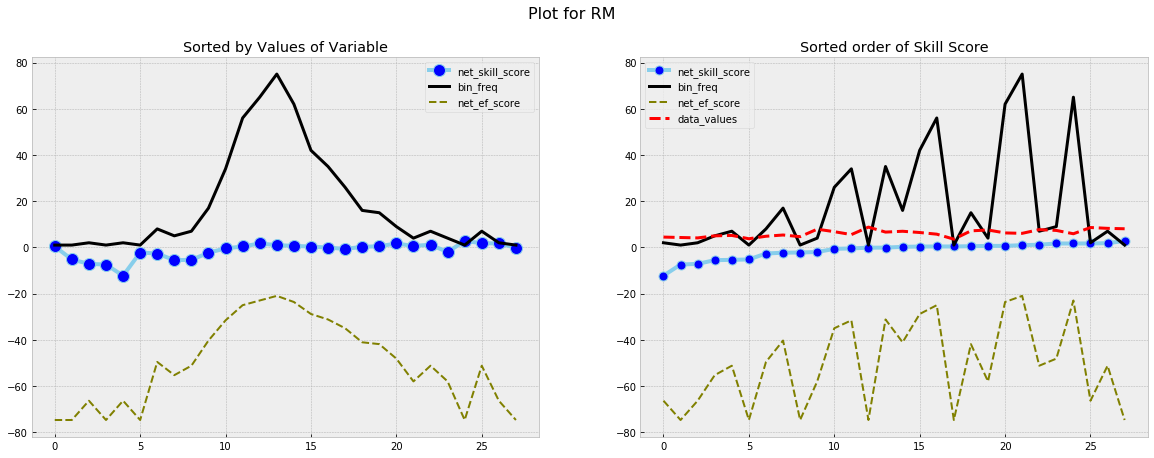

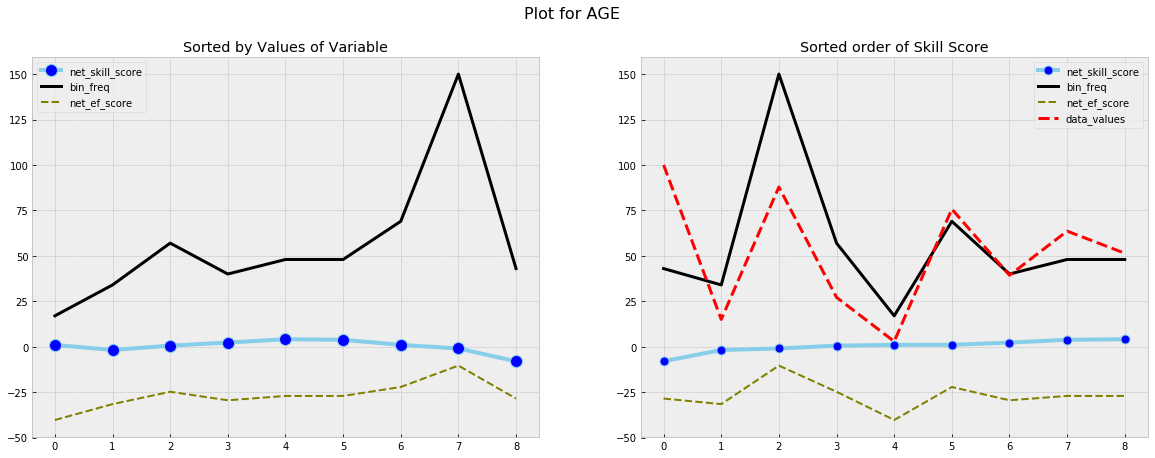

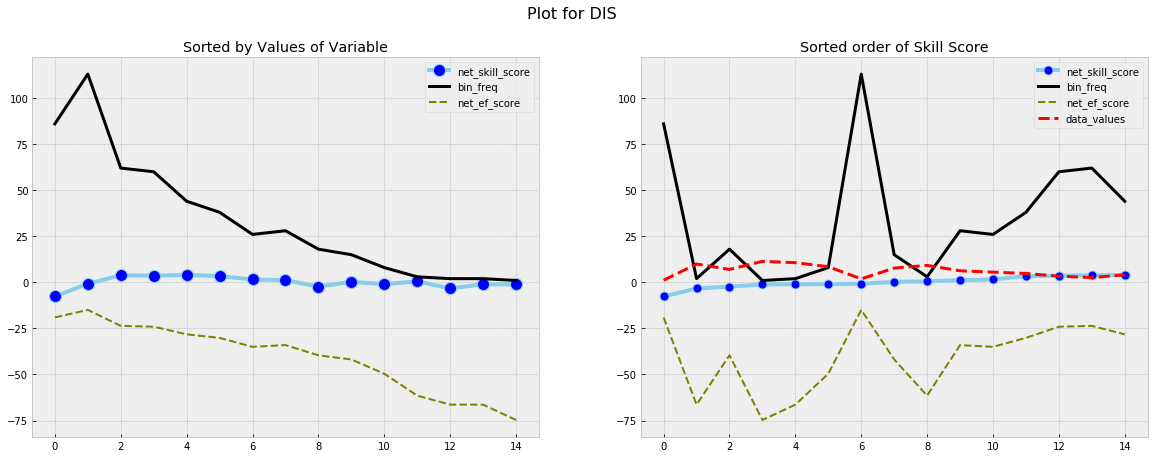

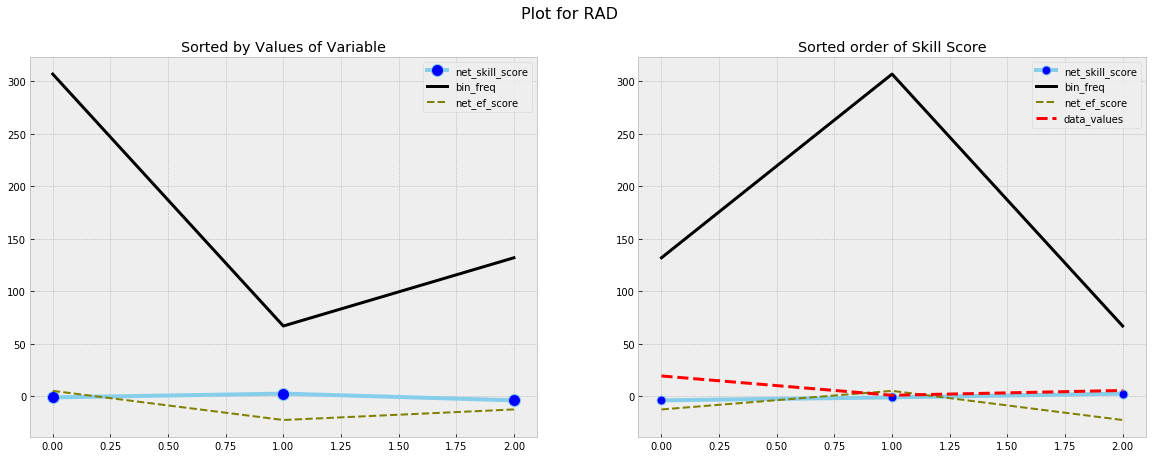

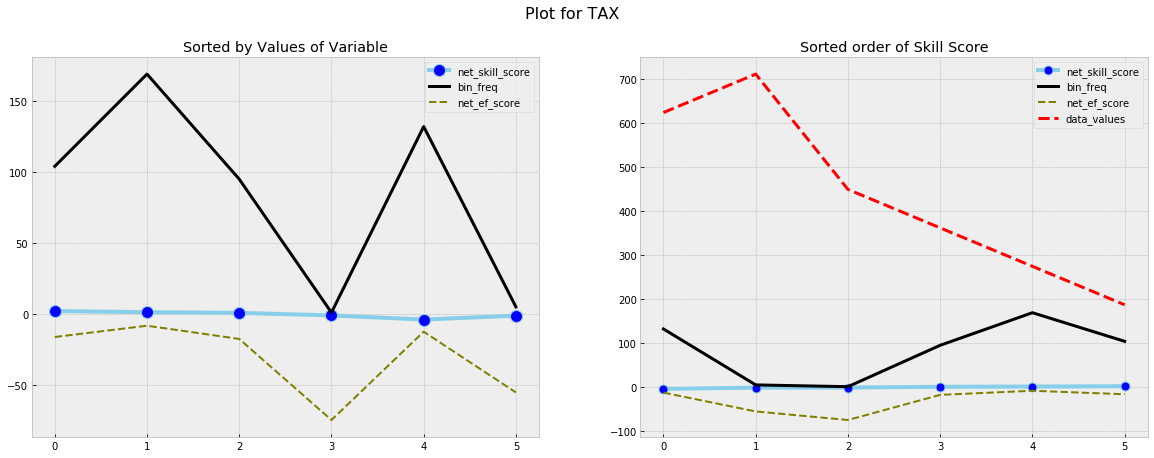

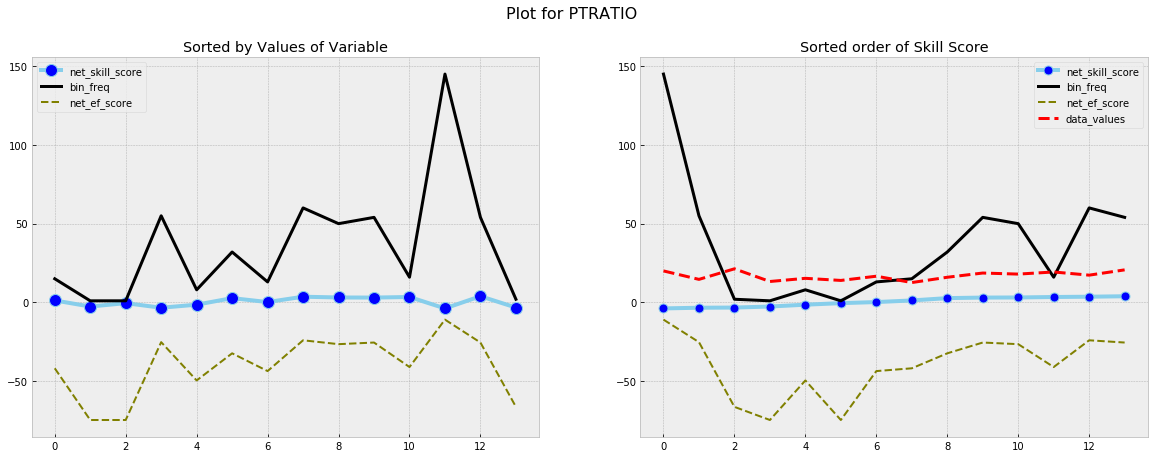

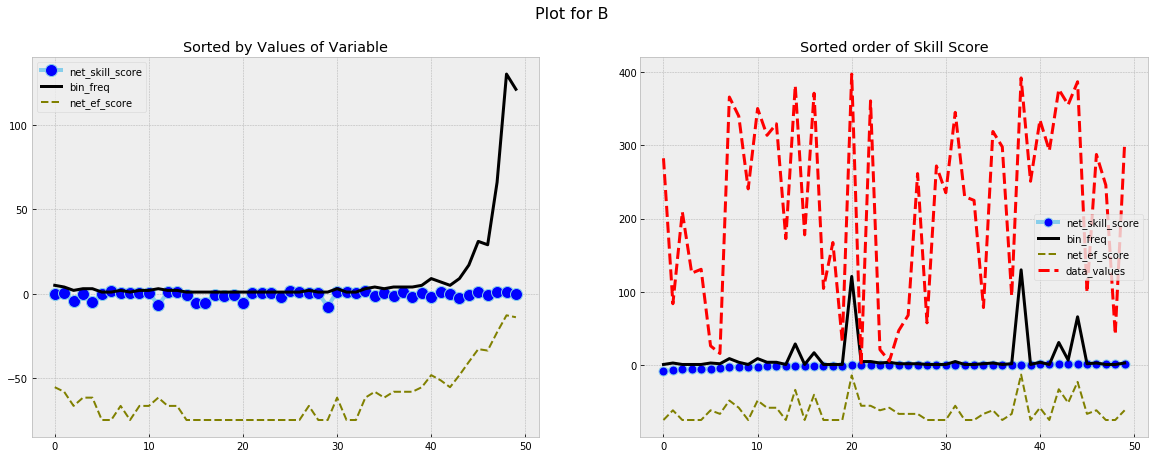

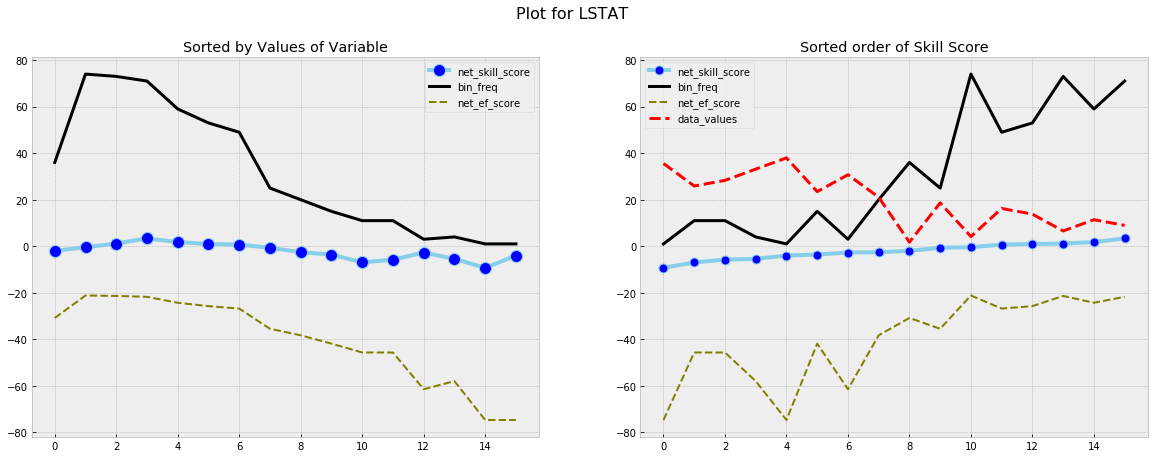

In [64]:
# doing whole step on data set in one go
counters = 0
cols = [i for i in range(0,13)]
skill_eval = [[] for _ in cols]
print(len(skill_eval))
for i in itertools.combinations(cols, 2):
#     print(i)
    eval_p = evaluate_pair(df,pair=i,skill='doolittle')
    for k,val in enumerate(i):
        skill_eval[val].append(eval_p[k])
#         print('Added evaluation for {}'.format(val))
   
    counters+=1
    
print(counters)

for k,col_skill in enumerate(skill_eval):    
    col_skill_score = []
    col_ef_score = []
    for i in col_skill:
        col_skill_score.append(i[1])
        col_ef_score.append(i[0])
    col_skill_score = np.sum(col_skill_score,axis=0)
    col_ef_score = np.sum(col_ef_score,axis = 0)
    
    # Data
    skill_df=pd.DataFrame({'value_range': range(0,col_skill_score.shape[0]), 
                           'net_skill_score': col_skill_score, 
                           'net_ef_score': col_ef_score,
                           'bin_freq': i[3] })

    # multiple line plot
    plt.figure(figsize=(20,7))
    plt.subplot(1,2,1)
    plt.plot( 'value_range', 'net_skill_score', data=skill_df, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4)
    plt.plot( 'value_range', 'bin_freq', data=skill_df, marker='', color='black', linewidth=3)
    plt.plot( 'value_range', 'net_ef_score', data=skill_df, marker='', color='olive', linewidth=2, linestyle='dashed')
    plt.title('Sorted by Values of Variable')
    plt.legend()
    
    plt.subplot(1,2,2)
    skill_df.sort_values('net_skill_score',inplace=True)
    skill_df.reset_index()
    col_ef_score = col_ef_score[np.argsort(col_skill_score)]
    hist = i[3][np.argsort(col_skill_score)]
    values = i[2][np.argsort(col_skill_score)]
    col_skill_score = col_skill_score[np.argsort(col_skill_score)]
    
#     plt.plot(i[2])
    plt.plot( col_skill_score, marker='o', markerfacecolor='blue', markersize=9, color='skyblue', linewidth=4,label = 'net_skill_score')
    plt.plot( hist, marker='', color='black', linewidth=3,label = 'bin_freq')
    plt.plot( col_ef_score, marker='', color='olive', linewidth=2, linestyle='dashed',label = 'net_ef_score')
    plt.plot( values, marker='', color='red', linewidth=3, linestyle='dashed', label = 'data_values')
    plt.title('Sorted order of Skill Score')
    plt.legend()
#     plt.xticks(values)
#     plt.xlabel(values)
    plt.suptitle('Plot for {}'.format(df.columns[k]),fontsize=16)
    plt.show()

13


/Users/jitins_lab/anaconda2/envs/hyper/lib/python3.6/site-packages/ipykernel/__main__.py:37: RuntimeWarning: overflow encountered in ulong_scalars


78


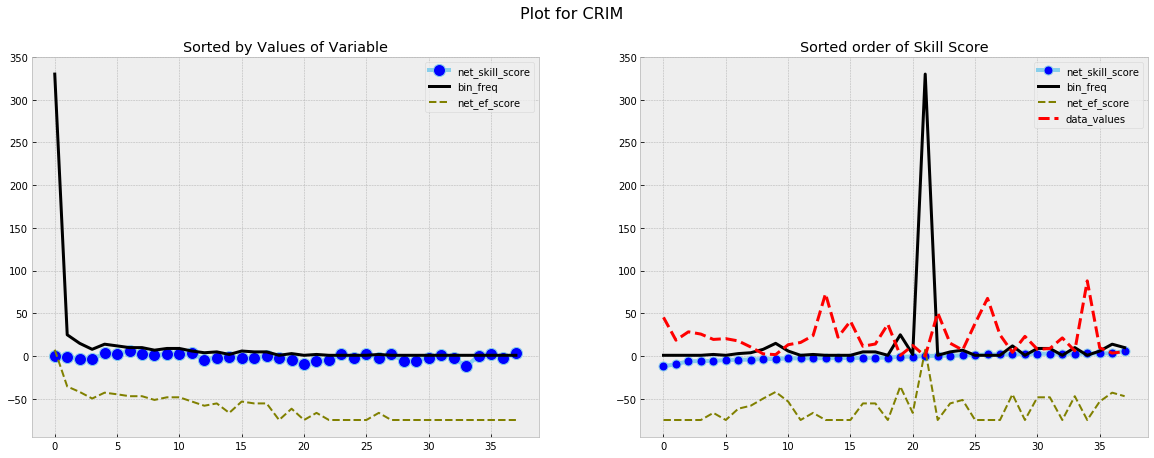

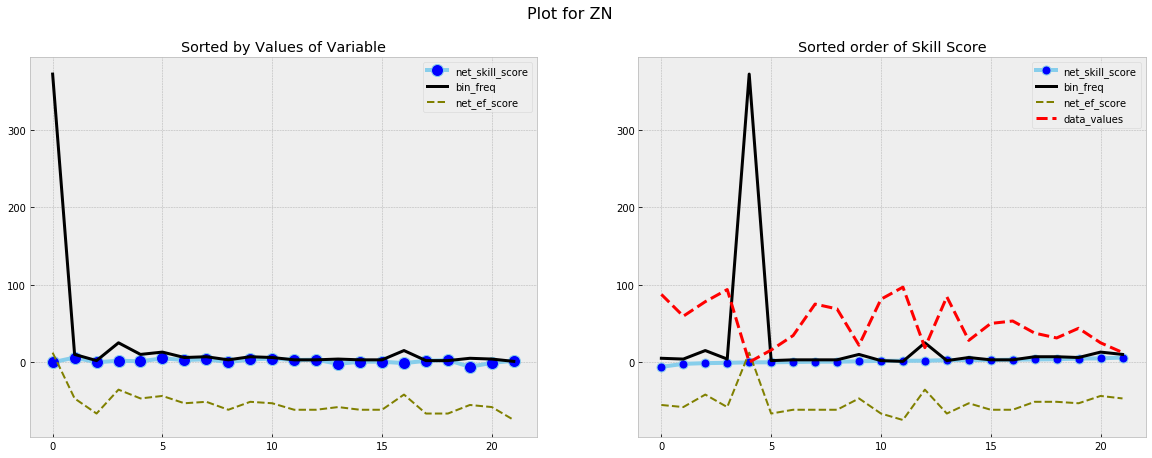

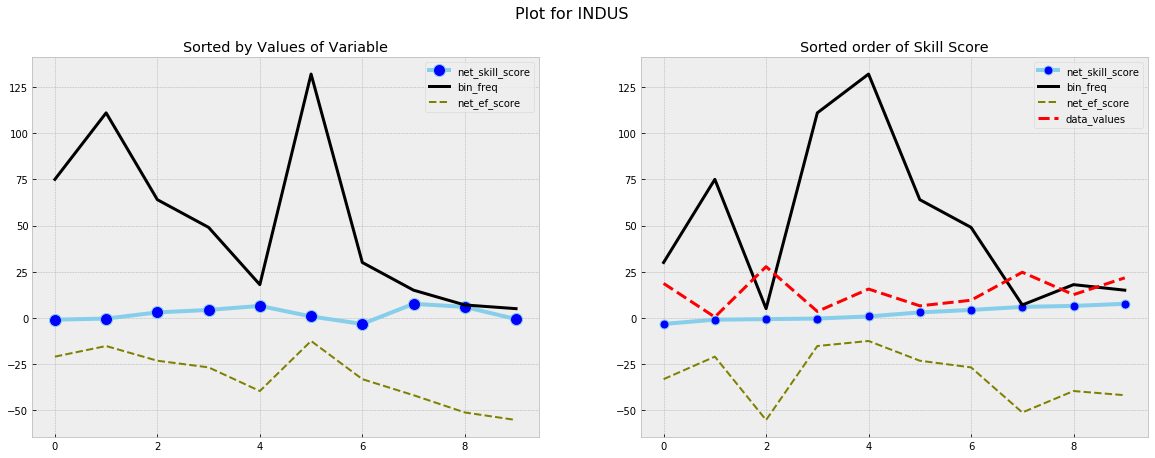

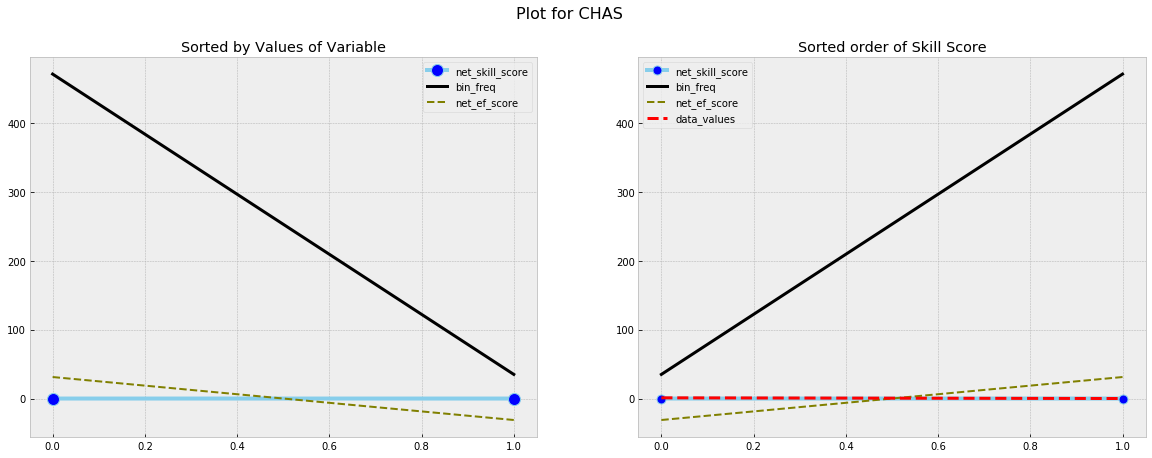

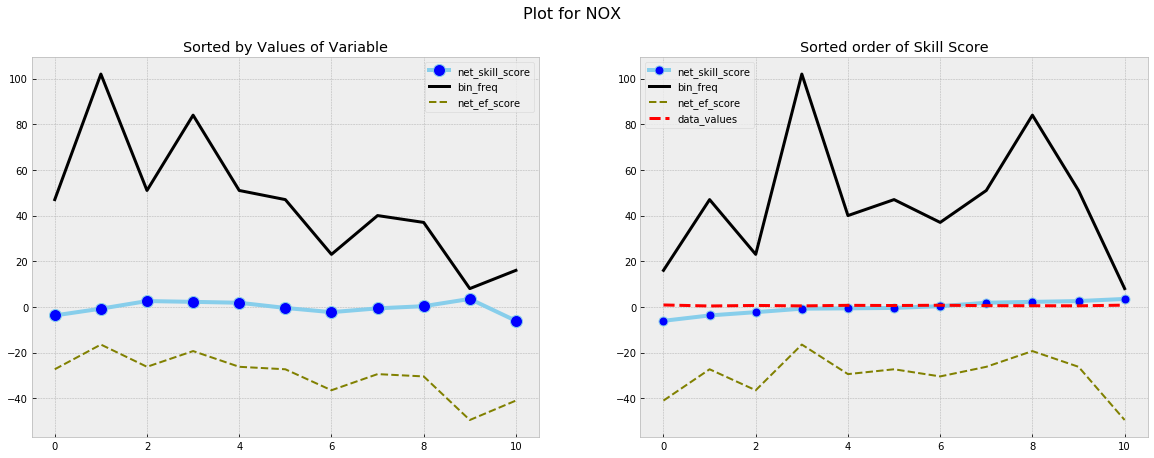

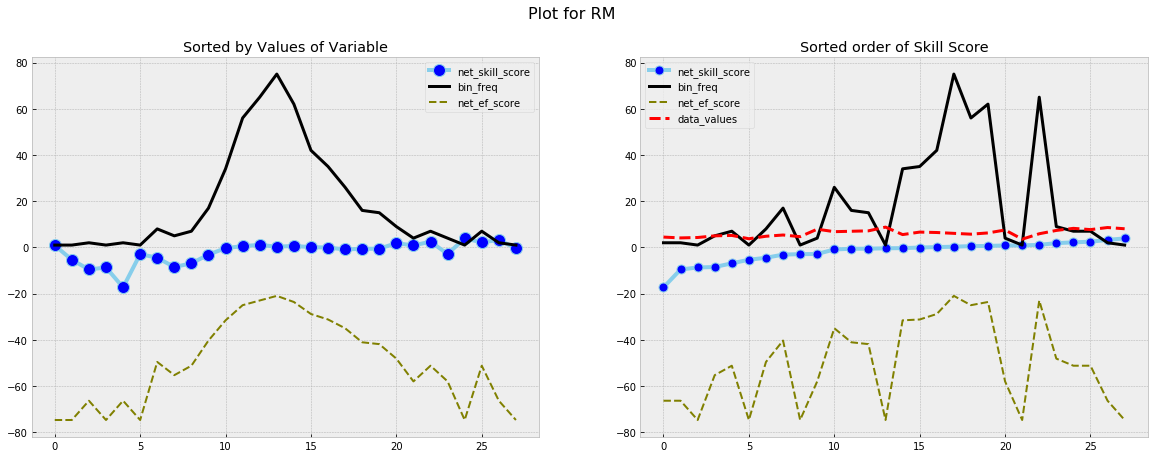

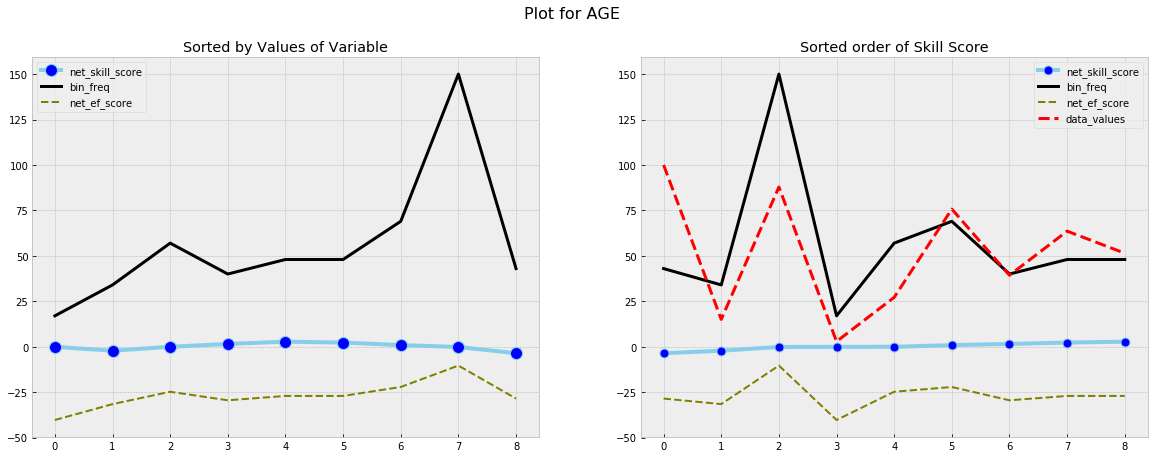

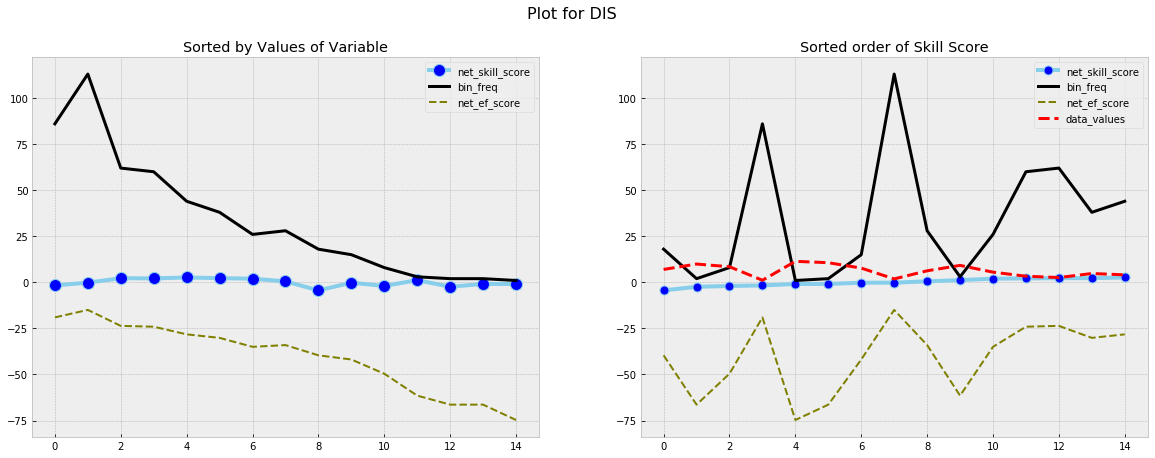

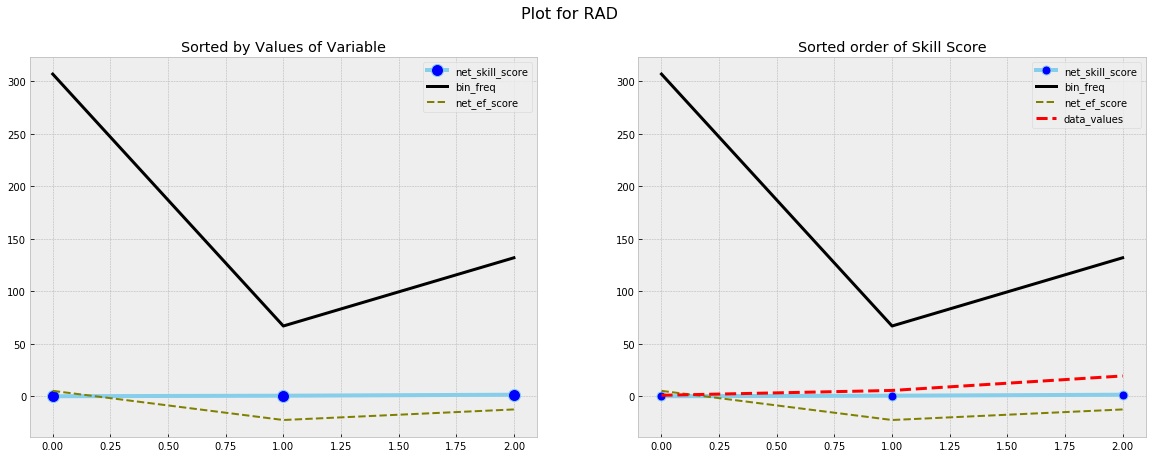

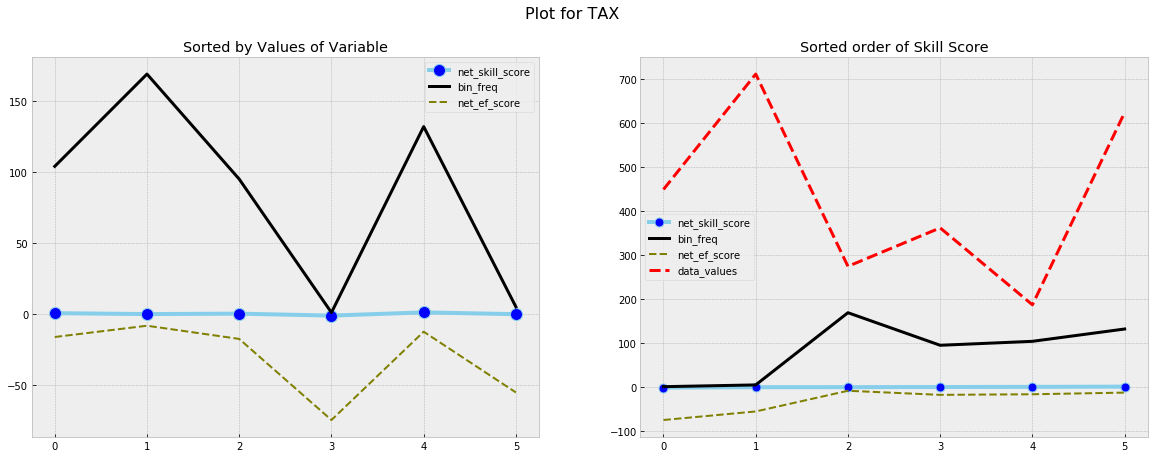

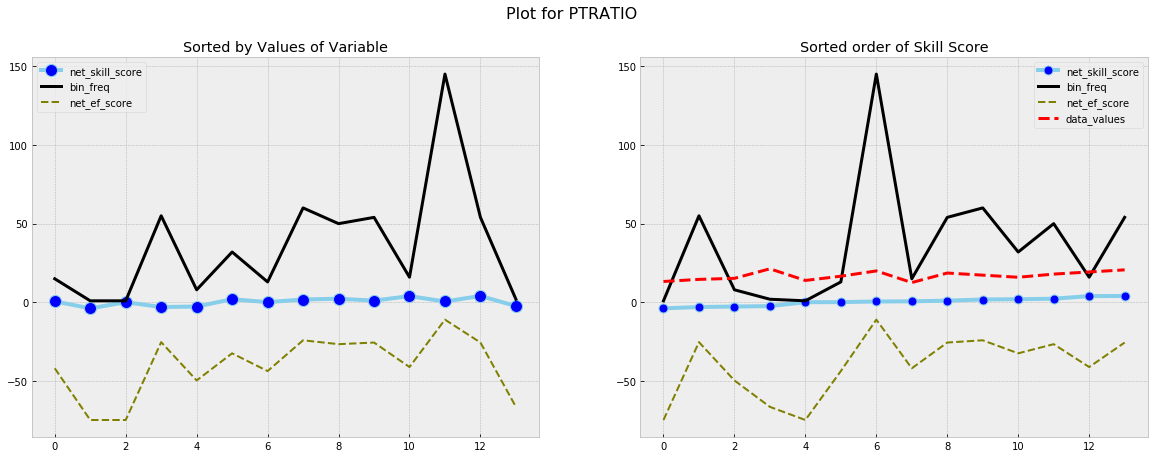

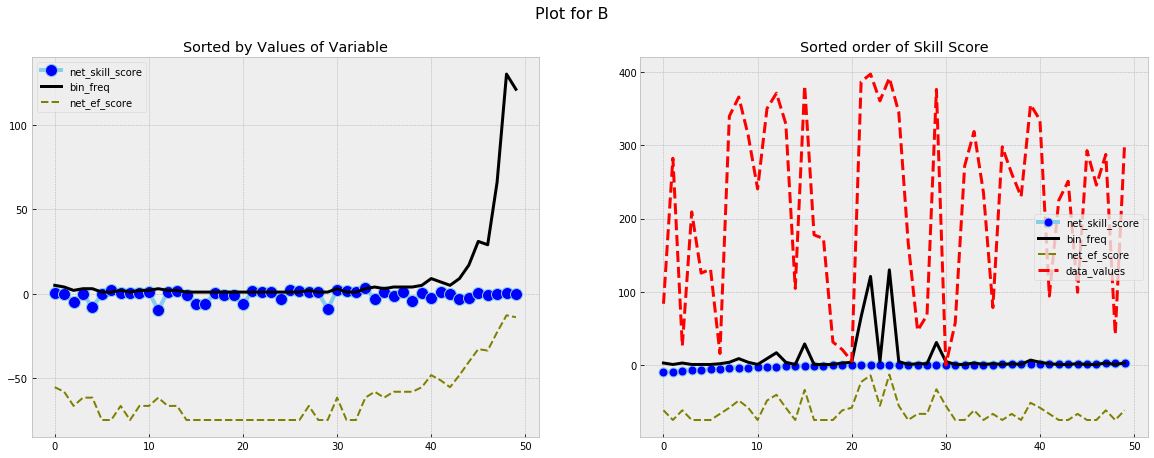

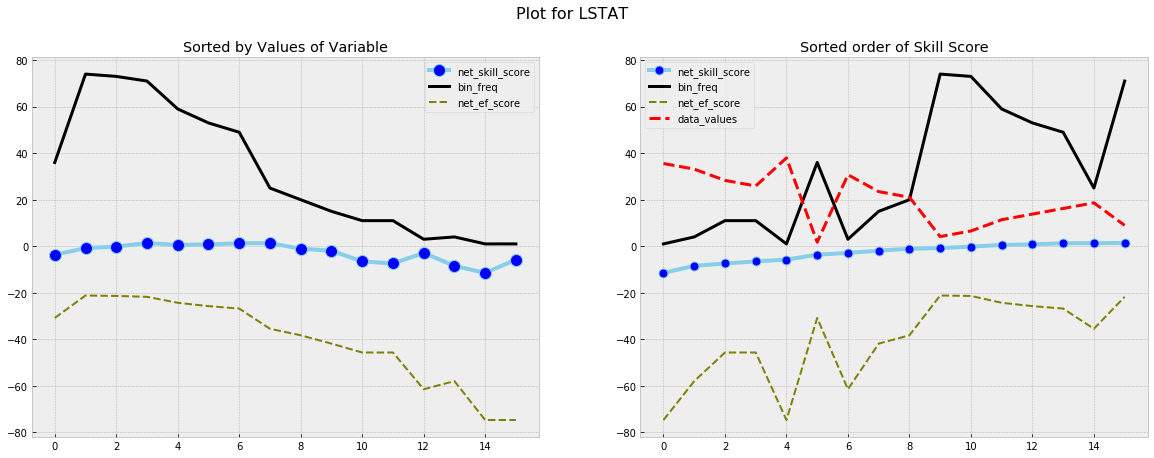

In [65]:
# doing whole step on data set in one go
counters = 0
cols = [i for i in range(0,13)]
skill_eval = [[] for _ in cols]
print(len(skill_eval))
for i in itertools.combinations(cols, 2):
#     print(i)
    eval_p = evaluate_pair(df,pair=i,skill='heidke',modified_skill=True)
    for k,val in enumerate(i):
        skill_eval[val].append(eval_p[k])
#         print('Added evaluation for {}'.format(val))
   
    counters+=1
    
print(counters)

for k,col_skill in enumerate(skill_eval):    
    col_skill_score = []
    col_ef_score = []
    for i in col_skill:
        col_skill_score.append(i[1])
        col_ef_score.append(i[0])
    col_skill_score = np.sum(col_skill_score,axis=0)
    col_ef_score = np.sum(col_ef_score,axis = 0)
    
    # Data
    skill_df=pd.DataFrame({'value_range': range(0,col_skill_score.shape[0]), 
                           'net_skill_score': col_skill_score, 
                           'net_ef_score': col_ef_score,
                           'bin_freq': i[3] })

    # multiple line plot
    plt.figure(figsize=(20,7))
    plt.subplot(1,2,1)
    plt.plot( 'value_range', 'net_skill_score', data=skill_df, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4)
    plt.plot( 'value_range', 'bin_freq', data=skill_df, marker='', color='black', linewidth=3)
    plt.plot( 'value_range', 'net_ef_score', data=skill_df, marker='', color='olive', linewidth=2, linestyle='dashed')
    plt.title('Sorted by Values of Variable')
    plt.legend()
    
    plt.subplot(1,2,2)
    skill_df.sort_values('net_skill_score',inplace=True)
    skill_df.reset_index()
    col_ef_score = col_ef_score[np.argsort(col_skill_score)]
    hist = i[3][np.argsort(col_skill_score)]
    values = i[2][np.argsort(col_skill_score)]
    col_skill_score = col_skill_score[np.argsort(col_skill_score)]
    
#     plt.plot(i[2])
    plt.plot( col_skill_score, marker='o', markerfacecolor='blue', markersize=9, color='skyblue', linewidth=4,label = 'net_skill_score')
    plt.plot( hist, marker='', color='black', linewidth=3,label = 'bin_freq')
    plt.plot( col_ef_score, marker='', color='olive', linewidth=2, linestyle='dashed',label = 'net_ef_score')
    plt.plot( values, marker='', color='red', linewidth=3, linestyle='dashed', label = 'data_values')
    plt.title('Sorted order of Skill Score')
    plt.legend()
#     plt.xticks(values)
#     plt.xlabel(values)
    plt.suptitle('Plot for {}'.format(df.columns[k]),fontsize=16)
    plt.show()

In [66]:
col_skill_score = []
col_ef_score = []
for k,col_skill in enumerate(skill_eval):    
    col_ss = []
    col_ef = []
    for i in col_skill:
        col_ss.append(i[1])
        col_ef.append(i[0])
    col_skill_score.append(np.sum(col_ss,axis=0))
    col_ef_score.append(np.sum(col_ef,axis = 0))

In [67]:
[np.max(i) for i in col_skill_score]

[6.128771127336254,
 5.9796358370267395,
 7.6172209591027178,
 -0.025172915823974844,
 3.4739040225071358,
 3.8997689975274339,
 2.7827289055662443,
 2.6338625330333496,
 1.5367663976415598,
 1.1139288016032878,
 4.0806150566372885,
 3.2337263713093094,
 1.380948820342464]

In [68]:
skill_eval[2][0][2],col_skill_score[2],skill_eval[2][0][2][col_skill_score[2] > 0],skill_eval[2][0][2][col_skill_score[2] <= 0]

(array([  0.46      ,   3.49111111,   6.52222222,   9.55333333,
         12.58444444,  15.61555556,  18.64666667,  21.67777778,
         24.70888889,  27.74      ]),
 array([-0.96625191, -0.36387229,  2.9668862 ,  4.3077922 ,  6.48833131,
         0.78466356, -3.28933213,  7.61722096,  5.95316421, -0.67943586]),
 array([  6.52222222,   9.55333333,  12.58444444,  15.61555556,
         21.67777778,  24.70888889]),
 array([  0.46      ,   3.49111111,  18.64666667,  27.74      ]))

In [69]:
skill_eval[2][0][2][col_skill_score[2] > 0],skill_eval[2][0][2][col_skill_score[2] <= 0]

(array([  6.52222222,   9.55333333,  12.58444444,  15.61555556,
         21.67777778,  24.70888889]),
 array([  0.46      ,   3.49111111,  18.64666667,  27.74      ]))

In [70]:
skill_eval[2][0][2][col_skill_score[2] <= 0]

array([  0.46      ,   3.49111111,  18.64666667,  27.74      ])

In [93]:
df.iloc[1:100,2].values

array([  7.07,   7.07,   2.18,   2.18,   2.18,   7.87,   7.87,   7.87,
         7.87,   7.87,   7.87,   7.87,   8.14,   8.14,   8.14,   8.14,
         8.14,   8.14,   8.14,   8.14,   8.14,   8.14,   8.14,   8.14,
         8.14,   8.14,   8.14,   8.14,   8.14,   8.14,   8.14,   8.14,
         8.14,   8.14,   5.96,   5.96,   5.96,   5.96,   2.95,   2.95,
         6.91,   6.91,   6.91,   6.91,   6.91,   6.91,   6.91,   6.91,
         6.91,   5.64,   5.64,   5.64,   5.64,   4.  ,   1.22,   0.74,
         1.32,   5.13,   5.13,   5.13,   5.13,   5.13,   5.13,   1.38,
         3.37,   3.37,   6.07,   6.07,   6.07,  10.81,  10.81,  10.81,
        10.81,  12.83,  12.83,  12.83,  12.83,  12.83,  12.83,   4.86,
         4.86,   4.86,   4.86,   4.49,   4.49,   4.49,   4.49,   3.41,
         3.41,   3.41,   3.41,  15.04,  15.04,  15.04,   2.89,   2.89,
         2.89,   2.89,   2.89])

In [94]:
np.digitize(df.iloc[1:100,2],skill_eval[2][0][2][col_skill_score[2] > 0])

array([1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3,
       3, 3, 0, 0, 0, 0, 0])

In [73]:
np.vstack((df.iloc[:,2].values,np.digitize(df.iloc[:,2],skill_eval[2][0][2][col_skill_score[2] > 0]))).T

array([[  2.31,   0.  ],
       [  7.07,   1.  ],
       [  7.07,   1.  ],
       ..., 
       [ 11.93,   2.  ],
       [ 11.93,   2.  ],
       [ 11.93,   2.  ]])

In [74]:
np.digitize(df.iloc[:,2],skill_eval[2][0][2]), np.unique(np.digitize(df.iloc[:,2],skill_eval[2][0][2]))[col_skill_score[2] > 0] , np.unique(np.digitize(df.iloc[:,2],skill_eval[2][0][2]))[col_skill_score[2] < 0]

(array([ 1,  3,  3,  1,  1,  1,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  2,  2,  2,  2,  1,  1,  3,  3,  3,  3,  3,  3,  3,  3,  3,  2,
         2,  2,  2,  2,  1,  1,  1,  2,  2,  2,  2,  2,  2,  1,  1,  1,  2,
         2,  2,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  2,  2,  2,  2,  2,
         2,  2,  2,  1,  1,  1,  1,  5,  5,  5,  1,  1,  1,  1,  1,  3,  3,
         3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,
         4,  9,  9,  9,  9,  9,  9,  9,  8,  8,  8,  8,  8,  8,  8,  8,  8,
         8,  8,  8,  8,  8,  8,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
         7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
         7,  7,  2,  2,  2,  2,  2,  2,  2,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,  2,
         2, 

In [75]:
split_col = np.digitize(df.iloc[:,2],skill_eval[2][0][2])
bucket_1 = np.unique(split_col)[col_skill_score[2] > 0]
bucket_2 = np.unique(split_col)[col_skill_score[2] <= 0]
# orig_indices = split_col.argsort()
# bucket_1 = orig_indices[np.searchsorted(split_col[orig_indices], bucket_1)]
# bucket_2 = orig_indices[np.searchsorted(split_col[orig_indices], bucket_2)]
print(bucket_1,bucket_2)

[3 4 5 6 8 9] [ 1  2  7 10]


In [76]:
# np.apply_along_axis(lambda x: np.any(bucket_1 == x), 0, split_col)
func_1 = np.vectorize(lambda t: np.any(bucket_1 == t))
func_2 = np.vectorize(lambda t: np.any(bucket_2 == t))
# split_col[bucket_1],split_col[bucket_2]

In [77]:
split_col[func_1(split_col)],split_col[func_2(split_col)]

(array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 9, 9, 9, 9, 9, 9, 9, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 8, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 3, 3, 3, 3, 3,
        5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3,
        3, 3, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4]),
 array([ 1,  1,  1,  1,  2,  2,  2,  2,

In [78]:
df.iloc[:,2].values[func_1(split_col)],df.iloc[:,2].values[func_2(split_col)],df.iloc[:,2].values[func_2(split_col)].shape

(array([  7.07,   7.07,   7.87,   7.87,   7.87,   7.87,   7.87,   7.87,
          7.87,   8.14,   8.14,   8.14,   8.14,   8.14,   8.14,   8.14,
          8.14,   8.14,   8.14,   8.14,   8.14,   8.14,   8.14,   8.14,
          8.14,   8.14,   8.14,   8.14,   8.14,   8.14,   8.14,   6.91,
          6.91,   6.91,   6.91,   6.91,   6.91,   6.91,   6.91,   6.91,
         10.81,  10.81,  10.81,  10.81,  12.83,  12.83,  12.83,  12.83,
         12.83,  12.83,  15.04,  15.04,  15.04,   8.56,   8.56,   8.56,
          8.56,   8.56,   8.56,   8.56,   8.56,   8.56,   8.56,   8.56,
         10.01,  10.01,  10.01,  10.01,  10.01,  10.01,  10.01,  10.01,
         10.01,  25.65,  25.65,  25.65,  25.65,  25.65,  25.65,  25.65,
         21.89,  21.89,  21.89,  21.89,  21.89,  21.89,  21.89,  21.89,
         21.89,  21.89,  21.89,  21.89,  21.89,  21.89,  21.89,  10.59,
         10.59,  10.59,  10.59,  10.59,  10.59,  10.59,  10.59,  10.59,
         10.59,  10.59,  13.89,  13.89,  13.89,  13.89,   6.96, 

In [79]:
skill_eval[2][0][2],skill_eval[2][0][3],col_skill_score[2],skill_eval[2][0][2][col_skill_score[2] > 0],skill_eval[2][0][2][col_skill_score[2] <= 0]

(array([  0.46      ,   3.49111111,   6.52222222,   9.55333333,
         12.58444444,  15.61555556,  18.64666667,  21.67777778,
         24.70888889,  27.74      ]),
 array([ 75, 111,  64,  49,  18, 132,  30,  15,   7,   5]),
 array([-0.96625191, -0.36387229,  2.9668862 ,  4.3077922 ,  6.48833131,
         0.78466356, -3.28933213,  7.61722096,  5.95316421, -0.67943586]),
 array([  6.52222222,   9.55333333,  12.58444444,  15.61555556,
         21.67777778,  24.70888889]),
 array([  0.46      ,   3.49111111,  18.64666667,  27.74      ]))

In [80]:
np.sum(skill_eval[2][0][3][col_skill_score[2] > 0]),np.sum(skill_eval[2][0][3][col_skill_score[2] <= 0])

(285, 221)

In [81]:
def column_splitter(col_val, col_binner, skill_score, return_array=False, return_true_val=False, return_indexes=False,verbose = 0):    
    split_col = np.digitize(col_val,col_binner)
    bucket_1 = np.unique(split_col)[skill_score > 0]
    bucket_2 = np.unique(split_col)[skill_score <= 0]
    func_1 = np.vectorize(lambda t: np.any(bucket_1 == t))
    func_2 = np.vectorize(lambda t: np.any(bucket_2 == t))
    if return_array:
        return split_col[func_1(split_col)], split_col[func_2(split_col)]
    elif return_true_val:
        return col_val[func_1(split_col)], col_val[func_2(split_col)]
    elif return_indexes:
        return np.where(func_1(split_col))[0], np.where(func_2(split_col))[0] 
    return func_1, func_2

def column_selector_and_splitter(df, skill_eval, selection_criteria = 'max', verbose=0):
    col_skill_score = []
    col_ef_score = []
    for k,col_skill in enumerate(skill_eval):    
        col_ss = []
        col_ef = []
        for i in col_skill:
            col_ss.append(i[1])
            col_ef.append(i[0])
        col_skill_score.append(np.sum(col_ss,axis=0))
        col_ef_score.append(np.sum(col_ef,axis = 0))
        
    if selection_criteria == 'max':
        cr = [np.max(i) for i in col_skill_score]
        sel_col = np.argmax(cr)
        print('Selected Column: {} with max value as :{}'.format(sel_col,cr[sel_col]))
    elif selection_criteria == 'diff':
        cr = [np.max(i)-np.min(i) for i in col_skill_score]
        sel_col = np.argmax(cr)
        print('Selected Column: {} with max. variation range value as :{}'.format(sel_col,cr[sel_col]))
    elif selection_criteria == 'mean':
        cr = [np.mean(i) for i in col_skill_score]
        sel_col = np.argmax(cr)
        print('Selected Column: {} with max. mean value as :{}'.format(sel_col,cr[sel_col]))
    elif selection_criteria == 'sum':
        cr = [np.sum(i) for i in col_skill_score]
        sel_col = np.argmax(cr)
        print('Selected Column: {} with max. sum value as :{}'.format(sel_col,cr[sel_col]))
    
    if isinstance(df,pd.DataFrame):
        f_1,f_2 = column_splitter(col_val=df.iloc[:,sel_col].values, col_binner=skill_eval[sel_col][0][2],skill_score=col_skill_score[sel_col],return_indexes= True)
        df1 = df.iloc[f_1,:]
        df2 = df.iloc[f_2,:]
    elif isinstance(df,np.ndarray):
        f_1,f_2 = column_splitter(col_val=df[:,sel_col], col_binner=skill_eval[sel_col][0][2],skill_score=col_skill_score[sel_col],return_indexes=True)
        df1 = df[f_1,:]
        df2 = df[f_2,:]
    else:
        raise ValueError('Only pandas dataframe and numpy array is supported right now. Kindly check input!')
    
    return df1,df2
        

In [82]:
column_splitter(col_val=df.iloc[:,2], col_binner=skill_eval[2][0][2], skill_score=col_skill_score[2], return_indexes=True)

(array([  1,   2,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,
         17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,
         30,  31,  32,  33,  34,  41,  42,  43,  44,  45,  46,  47,  48,
         49,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  92,  93,
         94, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
        112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124,
        125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137,
        138, 139, 140, 141, 205, 206, 207, 208, 209, 210, 211, 212, 213,
        214, 215, 216, 217, 218, 219, 269, 270, 271, 272, 273, 293, 294,
        295, 296, 297, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317,
        318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 356, 357, 358,
        359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371,
        372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384,
        385, 386, 387, 388, 389, 390, 391, 392, 393

In [83]:
column_selector_and_splitter(df,skill_eval=skill_eval,selection_criteria='max')

Selected Column: 2 with max value as :7.617220959102718


(         CRIM    ZN  INDUS  CHAS    NOX     RM    AGE     DIS   RAD    TAX  \
 1     0.02731   0.0   7.07   0.0  0.469  6.421   78.9  4.9671   2.0  242.0   
 2     0.02729   0.0   7.07   0.0  0.469  7.185   61.1  4.9671   2.0  242.0   
 6     0.08829  12.5   7.87   0.0  0.524  6.012   66.6  5.5605   5.0  311.0   
 7     0.14455  12.5   7.87   0.0  0.524  6.172   96.1  5.9505   5.0  311.0   
 8     0.21124  12.5   7.87   0.0  0.524  5.631  100.0  6.0821   5.0  311.0   
 9     0.17004  12.5   7.87   0.0  0.524  6.004   85.9  6.5921   5.0  311.0   
 10    0.22489  12.5   7.87   0.0  0.524  6.377   94.3  6.3467   5.0  311.0   
 11    0.11747  12.5   7.87   0.0  0.524  6.009   82.9  6.2267   5.0  311.0   
 12    0.09378  12.5   7.87   0.0  0.524  5.889   39.0  5.4509   5.0  311.0   
 13    0.62976   0.0   8.14   0.0  0.538  5.949   61.8  4.7075   4.0  307.0   
 14    0.63796   0.0   8.14   0.0  0.538  6.096   84.5  4.4619   4.0  307.0   
 15    0.62739   0.0   8.14   0.0  0.538  5.834   56

In [85]:
class EvidenceTree:
    
    def __init__(self, parent=None, depth=0, selection_criteria='max', skill ='doolittle', bins = 'fd', stopping_criteria = 'evidence', plots=False, verbose = 0):
        
        # basic tree requirements
        self.parent = parent
        self.depth = depth
        self.children = []
        self.value = []
        self.skill_score = []
        self.is_end = False
        
        # behaviour specific requirements
        self.selection_criteria = selection_criteria
        self.skill = skill
        
        if isinstance(bins, list) or isinstance(bins, tuple):
            if len(bins) == 2:
                self.bins = bins
            elif len(bins) > 2:
                warning.warn('Number of Bins must be equal to number of columns. If not, defualt as \'fd\' will be applied to all columns!')
            elif len(bins) < 2:
                self.bins = (bins[0],bins[0]) 
        elif isinstance(bins,str) or isinstance(bins, int):
            self.bins = (bins,bins)
            
        self.stopping_criteria = stopping_criteria
        
        # values to be stored in original data
        self.n_rows = None
        self.n_cols = None
        # self.association = None
        # self.classification = None
        # self.estimation = None
        self.similarity = None
        self.evidence = None
        
        #tree generation step specific:
        self.plots = plots
        self.verbose = verbose
    
    def split(self, df, n_row, n_col):
        counters = 0
        cols = [i for i in range(0,df.shape[1])]              
        skill_eval = [[] for _ in cols]
        
        
        if self.verbose > 1:
            print('Columns to be tested: {}'.format(len(skill_eval)))
        for i in itertools.combinations(cols, 2):
            eval_p = evaluate_pair(df, pair=i, bins=self.bins, skill=self.skill, verbose=self.verbose)
            for k,val in enumerate(i):
                skill_eval[val].append(eval_p[k])
                if self.verbose >0:
                    print('Added evaluation for {}'.format(val))
            counters+=1
        
        print('Total evalutions at depth {} are {}'.format(self.depth,counters))
        
        self.value = column_selector_and_splitter(df, skill_eval=skill_eval, selection_criteria=self.selection_criteria)
        
        if self.stopping_criteria == 'evidence':
            if df.shape[0] > np.ceil(n_row*0.05) :
                return
            else:
                self.value = []
                self.is_end = True
                return
        else:
              # yet to think of other stopping criterias
                pass
        
#         split_array = []
#         if splits == None:
#             self.value = []
#             self.is_end = True
#             return
#         else:
#             self.value = list(splits)
#             return
            
                
    def recursive_splits(self, df, n_row, n_col):
        self.split(df, n_row, n_col)
        if len(self.value) == 2:
            for i in self.value:
                try:
                    new_node = EvidenceTree(self,depth=(self.depth+1),selection_criteria=self.selection_criteria, 
                                            skill =self.skill, bins = self.bins, stopping_criteria = self.stopping_criteria, 
                                            plots=self.plots, verbose = self.verbose)
                    new_node.n_rows = n_row
                    new_node.n_cols = n_col
                    new_node.recursive_splits(i, n_row, n_col)
                    self.children.append(new_node)
                except:
                    self.children.append(None)
        else:
            print('node completed')
            self.is_end = True
            return
        
    def fit(self,data):
        self.n_rows,self.n_cols = data.shape
        self.recursive_splits(data, self.n_rows, self.n_cols)
    
    def __repr__(self):

        if self.depth == 0:
            spacer = '|~~'
        else:
            spacer = '|  '*(self.depth)+'|~~'
        
        s = spacer+'Node at depth {} has {} children and Value: \n{}{}\n'.format((self.depth+1),sum([
                    True if i is not None else  False for i in self.children]),spacer,
                    [i.shape if i.shape is not () else i for i in self.value])
        for i in self.children:
            if i is not None:
                s += i.__repr__()
        
        return s
            
    def expand(img, resolution):
        pass

    def collect(self,zoom,axis=0):
#         if not self.is_leaf:
        value = []
        for idx,child in enumerate(self.children):
            if child is not None:
                val_ = child.collect(zoom)
#                 try:
#                     shp = np.asarray(val_).shape
#                     val_ = val_.reshape((1,81))
#                 except:
#                     shp = val_
#                 print('\nAt depth {} for child {} shape of value is \n{}'.format(self.depth,idx,val_))
                value.append(val_)
            else: 
                val_ = self.value
#                 print('\nAt depth {} for child {} shape of value is \n{}'.format(self.depth,idx,val_))
                value.append(val_)
        if self.depth == 0 and idx == 8:
            return value
        return self.agg_func(value,axis)
            
    
    def is_leaf(self):
        """Check if leaf node (i.e. no nodes below this have been expanded)."""
        return sum([True if i is not None else  False for i in self.children]) == 0

    def is_root(self):
        return self.parent is None

# tree = TreeNode(None,depth=0,
#                 func = lambda x: np.round(np.max(x)-np.min(x),2),
# #                 agg_func = lambda x : np.mean(x,axis=1),
#                 constrain='hard')
# tree.recursive_splits(img,4)

In [102]:
tree = EvidenceTree(bins=35,verbose=1)

In [103]:
tree.fit(df.iloc[:,0:13].values)

Evident number of Bins: 2
Evident number of Bins: 7
Crosstab Matrix:
[[381  50  23  12   7  22   9   1 505]
 [  1   0   0   0   0   0   0   0   1]
 [382  50  23  12   7  22   9   1 506]]
Net 'doolittle' Skill Score: -4.434386885465713e-17
Added evaluation for 0
Added evaluation for 1
Evident number of Bins: 2
Evident number of Bins: 9
Crosstab Matrix:
[[ 75 111  64  49  18 131  30  15   7   5 505]
 [  0   0   0   0   0   1   0   0   0   0   1]
 [ 75 111  64  49  18 132  30  15   7   5 506]]
Net 'doolittle' Skill Score: 2.7191790485936452e-17
Added evaluation for 0
Added evaluation for 2
Evident number of Bins: 2
Evident number of Bins: 34
Data has uniques:
 [ 0.  1.] 
and respective WOE:
 [2.5995100325270042, -2.5995100325270042] Net WOE: 0.0


/Users/jitins_lab/anaconda2/envs/hyper/lib/python3.6/site-packages/ipykernel/__main__.py:37: RuntimeWarning: overflow encountered in ulong_scalars


IndexError: tuple index out of range

In [98]:
tree

|~~Node at depth 1 has 2 children and Value: 
|~~[(264, 13), (242, 13)]
|  |~~Node at depth 2 has 1 children and Value: 
|  |~~[(96, 13), (168, 13)]
|  |  |~~Node at depth 3 has 1 children and Value: 
|  |  |~~[(64, 13), (104, 13)]
|  |  |  |~~Node at depth 4 has 0 children and Value: 
|  |  |  |~~[(76, 13), (28, 13)]
|  |~~Node at depth 2 has 1 children and Value: 
|  |~~[(126, 13), (116, 13)]
|  |  |~~Node at depth 3 has 1 children and Value: 
|  |  |~~[(86, 13), (40, 13)]
|  |  |  |~~Node at depth 4 has 0 children and Value: 
|  |  |  |~~[(0, 13), (0, 13)]